# Technical Analysis

## 1. Introduction

Technical analysis is the use of charts and technical indicators to identify trading signals and price patterns.  Various technical strategies will be investigated using the most common indicators.

## 2. Install/import libraries

In [381]:
!pip install yfinance as yfinance
!pip install mplfinance

ERROR: Could not find a version that satisfies the requirement as (from versions: none)
ERROR: No matching distribution found for as


In [382]:
import yfinance as yf

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.style as style
from matplotlib.dates import date2num, DateFormatter, WeekdayLocator,\
    DayLocator, MONDAY
import seaborn as sns

import mplfinance as mpf
from mplfinance.original_flavor import candlestick_ohlc

from scipy import stats
from scipy.stats import zscore
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint

import datetime
from datetime import date, timedelta

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## 3. Import data

Read in Nifty50 stock data downloaded from Yahoo! Finance using yfinance API into a pandas dataframe. The stocks chosen are RELIANCE.NS  BPCL.NS HINDPETRO.NS TECHM.NS INFY.NS WIPRO.NS HINDUNILVR.NS BRITANNIA.NS NESTLEIND.NS BAJAJ-AUTO.NS MARUTI.NS EICHERMOT.NS AXISBANK.NS ICICIBANK.NS HDFCBANK.NS

In [383]:
nifty_stocks = yf.download("RELIANCE.NS  BPCL.NS HINDPETRO.NS TECHM.NS INFY.NS WIPRO.NS HINDUNILVR.NS BRITANNIA.NS NESTLEIND.NS BAJAJ-AUTO.NS MARUTI.NS EICHERMOT.NS   AXISBANK.NS ICICIBANK.NS HDFCBANK.NS", start=datetime.datetime(2007, 4, 1), 
                                      end=datetime.datetime(2023, 3, 31), group_by='tickers')

[*********************100%***********************]  15 of 15 completed


RELIANCE INDUSTRY stock data will be selected for plotting charts and testing various trading strategies to determine when to buy and sell stock.

In [384]:
RELIANCEINDUSTRY =  nifty_stocks['RELIANCE.NS']
                                     
RELIANCEINDUSTRY.head()

Open        High         Low       Close   Adj Close  \
Date                                                                     
2007-04-02  335.569153  336.510223  323.248413  325.403015  291.745697   
2007-04-03  327.025116  333.340271  324.300964  332.040100  297.696259   
2007-04-04  333.835571  339.023895  333.761261  337.612274  302.692047   
2007-04-05  337.550354  337.996124  334.875702  336.522614  301.715179   
2007-04-09  338.045654  343.741669  337.302704  342.825348  307.365936   

              Volume  
Date                  
2007-04-02  13286092  
2007-04-03  10745415  
2007-04-04   8035662  
2007-04-05   4899877  
2007-04-09   4489883

## 4. Visualising stock data

**Japanese candlestick charts** are tools used in a particular trading style called price action to predict market movement through pattern recognition of continuations, breakouts and reversals. 

Unlike a line chart, all of the price information can be viewed in one figure showing the high, low, open and close price of the day or chosen time frame. Price action traders observe patterns formed by green bullish candles where the stock is trending upwards over time, and red or black bearish candles where there is a downward trend.

In [385]:
def pandas_candlestick_ohlc(dat, stick = "day", otherseries = None):
    """
    Japanese candlestick chart showing OHLC prices for a specified time period
    
    :param dat: pandas dataframe object with datetime64 index, and float columns "Open", "High", "Low", and "Close"
    :param stick: A string or number indicating the period of time covered by a single candlestick. Valid string inputs include "day", "week", "month", and "year", ("day" default), and any numeric input indicates the number of trading days included in a period
    :param otherseries: An iterable that will be coerced into a list, containing the columns of dat that hold other series to be plotted as lines
 
    :returns: a Japanese candlestick plot for stock data stored in dat, also plotting other series if passed.
    """
    mondays = WeekdayLocator(MONDAY)        # major ticks on the mondays
    alldays = DayLocator()              # minor ticks on the days
    dayFormatter = DateFormatter('%d')      # e.g., 12
 
    # Create a new DataFrame which includes OHLC data for each period specified by stick input
    transdat = dat.loc[:,["Open", "High", "Low", "Close"]]
    if (type(stick) == str):
        if stick == "day":
            plotdat = transdat
            stick = 1 # Used for plotting
        elif stick in ["week", "month", "year"]:
            if stick == "week":
                transdat["week"] = pd.to_datetime(transdat.index).map(lambda x: x.isocalendar()[1]) # Identify weeks
            elif stick == "month":
                transdat["month"] = pd.to_datetime(transdat.index).map(lambda x: x.month) # Identify months
            transdat["year"] = pd.to_datetime(transdat.index).map(lambda x: x.isocalendar()[0]) # Identify years
            grouped = transdat.groupby(list(set(["year",stick]))) # Group by year and other appropriate variable
            plotdat = pd.DataFrame({"Open": [], "High": [], "Low": [], "Close": []}) # Create empty data frame containing what will be plotted
            for name, group in grouped:
                plotdat = plotdat.append(pd.DataFrame({"Open": group.iloc[0,0],
                                            "High": max(group.High),
                                            "Low": min(group.NSow),
                                            "Close": group.iloc[-1,3]},
                                           index = [group.index[0]]))
            if stick == "week": stick = 5
            elif stick == "month": stick = 30
            elif stick == "year": stick = 365
 
    elif (type(stick) == int and stick >= 1):
        transdat["stick"] = [np.floor(i / stick) for i in range(len(transdat.index))]
        grouped = transdat.groupby("stick")
        plotdat = pd.DataFrame({"Open": [], "High": [], "Low": [], "Close": []}) # Create empty data frame containing what will be plotted
        for name, group in grouped:
            plotdat = plotdat.append(pd.DataFrame({"Open": group.iloc[0,0],
                                        "High": max(group.High),
                                        "Low": min(group.NSow),
                                        "Close": group.iloc[-1,3]},
                                       index = [group.index[0]]))
 
    else:
        raise ValueError('Valid inputs to argument "stick" include the strings "day", "week", "month", "year", or a positive integer')
 
 
    # Set plot parameters, including the axis object ax used for plotting
    fig, ax = plt.subplots()
    fig.subplots_adjust(bottom=0.2)
    if plotdat.index[-1] - plotdat.index[0] < pd.Timedelta('730 days'):
        weekFormatter = DateFormatter('%b %d')  # e.g., Jan 12
        ax.xaxis.set_major_locator(mondays)
        ax.xaxis.set_minor_locator(alldays)
    else:
        weekFormatter = DateFormatter('%b %d, %Y')
    ax.xaxis.set_major_formatter(weekFormatter)
 
    ax.grid(True)
 
    # Create the candelstick chart
    candlestick_ohlc(ax, list(zip(list(date2num(plotdat.index.tolist())), plotdat["Open"].tolist(), plotdat["High"].tolist(),
                      plotdat["Low"].tolist(), plotdat["Close"].tolist())),
                      colorup = "green", colordown = "red", width = stick * .4)
 
    # Plot other series (such as moving averages) as lines
    if otherseries != None:
        if type(otherseries) != list:
            otherseries = [otherseries]
        dat.loc[:,otherseries].plot(ax = ax, lw = 1.3, grid = True)
 
    ax.xaxis_date()
    ax.autoscale_view()
    plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
    sns.set(rc={'figure.figsize':(20, 10)})
    plt.style.use('seaborn-whitegrid')
    plt.title(f"Candlestick chart of {txt}", color = 'black', fontsize = 20)
    plt.xlabel('Date', color = 'black', fontsize = 15)
    plt.ylabel('Stock Price (p)', color = 'black', fontsize = 15);
 
    plt.show()

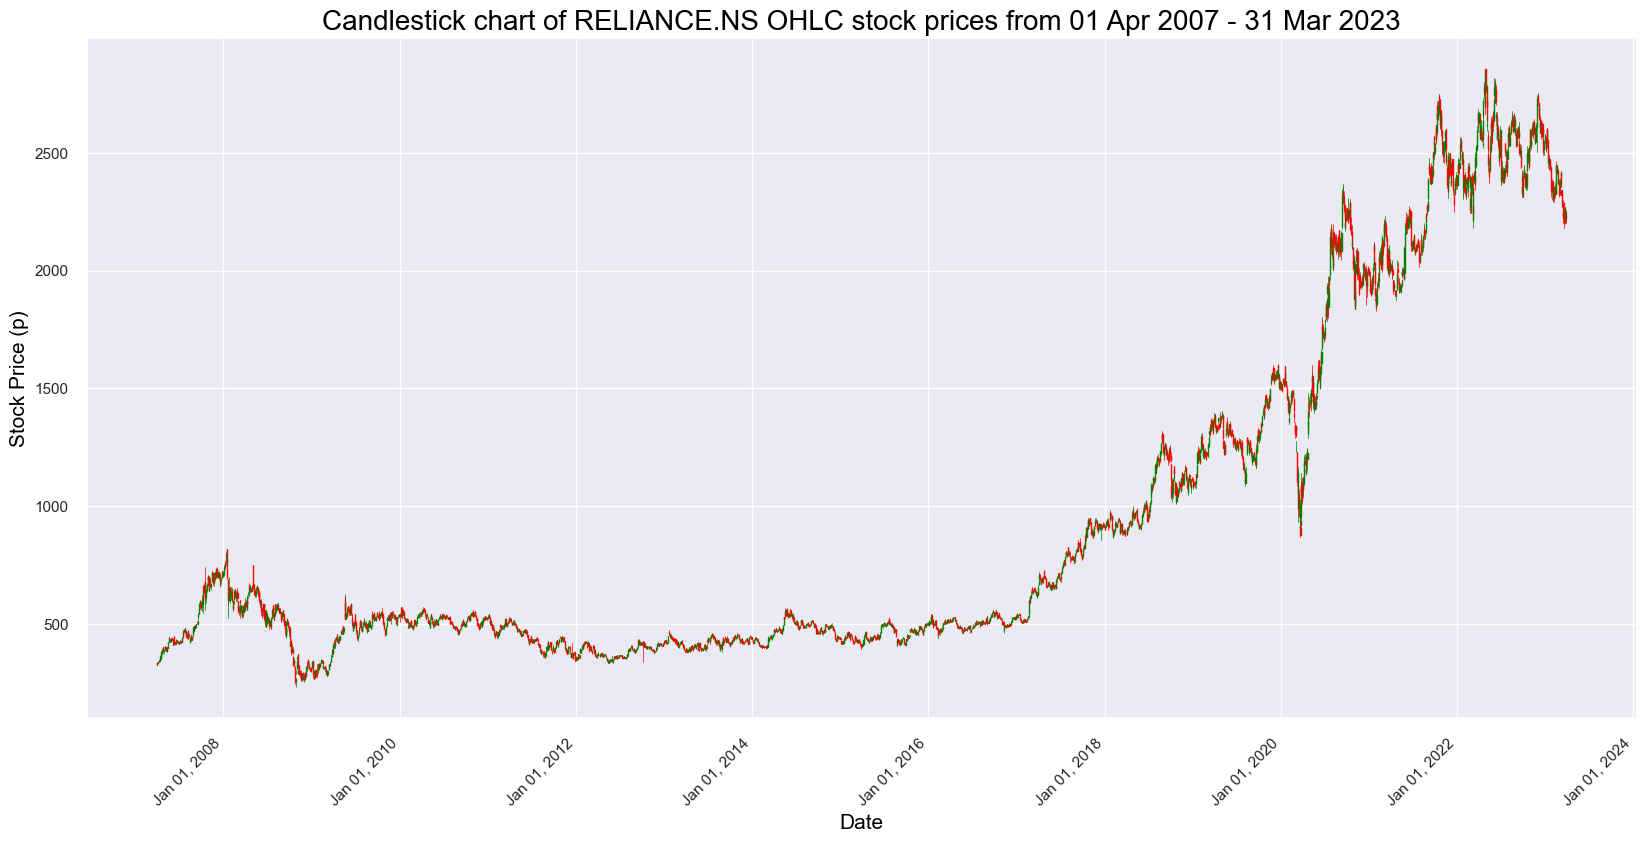

In [386]:
# Plot candlestick chart for 10 year period from 2013-2023
txt = "RELIANCE.NS OHLC stock prices from 01 Apr 2007 - 31 Mar 2023"

pandas_candlestick_ohlc(RELIANCEINDUSTRY, stick="day")

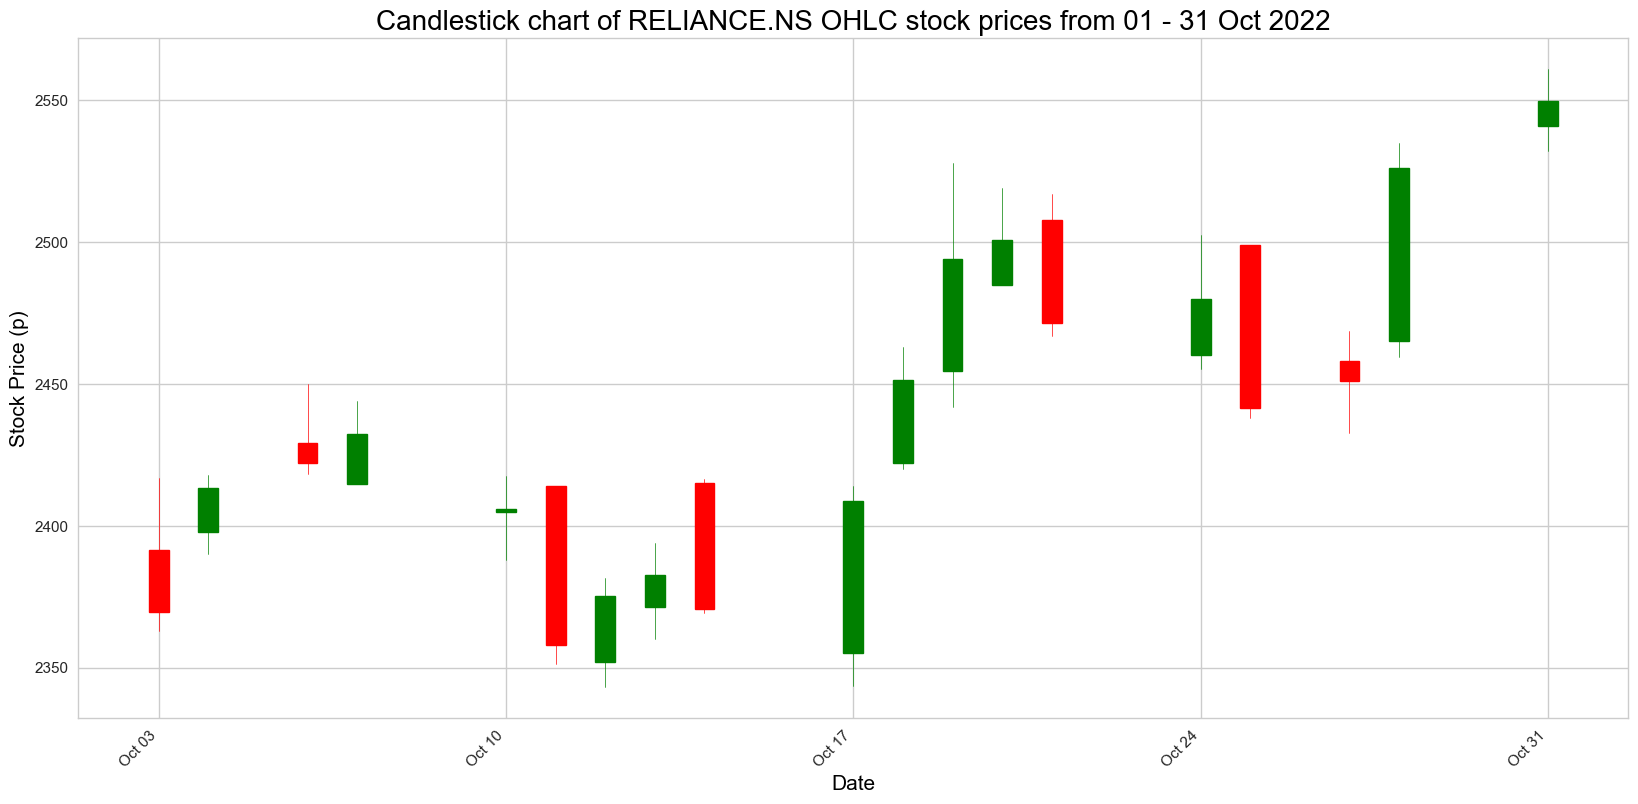

In [387]:
# Plot candlestick chart for one month period for Oct 2022

txt = "RELIANCE.NS OHLC stock prices from 01 - 31 Oct 2022"

pandas_candlestick_ohlc(RELIANCEINDUSTRY['2022-10-01':'2022-10-31'], stick="day")

## 5. Technical Indicators and Strategies

A technical indicator is a series of data points that are derived by applying a formula to the price data of a security. Basically, they are price-derived indicators that use formulas to translate the momentum or price levels into quantifiable time series. 

There are two categories of indicator: **leading** and **lagging**, and four types: **trend**, **momentum**, **volatility** and **volume**, which serve three broad functions: to **alert**, to **confirm** and to **predict**.

## 5.1 Trend-following strategies

Trend-following is about profiting from the prevailing trend through  buying an asset when its price trend goes up, and selling when its trend goes down, expecting price movements to continue.

### 5.1.1 Moving averages
Moving averages smooth a series filtering out noise to help identify trends, one of the fundamental principles of technical analysis being that prices move in trends. Types of moving averages include simple, exponential, smoothed, linear-weighted, MACD, and as lagging indicators they follow the price action and are commonly referred to as trend-following indicators.

### 5.1.2 Simple Moving Average (SMA)

The simplest form of a moving average, known as a Simple Moving Average (SMA), is calculated by taking the arithmetic mean of a given set of values over a set time period.  This model is probably the most naive approach to time series modelling and simply states that the next observation is the mean of all past observations and each value in the time period carries equal weight. 

Modelling this an as average calculation problem we would try to predict the future stock market prices (for example, x<sub>t</sub>+1 ) as an average of the previously observed stock market prices within a fixed size window (for example, x<sub>t</sub>-n, ..., x<sub>t</sub>). This helps smooth out the price data by creating a constantly updated average price so that the impacts of random, short-term fluctuations on
the price of a stock over a specified time-frame are mitigated.

In [388]:
def sma():
  plt.figure(figsize=(15,9))
  nifty_stocks[ticker]['Adj Close'].loc['2022-04-01':'2023-03-31'].rolling(window=20).mean().plot(label='20 Day Avg')
  nifty_stocks[ticker]['Adj Close'].loc['2022-04-01':'2023-03-31'].plot(label=f"{label_txt}")
  plt.title(f"{title_txt}", color = 'black', fontsize = 20)
  plt.xlabel('Date', color = 'black', fontsize = 15)
  plt.ylabel('Stock Price (p)', color = 'black', fontsize = 15);
  plt.legend()

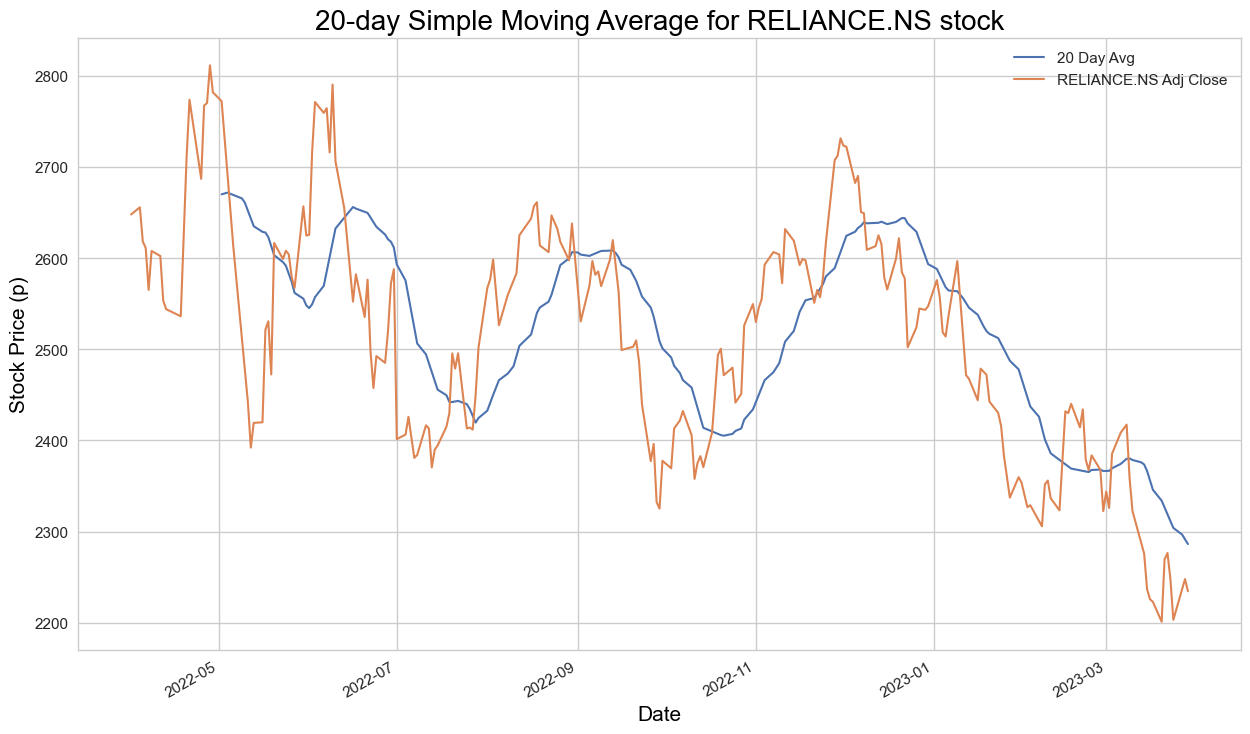

In [389]:

ticker = 'RELIANCE.NS'
title_txt = "20-day Simple Moving Average for RELIANCE.NS stock"
label_txt = "RELIANCE.NS Adj Close"

sma()

The SMA follows the time series removing noise from the
signal and keeping the relevant information about the trend. If the stock price is above its moving average it is assumed that it will likely continue rising in an uptrend. 

### 5.1.3 Moving Average Crossover Strategy

The most popular moving average crossover strategy, and the "Hello World!" of quantitative trading, being the easiest to construct, is based on the simple moving average. When moving averages cross, it is usually confirmation of a change in the prevailing trend, and we want to test whether over the long term the lag caused by the moving average can still give us profitable trades.

Depending on the type of investor or trader (high risk vs. low risk, short-term vs. long-term trading), you can adjust your moving ‘time’ average (10 days, 20 days, 50 days, 200 days, 1 year, 5 years, etc). The longer the period of an SMA, the longer the time horizon of the trend it spots. The most commonly used SMA periods are 20 for short-term (swing) trading, 50 for medium-term (position) trading and 200 for long-term (portfolio) trading.

There is no single right answer and this will vary according to whether a trader is planning to buy when the trend is going down and sell when it's going up, potentially making short-term gains, or to hold for a more long-term investment.

In [390]:
def sma2():
  plt.figure(figsize=(15,9))
  nifty_stocks[ticker]['Adj Close'].loc['2020-04-01':'2023-03-31'].rolling(window=20).mean().plot(label='20 Day Avg')
  nifty_stocks[ticker]['Adj Close'].loc['2020-04-01':'2023-03-31'].rolling(window=50).mean().plot(label='50 Day Avg')
  nifty_stocks[ticker]['Adj Close'].loc['2020-04-01':'2023-03-31'].rolling(window=200).mean().plot(label='200 Day Avg')
  nifty_stocks[ticker]['Adj Close'].loc['2020-04-01':'2023-03-31'].plot(label=f"{label_txt}")
  plt.title(f"{title_txt}", color = 'black', fontsize = 20)
  plt.xlabel('Date', color = 'black', fontsize = 15)
  plt.ylabel('Stock Price (p)', color = 'black', fontsize = 15);
  plt.legend()

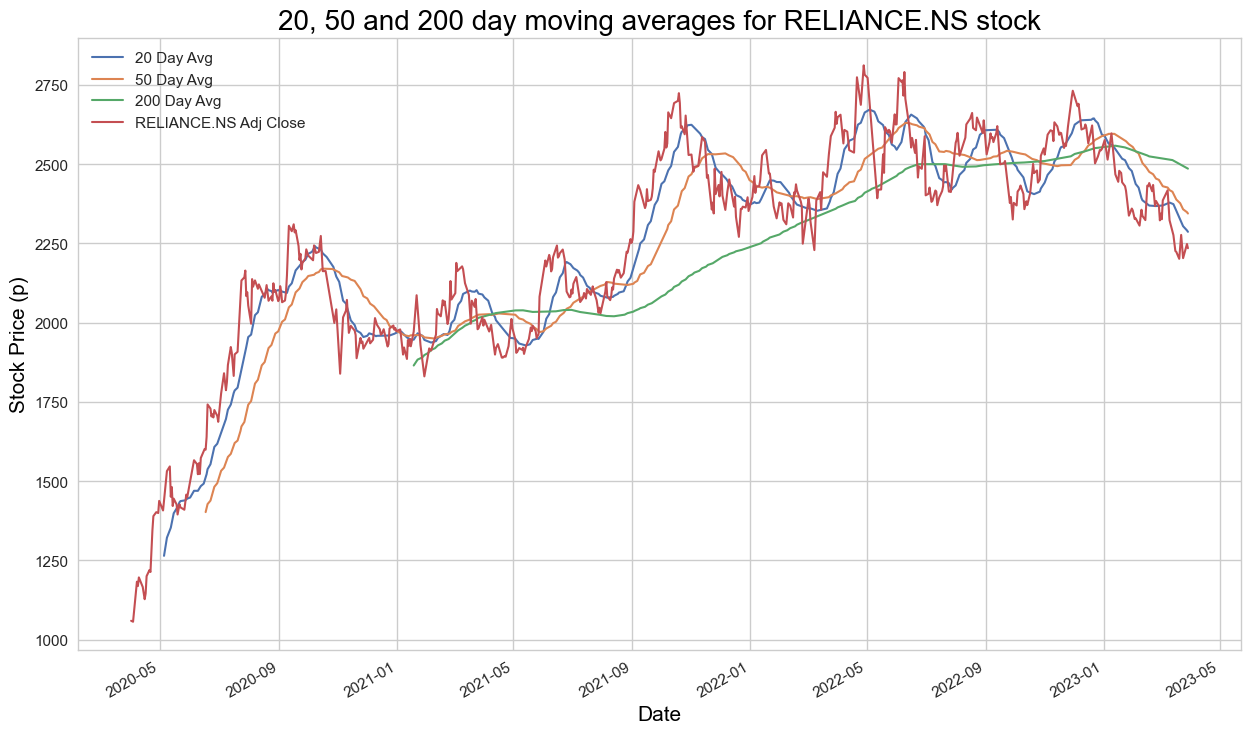

In [391]:
ticker = 'RELIANCE.NS'

title_txt = "20, 50 and 200 day moving averages for RELIANCE.NS stock"
label_txt = "RELIANCE.NS Adj Close"

sma2()

The chart shows that the 20-day moving average is the most sensitive to local changes, and the 200-day moving average the least. Here, the 200-day moving average indicates an overall bullish trend - the stock is trending upward over time. The 20- and 50-day moving averages are at times bearish and at other times bullish.

The major drawback of moving averages, however, is that because they are lagging, and smooth out prices, they tend to recognise reversals too late and are therefore not very helpful when used alone.

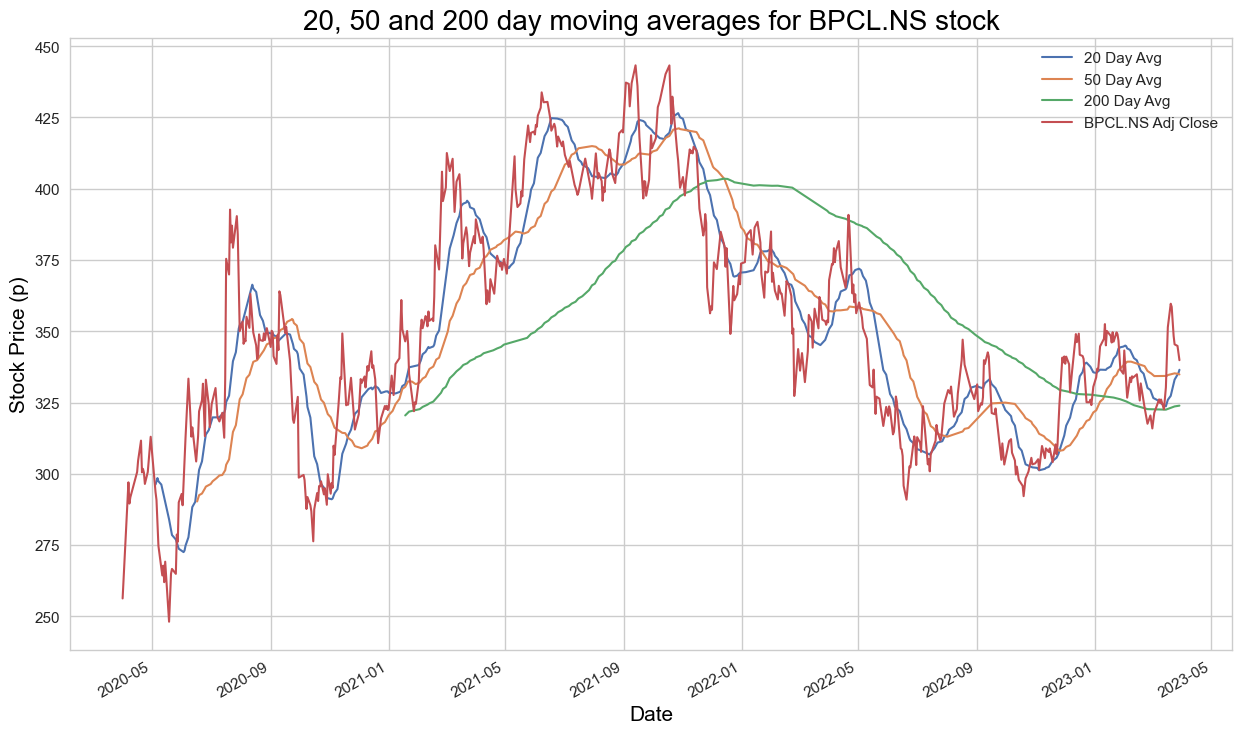

In [392]:
# 20, 50 and 200 day MA repeated for BPCL Adjusted Close price data for the same time period 

ticker = 'BPCL.NS'

title_txt = "20, 50 and 200 day moving averages for BPCL.NS stock"
label_txt = "BPCL.NS Adj Close"

sma2()

### Trading Strategy

The moving average crossover trading strategy will be to take two moving averages - 20-day (fast) and 200-day (slow) - and to go long (buy) when the fast MA goes above the slow MA and to go short (sell) when the fast MA goes below the slow MA.

In [393]:
# Create copy of dataframe for RELIANCEINDUSTRY data for 2013-2023


RELIANCEINDUSTRY_sma = RELIANCEINDUSTRY.copy()

In [394]:
RELIANCEINDUSTRY_sma

Open         High          Low        Close    Adj Close  \
Date                                                                          
2007-04-02   335.569153   336.510223   323.248413   325.403015   291.745697   
2007-04-03   327.025116   333.340271   324.300964   332.040100   297.696259   
2007-04-04   333.835571   339.023895   333.761261   337.612274   302.692047   
2007-04-05   337.550354   337.996124   334.875702   336.522614   301.715179   
2007-04-09   338.045654   343.741669   337.302704   342.825348   307.365936   
...                 ...          ...          ...          ...          ...   
2023-03-23  2268.000000  2269.899902  2243.050049  2247.800049  2247.800049   
2023-03-24  2245.250000  2250.000000  2198.000000  2203.300049  2203.300049   
2023-03-27  2217.500000  2254.000000  2200.199951  2237.550049  2237.550049   
2023-03-28  2245.000000  2256.500000  2237.000000  2248.000000  2248.000000   
2023-03-29  2239.000000  2244.800049  2211.100098  2234.699951  2234.699951   

              Volume  
Date                  
2007-04-02  13286092  
2007-04-03  10745415  
2007-04-04   8035662  
2007-04-05   4899877  
2007-04-09   4489883  
...              ...  
2023-03-23   7499082  
2023-03-24   5711497  
2023-03-27   6486068  
2023-03-28   5804018  
2023-03-29   8678073  

[3947 rows x 6 columns]

In [395]:
  # Calculate and add columns for moving averages of Adjusted Close price data
  
  RELIANCEINDUSTRY_sma["20d"] = np.round(RELIANCEINDUSTRY_sma["Adj Close"].rolling(window = 20, center = False).mean(), 2)
  RELIANCEINDUSTRY_sma["50d"] = np.round(RELIANCEINDUSTRY_sma["Adj Close"].rolling(window = 50, center = False).mean(), 2)
  RELIANCEINDUSTRY_sma["200d"] = np.round(RELIANCEINDUSTRY_sma["Adj Close"].rolling(window = 200, center = False).mean(), 2)

In [396]:
RELIANCEINDUSTRY_sma.tail()

Open         High          Low        Close    Adj Close  \
Date                                                                      
2023-03-23  2268.00  2269.899902  2243.050049  2247.800049  2247.800049   
2023-03-24  2245.25  2250.000000  2198.000000  2203.300049  2203.300049   
2023-03-27  2217.50  2254.000000  2200.199951  2237.550049  2237.550049   
2023-03-28  2245.00  2256.500000  2237.000000  2248.000000  2248.000000   
2023-03-29  2239.00  2244.800049  2211.100098  2234.699951  2234.699951   

             Volume      20d      50d     200d  
Date                                            
2023-03-23  7499082  2312.34  2363.86  2495.90  
2023-03-24  5711497  2304.13  2357.41  2493.09  
2023-03-27  6486068  2296.82  2352.72  2490.70  
2023-03-28  5804018  2290.83  2348.33  2487.99  
2023-03-29  8678073  2286.44  2344.14  2485.63

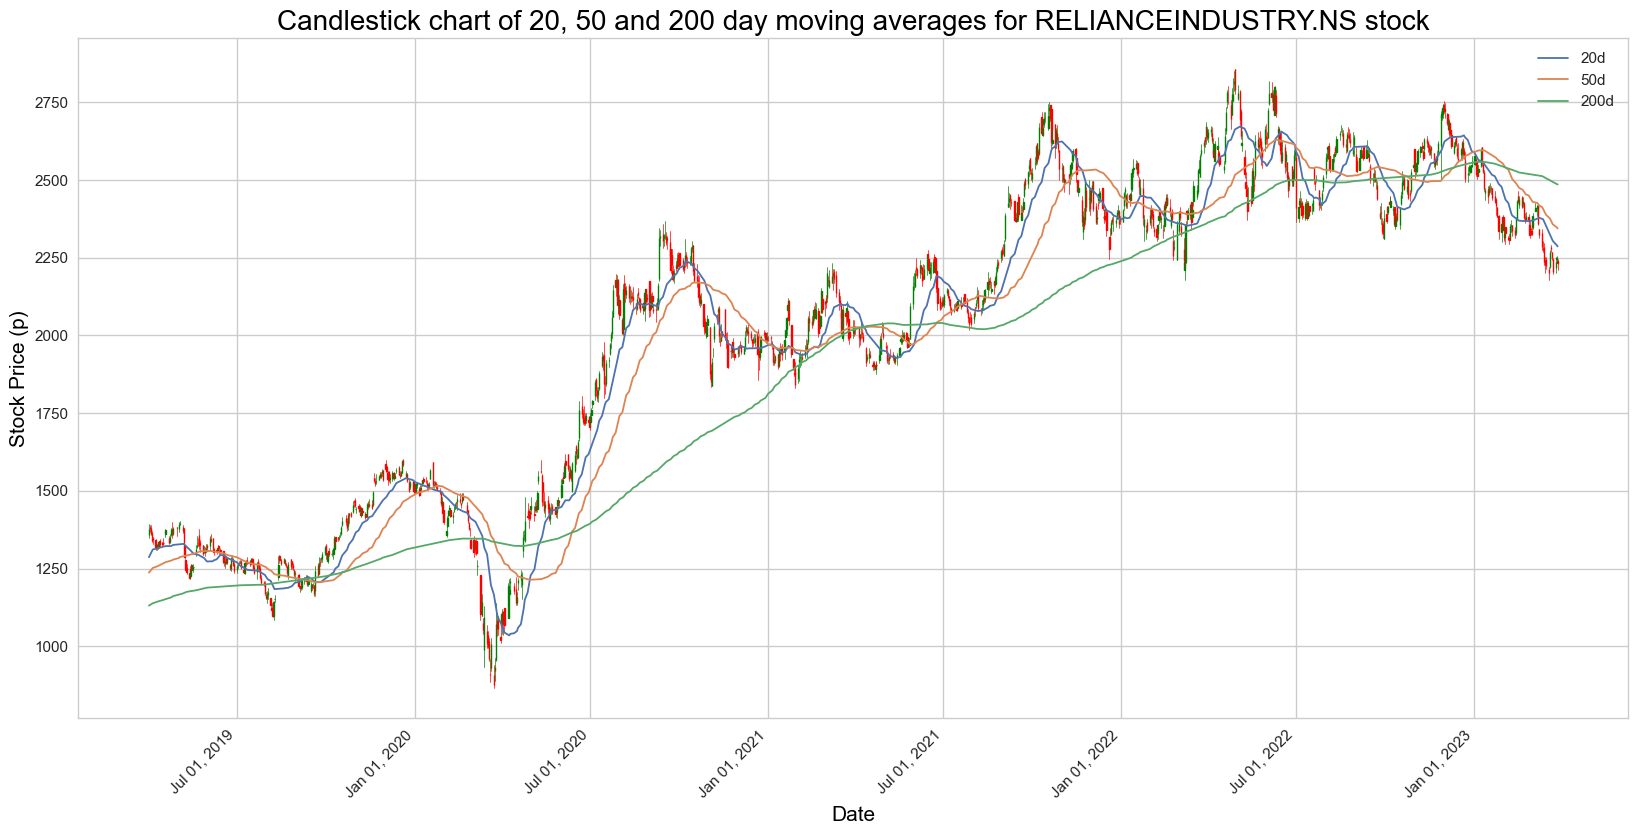

In [397]:
txt = "20, 50 and 200 day moving averages for RELIANCEINDUSTRY.NS stock"

# Slice rows to plot data from 2019-2023 
pandas_candlestick_ohlc(RELIANCEINDUSTRY_sma.loc['2019-04-01':'2023-03-31',:], otherseries = ["20d", "50d", "200d"])

### Backtesting

Before using the strategy we will evaluate the quality of it first by backtesting, or looking at how profitable it is on historical data.

In [398]:
# Identify when the 20-day average is below the 200-day average, and vice versa.
RELIANCEINDUSTRY_sma['20d-200d'] = RELIANCEINDUSTRY_sma['20d'] - RELIANCEINDUSTRY_sma['200d']
RELIANCEINDUSTRY_sma.tail()

Open         High          Low        Close    Adj Close  \
Date                                                                      
2023-03-23  2268.00  2269.899902  2243.050049  2247.800049  2247.800049   
2023-03-24  2245.25  2250.000000  2198.000000  2203.300049  2203.300049   
2023-03-27  2217.50  2254.000000  2200.199951  2237.550049  2237.550049   
2023-03-28  2245.00  2256.500000  2237.000000  2248.000000  2248.000000   
2023-03-29  2239.00  2244.800049  2211.100098  2234.699951  2234.699951   

             Volume      20d      50d     200d  20d-200d  
Date                                                      
2023-03-23  7499082  2312.34  2363.86  2495.90   -183.56  
2023-03-24  5711497  2304.13  2357.41  2493.09   -188.96  
2023-03-27  6486068  2296.82  2352.72  2490.70   -193.88  
2023-03-28  5804018  2290.83  2348.33  2487.99   -197.16  
2023-03-29  8678073  2286.44  2344.14  2485.63   -199.19

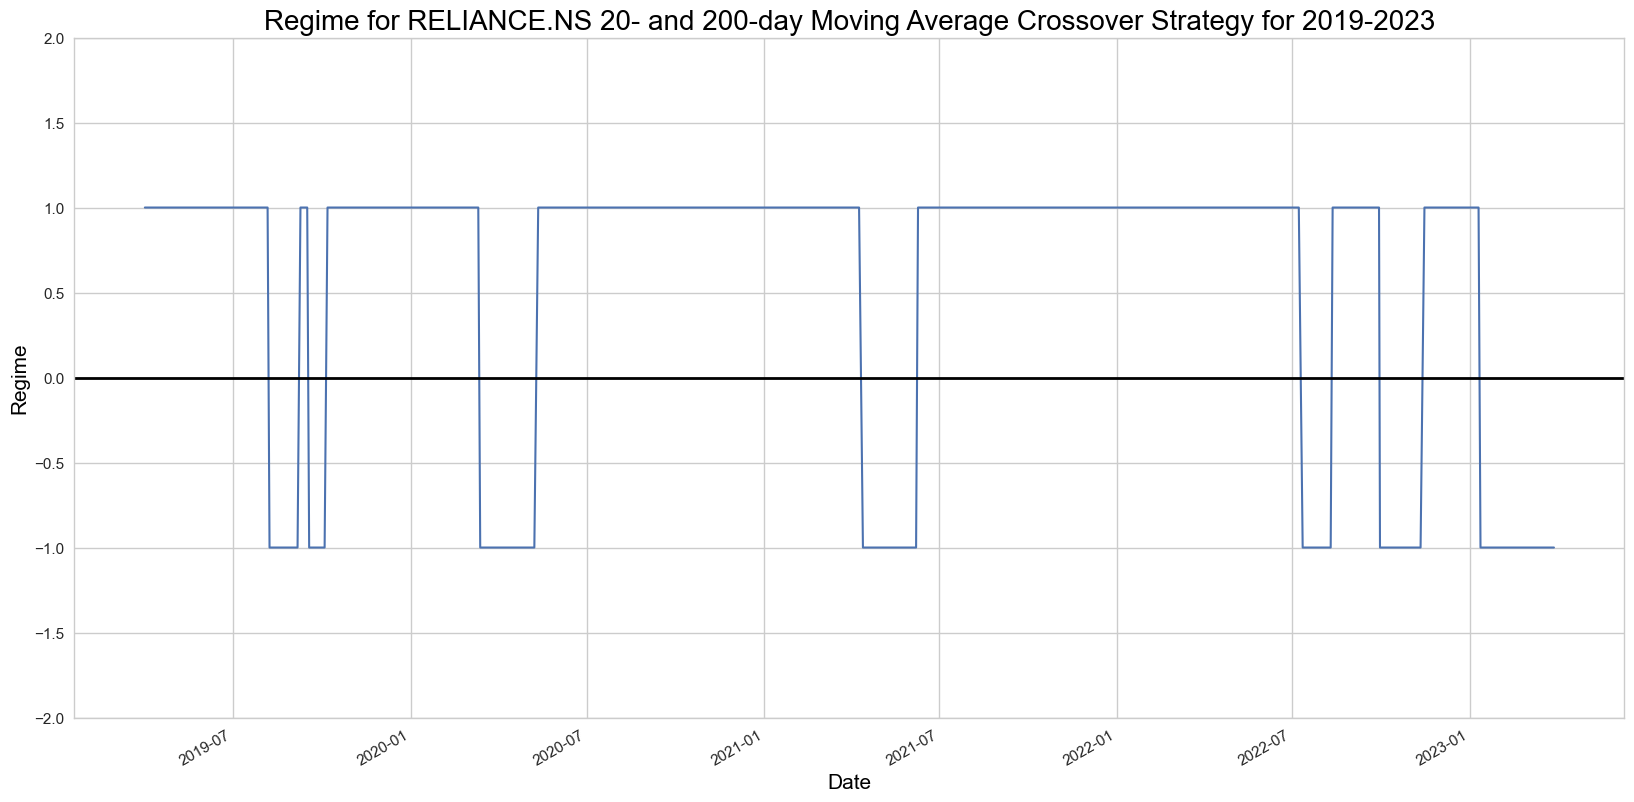

In [399]:
# The sign of this difference is the regime; that is, if the fast moving average is above the slow moving average, 
# this is a bullish regime, and a bearish regime holds when the fast moving average is below the slow moving average

# np.where() is a vectorized if-else function, where a condition is checked for each component of a vector, and the first argument passed is used when the condition holds, and the other passed if it does not
RELIANCEINDUSTRY_sma["Regime"] = np.where(RELIANCEINDUSTRY_sma['20d-200d'] > 0, 1, 0)
# We have 1's for bullish regimes and 0's for everything else. Replace bearish regime's values with -1, and to maintain the rest of the vector, the second argument is RELIANCEINDUSTRY_sma["Regime"]
RELIANCEINDUSTRY_sma["Regime"] = np.where(RELIANCEINDUSTRY_sma['20d-200d'] < 0, -1, RELIANCEINDUSTRY_sma["Regime"])
RELIANCEINDUSTRY_sma.loc['2019-04-01':'2023-03-31',"Regime"].plot(ylim = (-2,2)).axhline(y = 0, color = "black", lw = 2);
plt.title("Regime for RELIANCE.NS 20- and 200-day Moving Average Crossover Strategy for 2019-2023", color = 'black', fontsize = 20)
plt.xlabel('Date', color = 'black', fontsize = 15)
plt.ylabel('Regime', color = 'black', fontsize = 15);

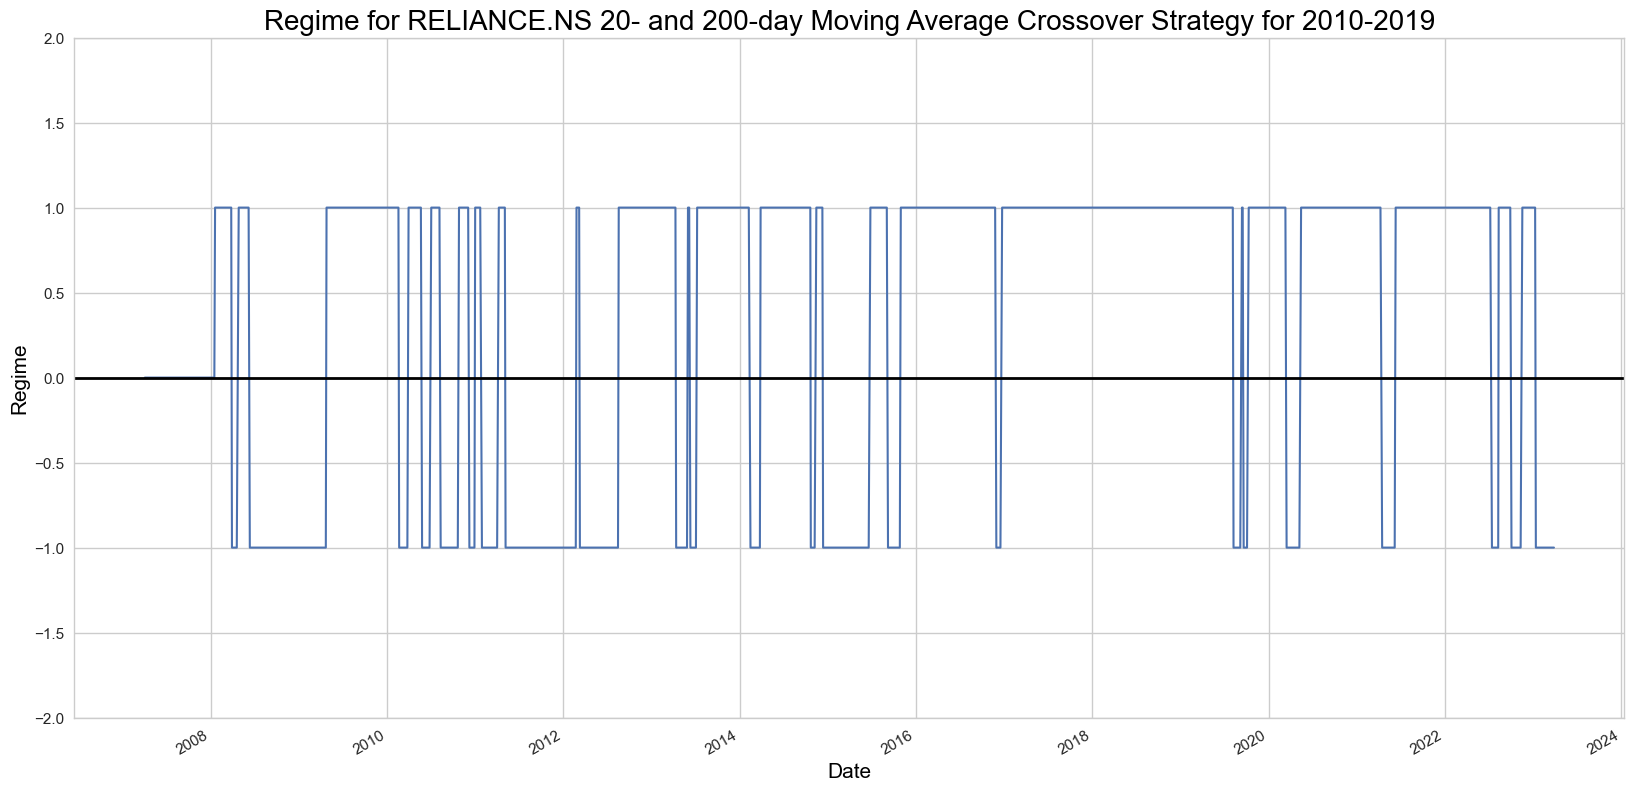

In [400]:
RELIANCEINDUSTRY_sma["Regime"].plot(ylim = (-2,2)).axhline(y = 0, color = "black", lw = 2);
plt.title("Regime for RELIANCE.NS 20- and 200-day Moving Average Crossover Strategy for 2010-2019", color = 'black', fontsize = 20)
plt.xlabel('Date', color = 'black', fontsize = 15)
plt.ylabel('Regime', color = 'black', fontsize = 15);

In [401]:
# Number of bullish and bearish days
RELIANCEINDUSTRY_sma["Regime"].value_counts()

 1    2561
-1    1187
 0     199
Name: Regime, dtype: int64

For 2561 days the market was bullish, for 1187 days it was bearish, and neutral for 199 days for the time period 2013-2023.

In [402]:
RELIANCEINDUSTRY_sma

Open         High          Low        Close    Adj Close  \
Date                                                                          
2007-04-02   335.569153   336.510223   323.248413   325.403015   291.745697   
2007-04-03   327.025116   333.340271   324.300964   332.040100   297.696259   
2007-04-04   333.835571   339.023895   333.761261   337.612274   302.692047   
2007-04-05   337.550354   337.996124   334.875702   336.522614   301.715179   
2007-04-09   338.045654   343.741669   337.302704   342.825348   307.365936   
...                 ...          ...          ...          ...          ...   
2023-03-23  2268.000000  2269.899902  2243.050049  2247.800049  2247.800049   
2023-03-24  2245.250000  2250.000000  2198.000000  2203.300049  2203.300049   
2023-03-27  2217.500000  2254.000000  2200.199951  2237.550049  2237.550049   
2023-03-28  2245.000000  2256.500000  2237.000000  2248.000000  2248.000000   
2023-03-29  2239.000000  2244.800049  2211.100098  2234.699951  2234.699951   

              Volume      20d      50d     200d  20d-200d  Regime  
Date                                                               
2007-04-02  13286092      NaN      NaN      NaN       NaN       0  
2007-04-03  10745415      NaN      NaN      NaN       NaN       0  
2007-04-04   8035662      NaN      NaN      NaN       NaN       0  
2007-04-05   4899877      NaN      NaN      NaN       NaN       0  
2007-04-09   4489883      NaN      NaN      NaN       NaN       0  
...              ...      ...      ...      ...       ...     ...  
2023-03-23   7499082  2312.34  2363.86  2495.90   -183.56      -1  
2023-03-24   5711497  2304.13  2357.41  2493.09   -188.96      -1  
2023-03-27   6486068  2296.82  2352.72  2490.70   -193.88      -1  
2023-03-28   5804018  2290.83  2348.33  2487.99   -197.16      -1  
2023-03-29   8678073  2286.44  2344.14  2485.63   -199.19      -1  

[3947 rows x 11 columns]

In [403]:
# Obtain signals with -1 indicating “sell”, 1 indicating “buy”, and 0 no action
# To ensure that all trades close out, temporarily change the regime of the last row to 0
regime_orig = RELIANCEINDUSTRY_sma.iloc[-1, 10]
RELIANCEINDUSTRY_sma.iloc[0, 10] = 0
RELIANCEINDUSTRY_sma["Signal"] = np.sign(RELIANCEINDUSTRY_sma["Regime"] - RELIANCEINDUSTRY_sma["Regime"].shift(1))
# Restore original regime data
RELIANCEINDUSTRY_sma.iloc[-1, 10] = regime_orig
RELIANCEINDUSTRY_sma.tail()

Open         High          Low        Close    Adj Close  \
Date                                                                      
2023-03-23  2268.00  2269.899902  2243.050049  2247.800049  2247.800049   
2023-03-24  2245.25  2250.000000  2198.000000  2203.300049  2203.300049   
2023-03-27  2217.50  2254.000000  2200.199951  2237.550049  2237.550049   
2023-03-28  2245.00  2256.500000  2237.000000  2248.000000  2248.000000   
2023-03-29  2239.00  2244.800049  2211.100098  2234.699951  2234.699951   

             Volume      20d      50d     200d  20d-200d  Regime  Signal  
Date                                                                      
2023-03-23  7499082  2312.34  2363.86  2495.90   -183.56      -1     0.0  
2023-03-24  5711497  2304.13  2357.41  2493.09   -188.96      -1     0.0  
2023-03-27  6486068  2296.82  2352.72  2490.70   -193.88      -1     0.0  
2023-03-28  5804018  2290.83  2348.33  2487.99   -197.16      -1     0.0  
2023-03-29  8678073  2286.44  2344.14  2485.63   -199.19      -1     0.0

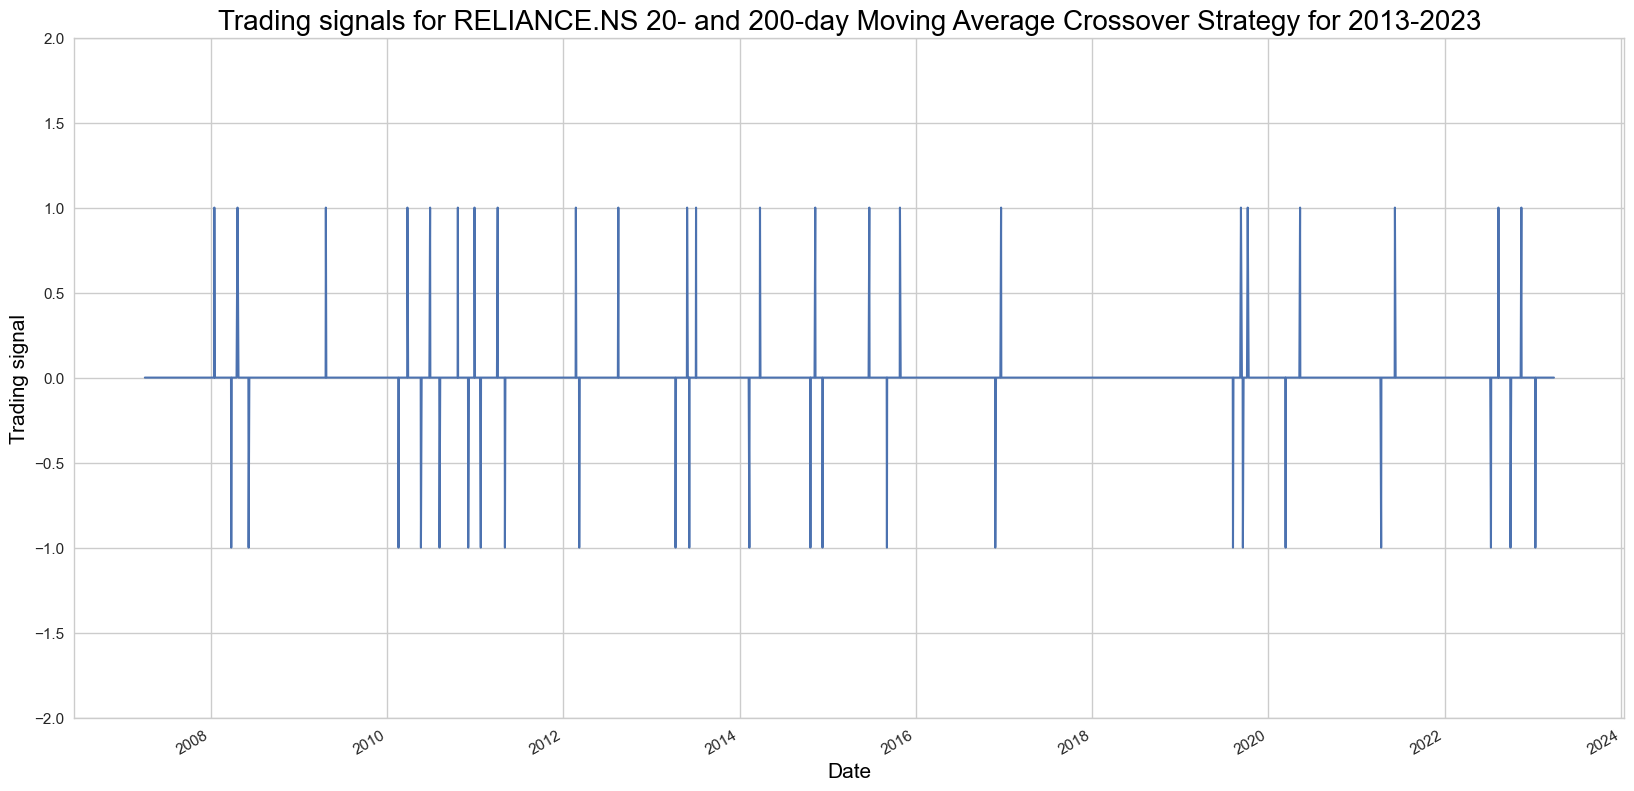

In [404]:
RELIANCEINDUSTRY_sma["Signal"].plot(ylim = (-2, 2));
plt.title("Trading signals for RELIANCE.NS 20- and 200-day Moving Average Crossover Strategy for 2013-2023", color = 'black', fontsize = 20)
plt.xlabel('Date', color = 'black', fontsize = 15)
plt.ylabel('Trading signal', color = 'black', fontsize = 15);

In [405]:
# Unique counts of trading signals
RELIANCEINDUSTRY_sma["Signal"].value_counts()

 0.0    3900
 1.0      23
-1.0      23
Name: Signal, dtype: int64

We would buy RELIANCEINDUSTRY stock 23 times and sell 23 times. If we only go long 23 trades will be engaged in over the 10-year period, while if we pivot from a long to a short position every time a long position is terminated, we would engage in 23 trades total. It is worth bearing in mind that trading more frequently isn’t necessarily good as trades are never free.

In [406]:
# Identify what the price of the stock is at every buy.

RELIANCEINDUSTRY_sma.loc[RELIANCEINDUSTRY_sma["Signal"] == 1, "Close"]

Date
2008-01-16     766.150146
2008-04-21     654.694153
2009-04-22     425.467010
2010-03-26     545.058411
2010-06-28     539.956726
2010-10-21     535.746643
2010-12-29     519.376831
2011-04-04     520.392212
2012-02-22     412.787201
2012-08-16     404.243164
2013-05-28     417.740234
2013-07-04     426.779541
2014-03-26     441.415833
2014-11-10     480.123901
2015-06-22     491.193970
2015-10-27     465.363831
2016-12-19     526.286316
2019-09-09    1210.723511
2019-10-07    1297.798218
2020-05-11    1561.993896
2021-06-08    2214.600098
2022-08-11    2591.100098
2022-11-14    2619.050049
Name: Close, dtype: float64

In [407]:
# Identify what the price of the stock is at every sell.

RELIANCEINDUSTRY_sma.loc[RELIANCEINDUSTRY_sma["Signal"] == -1, "Close"]

Date
2008-03-26     569.464539
2008-06-06     554.370117
2010-02-17     511.427185
2010-05-21     493.100891
2010-08-06     495.354523
2010-12-03     498.227295
2011-01-24     481.238342
2011-05-04     469.375793
2012-03-07     377.323364
2013-04-10     386.040710
2013-06-06     392.281555
2014-02-10     407.115936
2014-10-21     460.311707
2014-12-10     461.896667
2015-09-03     422.916168
2016-11-25     492.184570
2019-08-07    1098.982788
2019-09-17    1186.205933
2020-03-12    1053.018433
2021-04-12    1911.150024
2022-07-11    2423.899902
2022-09-30    2377.750000
2023-01-11    2526.149902
Name: Close, dtype: float64

In [408]:
# Create a dataframe with trades, including the price at the trade and the regime under which the trade is made.

RELIANCEINDUSTRY_signals = pd.concat([
        pd.DataFrame({"Price": RELIANCEINDUSTRY_sma.loc[RELIANCEINDUSTRY_sma["Signal"] == 1, "Adj Close"],
                     "Regime": RELIANCEINDUSTRY_sma.loc[RELIANCEINDUSTRY_sma["Signal"] == 1, "Regime"],
                     "Signal": "Buy"}),
        pd.DataFrame({"Price": RELIANCEINDUSTRY_sma.loc[RELIANCEINDUSTRY_sma["Signal"] == -1, "Adj Close"],
                     "Regime": RELIANCEINDUSTRY_sma.loc[RELIANCEINDUSTRY_sma["Signal"] == -1, "Regime"],
                     "Signal": "Sell"}),
    ])
RELIANCEINDUSTRY_signals.sort_index(inplace = True)
RELIANCEINDUSTRY_signals

Price  Regime Signal
Date                                  
2008-01-16   686.905090       1    Buy
2008-03-26   510.563171      -1   Sell
2008-04-21   586.977234       1    Buy
2008-06-06   499.444733      -1   Sell
2009-04-22   383.312927       1    Buy
2010-02-17   463.531403      -1   Sell
2010-03-26   494.013000       1    Buy
2010-05-21   449.971191      -1   Sell
2010-06-28   492.728729       1    Buy
2010-08-06   452.027649      -1   Sell
2010-10-21   488.886841       1    Buy
2010-12-03   454.649231      -1   Sell
2010-12-29   473.948822       1    Buy
2011-01-24   439.146179      -1   Sell
2011-04-04   474.875427       1    Buy
2011-05-04   428.321136      -1   Sell
2012-02-22   379.889252       1    Buy
2012-03-07   347.251740      -1   Sell
2012-08-16   376.558167       1    Buy
2013-04-10   359.602264      -1   Sell
2013-05-28   393.459381       1    Buy
2013-06-06   369.480438      -1   Sell
2013-07-04   401.973236       1    Buy
2014-02-10   383.452545      -1   Sell
2014-03-26   415.758850       1    Buy
2014-10-21   437.501984      -1   Sell
2014-11-10   456.332428       1    Buy
2014-12-10   439.008392      -1   Sell
2015-06-22   472.277710       1    Buy
2015-09-03   406.629333      -1   Sell
2015-10-27   447.442322       1    Buy
2016-11-25   478.143768      -1   Sell
2016-12-19   511.272644       1    Buy
2019-08-07  1088.084961      -1   Sell
2019-09-09  1198.717651       1    Buy
2019-09-17  1174.443237      -1   Sell
2019-10-07  1284.928955       1    Buy
2020-03-12  1042.576416      -1   Sell
2020-05-11  1546.504639       1    Buy
2021-04-12  1899.303467      -1   Sell
2021-06-08  2200.872559       1    Buy
2022-07-11  2416.624023      -1   Sell
2022-08-11  2583.322510       1    Buy
2022-09-30  2377.750000      -1   Sell
2022-11-14  2619.050049       1    Buy
2023-01-11  2526.149902      -1   Sell

In [409]:
# Let's see the profitability of long trades

RELIANCEINDUSTRY_long_profits = pd.DataFrame({
        "Price": RELIANCEINDUSTRY_signals.loc[(RELIANCEINDUSTRY_signals["Signal"] == "Buy") &
                                  RELIANCEINDUSTRY_signals["Regime"] == 1, "Price"],
        "Profit": pd.Series(RELIANCEINDUSTRY_signals["Price"] - RELIANCEINDUSTRY_signals["Price"].shift(1)).loc[
            RELIANCEINDUSTRY_signals.loc[(RELIANCEINDUSTRY_signals["Signal"].shift(1) == "Buy") & (RELIANCEINDUSTRY_signals["Regime"].shift(1) == 1)].index
        ].tolist(),
        "End Date": RELIANCEINDUSTRY_signals["Price"].loc[
            RELIANCEINDUSTRY_signals.loc[(RELIANCEINDUSTRY_signals["Signal"].shift(1) == "Buy") & (RELIANCEINDUSTRY_signals["Regime"].shift(1) == 1)].index
        ].index
    })
RELIANCEINDUSTRY_long_profits

Price      Profit   End Date
Date                                          
2008-01-16   686.905090 -176.341919 2008-03-26
2008-04-21   586.977234  -87.532501 2008-06-06
2009-04-22   383.312927   80.218475 2010-02-17
2010-03-26   494.013000  -44.041809 2010-05-21
2010-06-28   492.728729  -40.701080 2010-08-06
2010-10-21   488.886841  -34.237610 2010-12-03
2010-12-29   473.948822  -34.802643 2011-01-24
2011-04-04   474.875427  -46.554291 2011-05-04
2012-02-22   379.889252  -32.637512 2012-03-07
2012-08-16   376.558167  -16.955902 2013-04-10
2013-05-28   393.459381  -23.978943 2013-06-06
2013-07-04   401.973236  -18.520691 2014-02-10
2014-03-26   415.758850   21.743134 2014-10-21
2014-11-10   456.332428  -17.324036 2014-12-10
2015-06-22   472.277710  -65.648376 2015-09-03
2015-10-27   447.442322   30.701447 2016-11-25
2016-12-19   511.272644  576.812317 2019-08-07
2019-09-09  1198.717651  -24.274414 2019-09-17
2019-10-07  1284.928955 -242.352539 2020-03-12
2020-05-11  1546.504639  352.798828 2021-04-12
2021-06-08  2200.872559  215.751465 2022-07-11
2022-08-11  2583.322510 -205.572510 2022-09-30
2022-11-14  2619.050049  -92.900146 2023-01-11

### 5.1.4 Exponential Moving Average

In a Simple Moving Average, each value in the time period carries
equal weight, and values outside of the time period are not included in the average. However, the Exponential Moving Average is a cumulative calculation where a different decreasing weight is assigned to each observation. Past values have a diminishing contribution to the average, while more recent values have a greater contribution. This method allows the moving average to be more responsive to changes in the data.

In [410]:
# 20-day EMA for Adjusted Close price for April 2022 to March 2023

def ewma():
  plt.figure(figsize=(15,9))
  nifty_stocks[ticker]['Adj Close'].loc['2022-04-01':'2023-03-31'].ewm(20).mean().plot(label='20 Day Avg')
  nifty_stocks[ticker]['Adj Close'].loc['2022-04-01':'2023-03-31'].plot(label=f"{label_txt}")
  plt.title(f"{title_txt}", color = 'black', fontsize = 20)
  plt.xlabel('Date', color = 'black', fontsize = 15)
  plt.ylabel('Stock Price (p)', color = 'black', fontsize = 15);
  plt.legend()

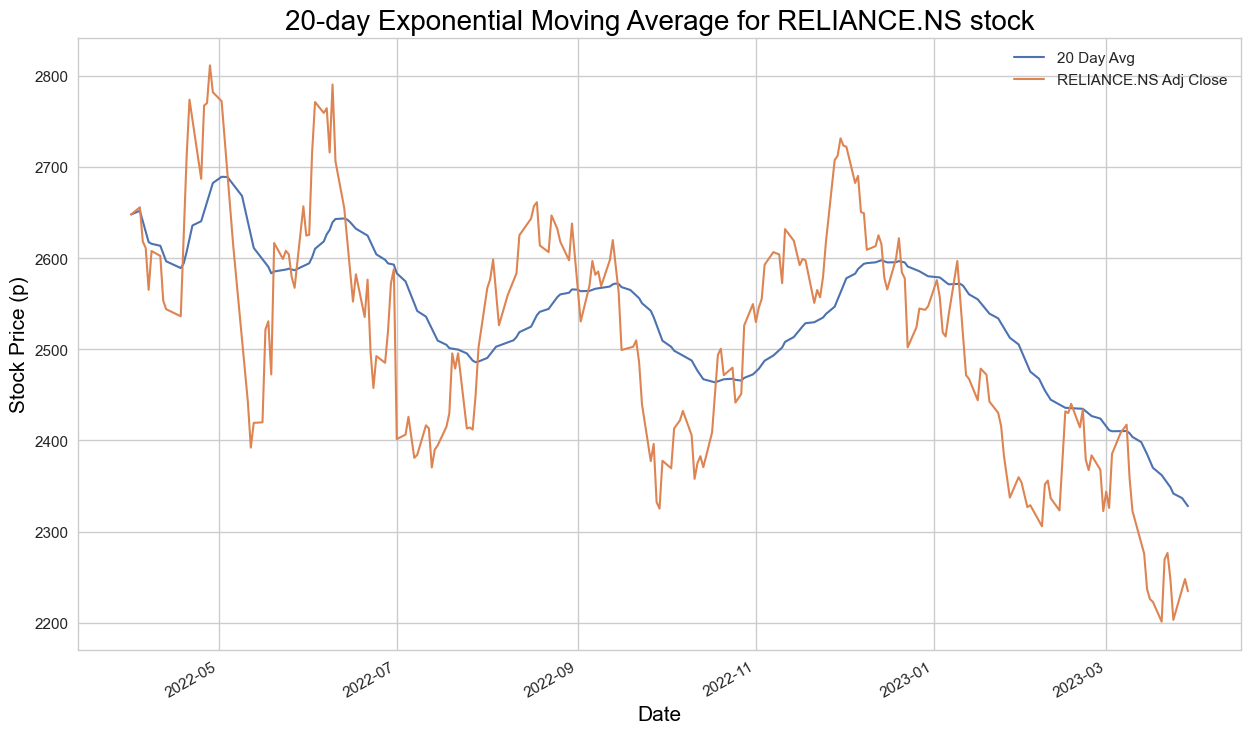

In [411]:
ticker = 'RELIANCE.NS'
title_txt = "20-day Exponential Moving Average for RELIANCE.NS stock"
label_txt = "RELIANCE.NS Adj Close"

ewma()

In [412]:
# 20-, 50- and 200-day EMA for Adjusted Close price for 2019-2023

def ewma2():
  plt.figure(figsize=(15,9))
  nifty_stocks[ticker]['Adj Close'].loc['2019-04-01':'2023-03-31'].ewm(20).mean().plot(label='20 Day Avg')
  nifty_stocks[ticker]['Adj Close'].loc['2019-04-01':'2023-03-31'].ewm(50).mean().plot(label='50 Day Avg')
  nifty_stocks[ticker]['Adj Close'].loc['2019-04-01':'2023-03-31'].ewm(200).mean().plot(label='200 Day Avg')
  nifty_stocks[ticker]['Adj Close'].loc['2019-04-01':'2023-03-31'].plot(label=f"{label_txt}")
  plt.title(f"{title_txt}", color = 'black', fontsize = 20)
  plt.xlabel('Date', color = 'black', fontsize = 15)
  plt.ylabel('Stock Price (p)', color = 'black', fontsize = 15);
  plt.legend()

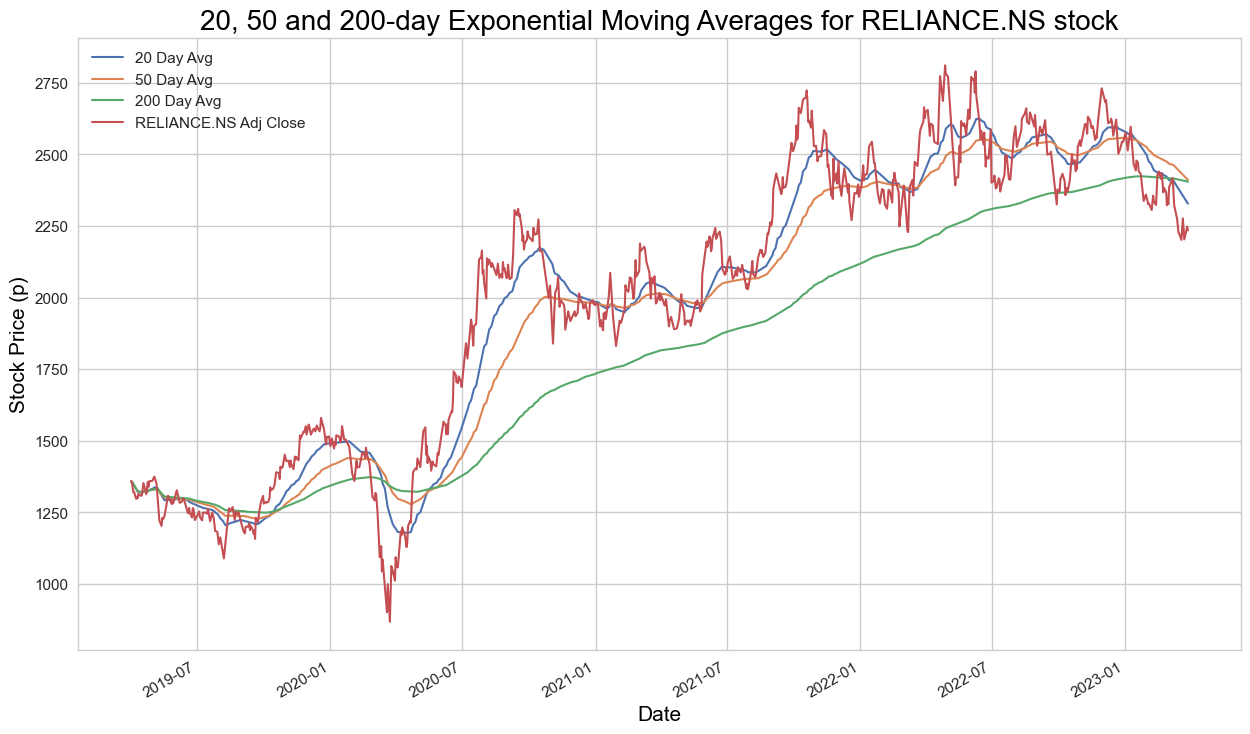

In [413]:
ticker = 'RELIANCE.NS'
title_txt = "20, 50 and 200-day Exponential Moving Averages for RELIANCE.NS stock"
label_txt = "RELIANCE.NS Adj Close"

ewma2()

### 5.1.5 Triple Moving Average Crossover Strategy

This strategy uses three moving moving averages - short/fast, middle/medium and long/slow - and has two buy and sell signals. 

The first is to buy when the middle/medium moving average crosses above the long/slow moving average and the short/fast moving average crosses above the middle/medium moving average. If we use this buy signal the strategy is to sell if the short/fast moving average crosses below the middle/medium moving average.

The second is to buy when the middle/medium moving average crosses below the long/slow moving average and the short/fast moving average crosses below the middle/medium moving average. If we use this buy signal the strategy is to sell if the short/fast moving average crosses above the middle/medium moving average.

In [414]:
RELIANCEINDUSTRY[['Adj Close']]['2019-04-01':'2023-03-31']

Adj Close
Date                   
2019-04-01  1357.590210
2019-04-02  1355.493042
2019-04-03  1341.349854
2019-04-04  1319.745239
2019-04-05  1320.574341
...                 ...
2023-03-23  2247.800049
2023-03-24  2203.300049
2023-03-27  2237.550049
2023-03-28  2248.000000
2023-03-29  2234.699951

[991 rows x 1 columns]

In [415]:
def adj_6mo():
  sns.set(rc={'figure.figsize':(15, 9)})
  nifty_stocks[ticker]['Adj Close'].loc['2022-04-01':'2023-09-30'].plot(label=f"{label_txt}")
  plt.title(f"{title_txt}", color = 'black', fontsize = 20)
  plt.xlabel('Date', color = 'black', fontsize = 15)
  plt.ylabel('Stock Price (p)', color = 'black', fontsize = 15);
  plt.legend()

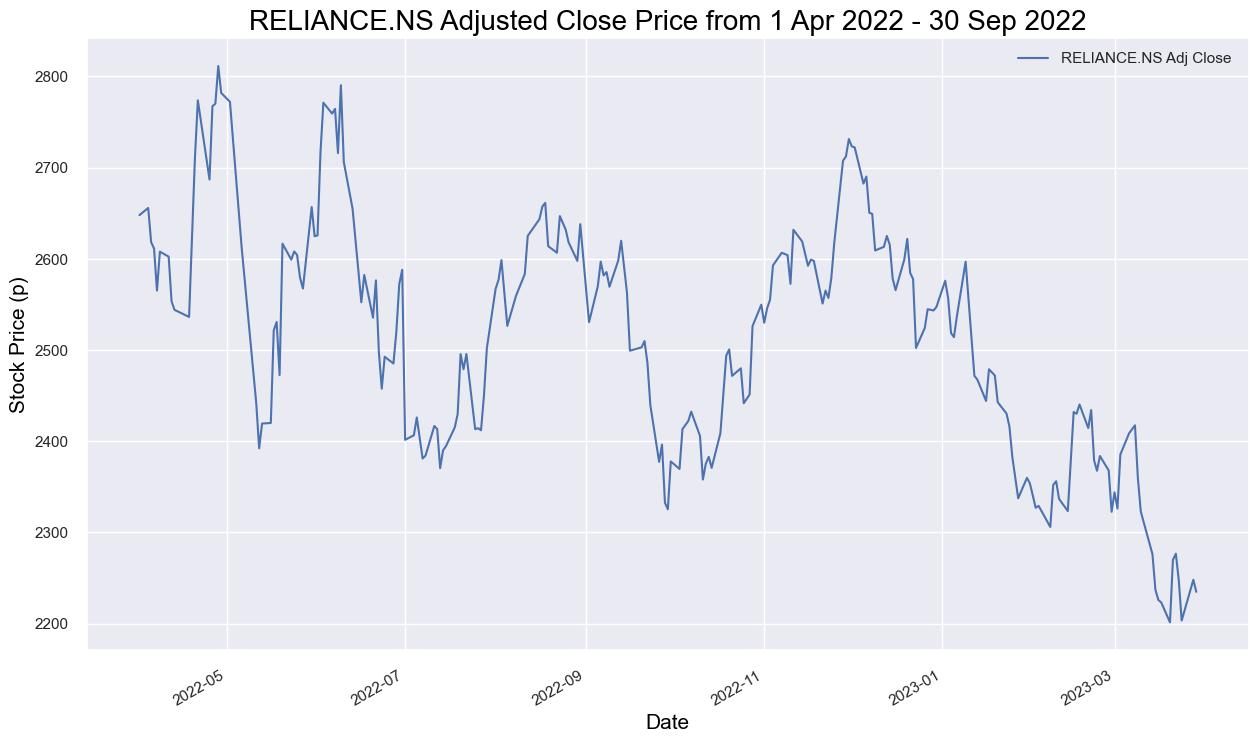

In [416]:
ticker = 'RELIANCE.NS'
title_txt = "RELIANCE.NS Adjusted Close Price from 1 Apr 2022 - 30 Sep 2022"
label_txt = "RELIANCE.NS Adj Close "

adj_6mo()

In [417]:
RELIANCEINDUSTRY_adj_6mo = RELIANCEINDUSTRY[['Adj Close']]['2022-04-01':'2022-09-30']

In [418]:
ShortEMA = RELIANCEINDUSTRY_adj_6mo['Adj Close'].ewm(span=5, adjust=False).mean()
MiddleEMA = RELIANCEINDUSTRY_adj_6mo['Adj Close'].ewm(span=21, adjust=False).mean()
LongEMA = RELIANCEINDUSTRY_adj_6mo['Adj Close'].ewm(span=63, adjust=False).mean()

In [419]:
def ewma3():
  sns.set(rc={'figure.figsize':(15, 9)})
  plt.plot(nifty_stocks[ticker]['Adj Close'].loc['2022-04-01':'2022-09-30'], label=f"{label_txt}", color = 'blue')
  plt.plot(ShortEMA, label = 'Short/Fast EMA', color = 'red')
  plt.plot(MiddleEMA, label = 'Middle/Medium EMA', color = 'orange')
  plt.plot(LongEMA, label = 'Long/Slow EMA', color = 'green')
  plt.title(f"{title_txt}", color = 'black', fontsize = 20)
  plt.xlabel('Date', color = 'black', fontsize = 15)
  plt.ylabel('Stock Price (p)', color = 'black', fontsize = 15);
  plt.legend()

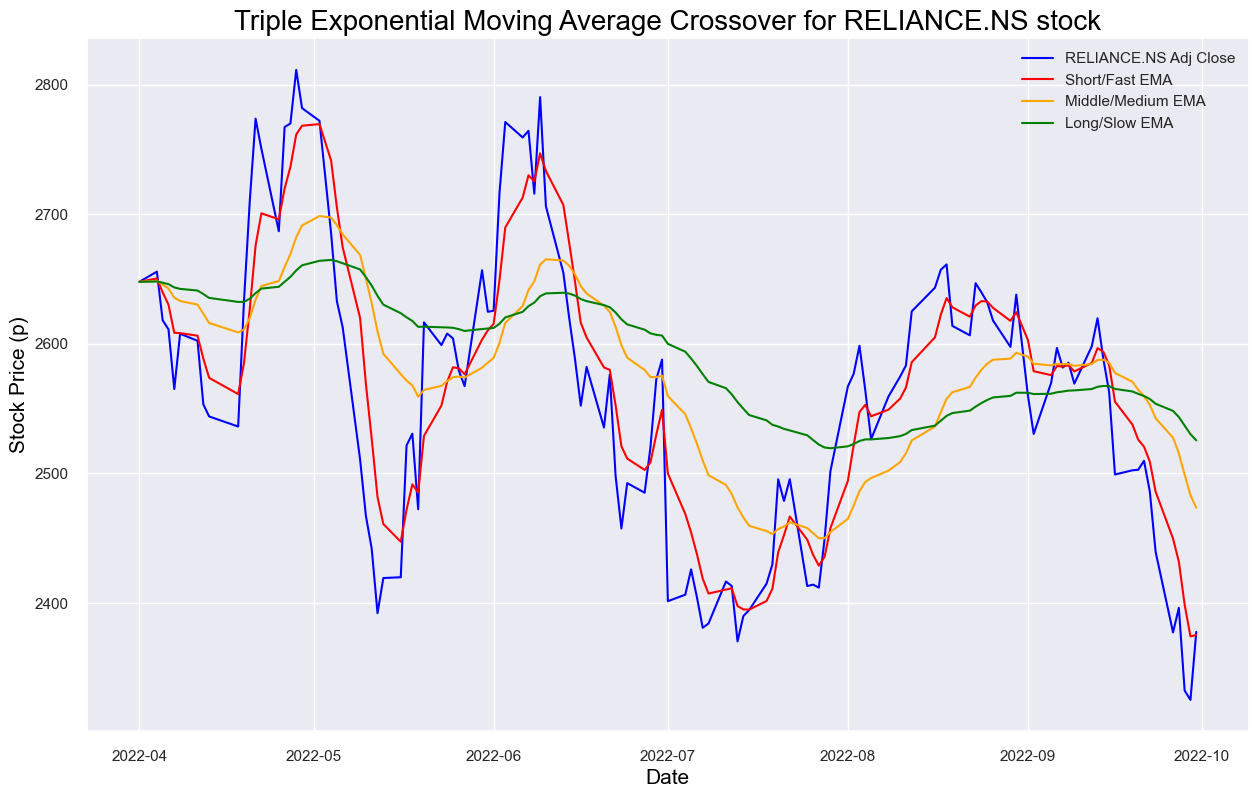

In [420]:
ticker = 'RELIANCE.NS'
title_txt = "Triple Exponential Moving Average Crossover for RELIANCE.NS stock"
label_txt = "RELIANCE.NS Adj Close"

ewma3()

In [421]:
RELIANCEINDUSTRY_adj_6mo['Short'] = ShortEMA
RELIANCEINDUSTRY_adj_6mo['Middle'] = MiddleEMA
RELIANCEINDUSTRY_adj_6mo['Long'] = LongEMA

In [422]:
RELIANCEINDUSTRY_adj_6mo

Adj Close        Short       Middle         Long
Date                                                          
2022-04-01  2647.878174  2647.878174  2647.878174  2647.878174
2022-04-04  2655.704346  2650.486898  2648.589644  2648.122742
2022-04-05  2618.167480  2639.713759  2645.823993  2647.186640
2022-04-06  2611.188477  2630.205331  2642.675309  2646.061697
2022-04-07  2565.127197  2608.512620  2635.625481  2643.532494
...                 ...          ...          ...          ...
2022-09-26  2377.350098  2449.735524  2527.579144  2548.276600
2022-09-27  2396.250000  2431.907016  2515.640131  2543.525768
2022-09-28  2332.449951  2398.754661  2498.986478  2536.929649
2022-09-29  2325.300049  2374.269790  2483.196803  2530.316224
2022-09-30  2377.750000  2375.429860  2473.610730  2525.548530

[125 rows x 4 columns]

In [423]:
def buy_sell_ewma3(data):
  
  buy_list = []
  sell_list = []
  flag_long = False
  flag_short = False

  for i in range(0, len(data)):
    if data['Middle'][i] < data['Long'][i] and data['Short'][i] < data['Middle'][i] and flag_long == False and flag_short == False:
      buy_list.append(data['Adj Close'][i])
      sell_list.append(np.nan)
      flag_short = True
    elif flag_short == True and data['Short'][i] > data['Middle'][i]:
      sell_list.append(data['Adj Close'][i])
      buy_list.append(np.nan)
      flag_short = False
    elif data['Middle'][i] > data['Long'][i] and data['Short'][i] > data['Middle'][i] and flag_long == False and flag_short == False:
      buy_list.append(data['Adj Close'][i])
      sell_list.append(np.nan)
      flag_long = True
    elif flag_long == True and data['Short'][i] < data['Middle'][i]:
      sell_list.append(data['Adj Close'][i])
      buy_list.append(np.nan)
      flag_long = False
    else:
      buy_list.append(np.nan)
      sell_list.append(np.nan)
  
  return (buy_list, sell_list)

In [424]:
RELIANCEINDUSTRY_adj_6mo['Buy'] = buy_sell_ewma3(RELIANCEINDUSTRY_adj_6mo)[0]
RELIANCEINDUSTRY_adj_6mo['Sell'] = buy_sell_ewma3(RELIANCEINDUSTRY_adj_6mo)[1]

In [425]:
def buy_sell_ewma3_plot():
  sns.set(rc={'figure.figsize':(18, 10)})
  plt.plot(nifty_stocks[ticker]['Adj Close'].loc['2019-04-01':'2023-03-31'], label=f"{label_txt}", color = 'blue', alpha = 0.35)
  plt.plot(ShortEMA, label = 'Short/Fast EMA', color = 'red', alpha = 0.35)
  plt.plot(MiddleEMA, label = 'Middle/Medium EMA', color = 'orange', alpha = 0.35)
  plt.plot(LongEMA, label = 'Long/Slow EMA', color = 'green', alpha = 0.35)
  plt.scatter(RELIANCEINDUSTRY_adj_6mo.index, RELIANCEINDUSTRY_adj_6mo['Buy'], color = 'green', label = 'Buy Signal', marker = '^', alpha = 1)
  plt.scatter(RELIANCEINDUSTRY_adj_6mo.index, RELIANCEINDUSTRY_adj_6mo['Sell'], color = 'red', label = 'Buy Signal', marker='v', alpha = 1)
  plt.title(f"{title_txt}", color = 'black', fontsize = 20)
  plt.xlabel('Date', color = 'black', fontsize = 15)
  plt.ylabel('Stock Price (p)', color = 'black', fontsize = 15);
  plt.legend()

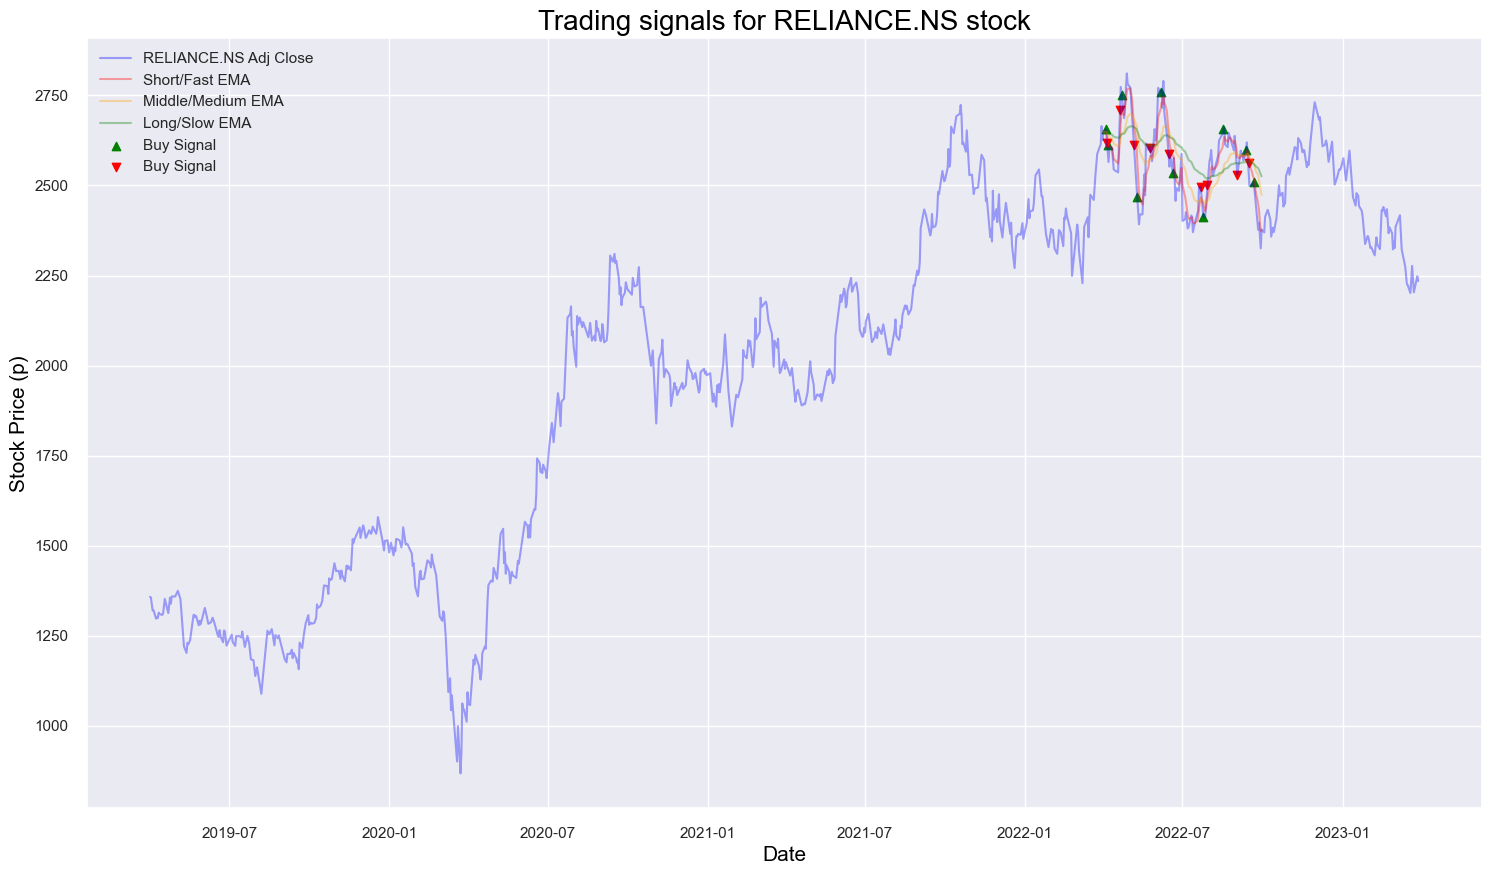

In [426]:
ticker = 'RELIANCE.NS'
title_txt = "Trading signals for RELIANCE.NS stock"
label_txt = "RELIANCE.NS Adj Close"

buy_sell_ewma3_plot()

### 5.1.6 Exponential Smoothing

Single Exponential Smoothing, also known as Simple Exponential Smoothing, is a time series forecasting method for univariate data without a trend or seasonality. It requires an alpha parameter, also called the smoothing factor or smoothing coefficient, to control the rate at which the influence of the observations at prior time steps decay exponentially.

In [427]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

def plot_exponential_smoothing(series, alphas):
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label=f"Alpha {alpha}")
    plt.plot(series.values, "c", label = f"{label_txt}")
    plt.xlabel('Days', color = 'black', fontsize = 15)
    plt.ylabel('Stock Price (p)', color = 'black', fontsize = 15);
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title(f"{title_txt}", color = 'black', fontsize = 20)
    plt.grid(True);

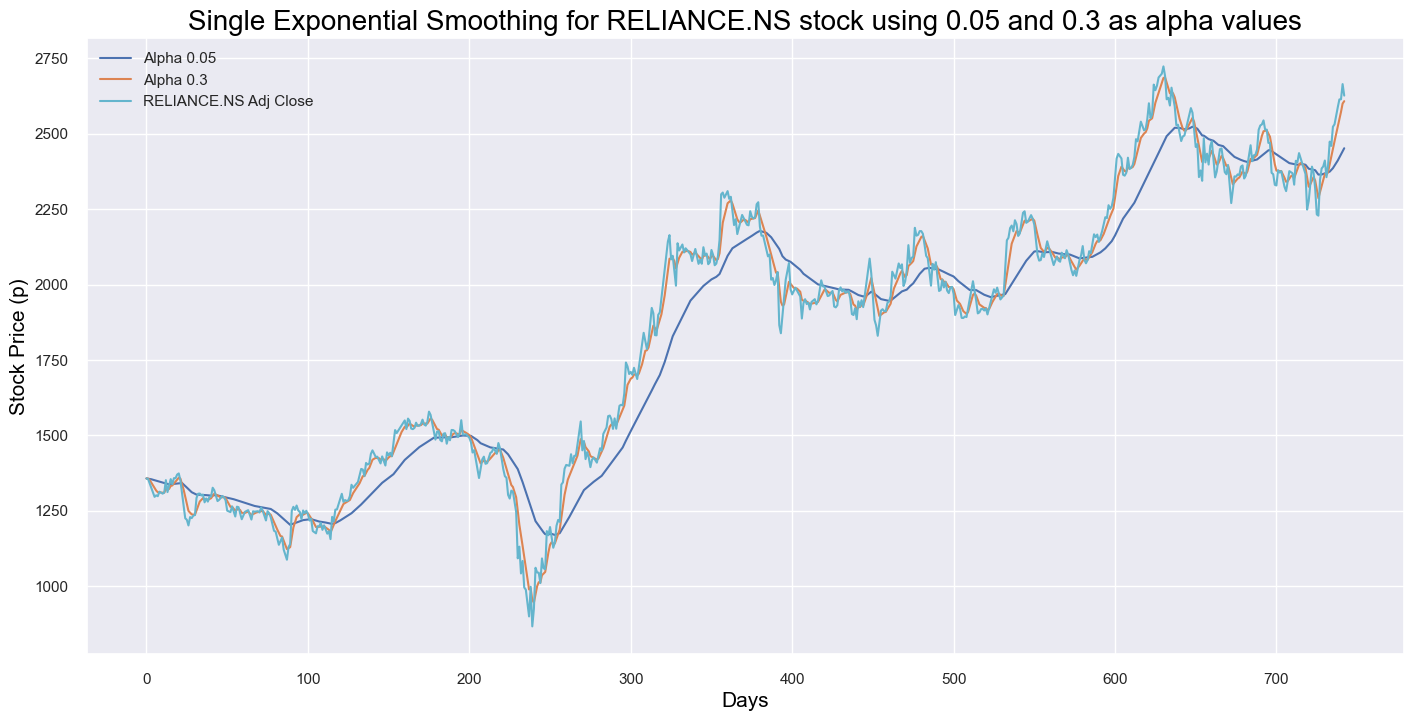

In [428]:
ticker = 'RELIANCE.NS'
title_txt = "Single Exponential Smoothing for RELIANCE.NS stock using 0.05 and 0.3 as alpha values"
label_txt = "RELIANCE.NS Adj Close"

plot_exponential_smoothing(nifty_stocks[ticker]['Adj Close'].loc['2019-04-01':'2022-03-31'], [0.05, 0.3])

The smaller the smoothing factor (coefficient), the smoother the time series will be. As the smoothing factor approaches 0, we approach the moving average model so the smoothing factor of 0.05 produces a smoother time series than 0.3. This indicates slow learning (past observations have a large influence on forecasts). A value close to 1 indicates fast learning (that is, only the most recent values influence the forecasts).

Double Exponential Smoothing (Holt’s Linear Trend Model) is an extension being a recursive use of Exponential Smoothing twice where beta is the trend smoothing factor, and takes values between 0 and 1. It explicitly adds support for trends.

In [429]:
def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result

def plot_double_exponential_smoothing(series, alphas, betas):
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        for beta in betas:
            plt.plot(double_exponential_smoothing(series, alpha, beta), label=f"Alpha {alpha}, beta {beta}")
    plt.plot(series.values, label = f"{label_txt}")
    plt.xlabel('Days', color = 'black', fontsize = 15)
    plt.ylabel('Stock Price (p)', color = 'black', fontsize = 15)
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title(f"{title_txt}", color = 'black', fontsize = 20)
    plt.grid(True)

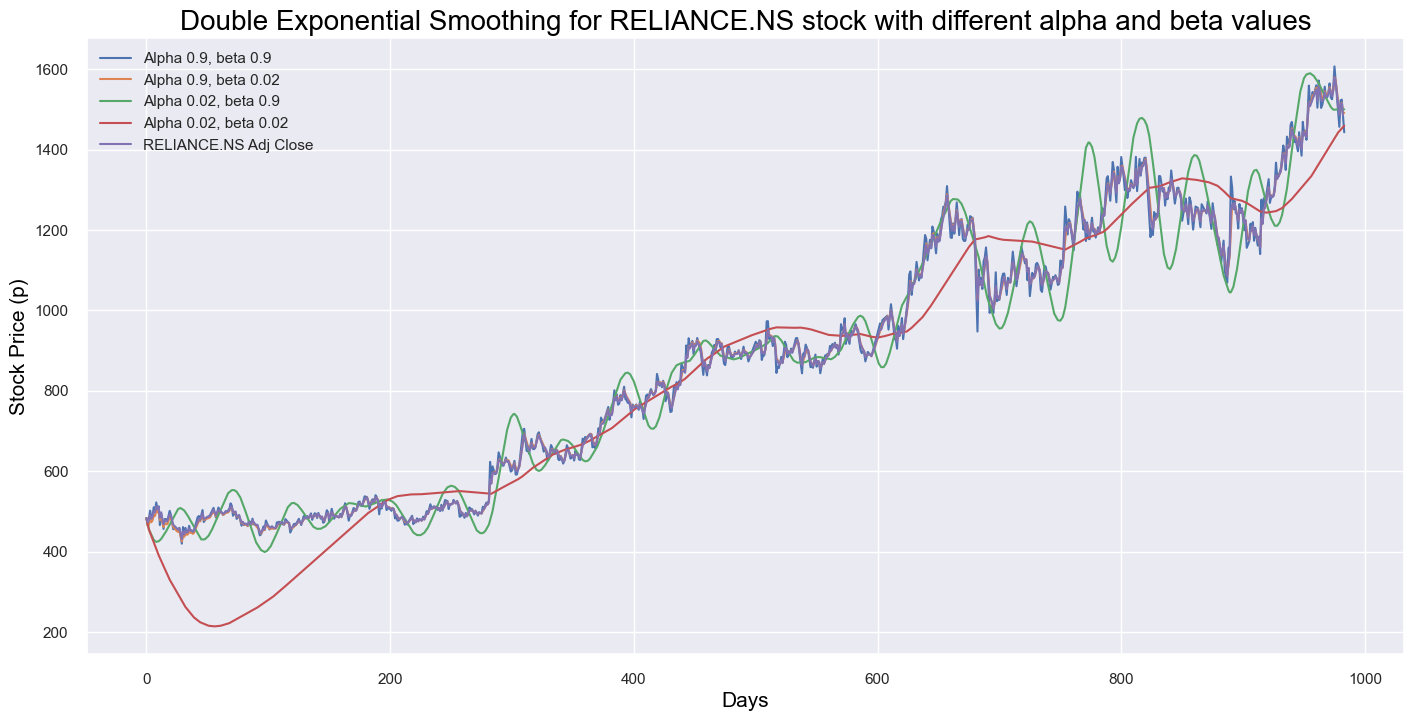

In [430]:
ticker = 'RELIANCE.NS'
title_txt = "Double Exponential Smoothing for RELIANCE.NS stock with different alpha and beta values"
label_txt = "RELIANCE.NS Adj Close"

plot_double_exponential_smoothing(nifty_stocks[ticker]['Adj Close'].loc['2016-01-01':'2019-12-31'], alphas=[0.9, 0.02], betas=[0.9, 0.02])

The third main type is Triple Exponential Smoothing (Holt Winters Method) which is an extension of Exponential Smoothing that explicitly adds support for seasonality, or periodic fluctuations.

### 5.1.7 Moving average convergence divergence (MACD)

The MACD is a trend-following momentum indicator turning two trend-following indicators, moving averages, into a momentum oscillator by subtracting the longer moving average from the shorter one.

It is useful although lacking one prediction element - because it is unbounded it is not particularly useful for identifying overbought and oversold levels. Traders can look for signal line crossovers, neutral/centreline crossovers (otherwise known as the 50 level) and divergences from the price action to generate signals. 

The default parameters are 26 EMA of prices, 12 EMA of prices and a 9-moving average of the difference between the first two.

In [431]:
def adj_3mo():
  sns.set(rc={'figure.figsize':(15, 9)})
  nifty_stocks[ticker]['Adj Close'].loc['2022-04-01':'2023-03-31'].plot(label=f"{label_txt}")
  plt.title(f"{title_txt}", color = 'black', fontsize = 20)
  plt.xlabel('Date', color = 'black', fontsize = 15)
  plt.ylabel('Stock Price (p)', color = 'black', fontsize = 15);
  plt.legend()



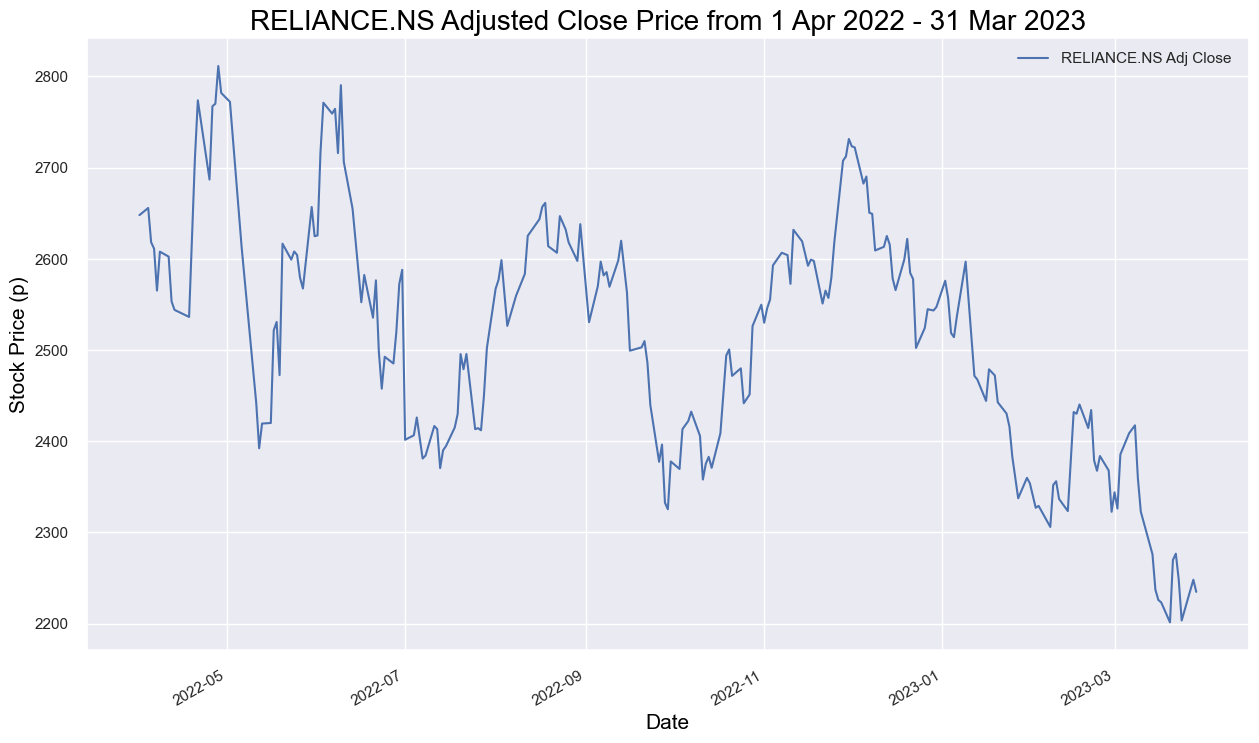

In [432]:
ticker = 'RELIANCE.NS'
title_txt = "RELIANCE.NS Adjusted Close Price from 1 Apr 2022 - 31 Mar 2023"
label_txt = "RELIANCE.NS Adj Close "

adj_3mo()

In [433]:
RELIANCEINDUSTRY_adj_3mo = RELIANCEINDUSTRY[['Adj Close']]['2022-04-01':'2023-03-31']

In [434]:
ShortEMA = RELIANCEINDUSTRY_adj_3mo['Adj Close'].ewm(span=12, adjust=False).mean()
LongEMA = RELIANCEINDUSTRY_adj_3mo['Adj Close'].ewm(span=26, adjust=False).mean()
MACD = ShortEMA - LongEMA
signal = MACD.ewm(span=9, adjust=False).mean()

In [435]:
def macd():
  plt.figure(figsize=(15, 9))
  plt.plot(RELIANCEINDUSTRY_adj_3mo.index, MACD, label = f"{macd_label_txt}", color= 'red')
  plt.plot(RELIANCEINDUSTRY_adj_3mo.index, signal, label = f"{sig_label_txt}", color= 'blue')
  plt.title(f"{title_txt}", color = 'black', fontsize = 20)
  plt.xticks (rotation = 45)
  plt.xlabel('Date', color = 'black', fontsize = 15)
  plt.legend(loc='upper left')
  plt.show()

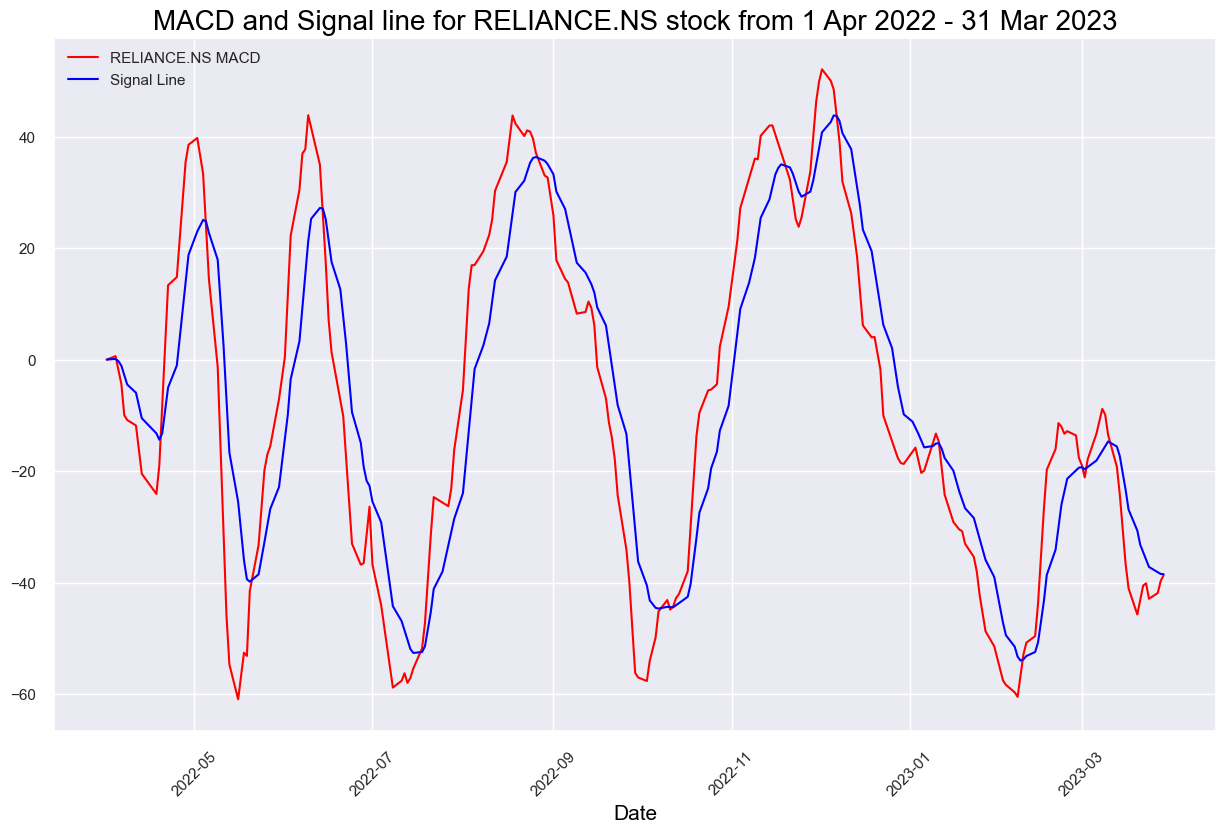

In [436]:
ticker = 'RELIANCE.NS'
title_txt = 'MACD and Signal line for RELIANCE.NS stock from 1 Apr 2022 - 31 Mar 2023'
macd_label_txt ="RELIANCE.NS MACD"
sig_label_txt = "Signal Line"

macd()

When the MACD line crosses above the signal line this indicates a good time to buy.

In [437]:
# Create new columns for the MACD and Signal Line data

RELIANCEINDUSTRY_adj_3mo['MACD'] = MACD
RELIANCEINDUSTRY_adj_3mo['Signal Line'] = signal
RELIANCEINDUSTRY_adj_3mo

Adj Close       MACD  Signal Line
Date                                           
2022-04-01  2647.878174   0.000000     0.000000
2022-04-04  2655.704346   0.624310     0.124862
2022-04-05  2618.167480  -1.888067    -0.277724
2022-04-06  2611.188477  -4.391666    -1.100512
2022-04-07  2565.127197  -9.977532    -2.875916
...                 ...        ...          ...
2023-03-23  2247.800049 -40.140052   -35.771382
2023-03-24  2203.300049 -42.915287   -37.200163
2023-03-27  2237.550049 -41.868360   -38.133803
2023-03-28  2248.000000 -39.737371   -38.454516
2023-03-29  2234.699951 -38.675918   -38.498797

[248 rows x 3 columns]

In [438]:
# Function to signal when to buy and sell

def buy_sell_macd(signal):
  Buy = []
  Sell = []
  flag = -1

  for i in range(0, len(signal)):
    if signal['MACD'][i] > signal['Signal Line'][i]:
      Sell.append(np.nan)
      if flag != 1:
        Buy.append(signal['Adj Close'][i])
        flag = 1
      else:
        Buy.append(np.nan)
    elif signal['MACD'][i] < signal['Signal Line'][i]:
      Buy.append(np.nan)
      if flag != 0:
        Sell.append(signal['Adj Close'][i])
        flag = 0
      else:
        Sell.append(np.nan)
    else:
      Buy.append(np.nan)
      Sell.append(np.nan)

  return (Buy, Sell)

In [439]:
# Create buy and sell columns

a = buy_sell_macd(RELIANCEINDUSTRY_adj_3mo)
RELIANCEINDUSTRY_adj_3mo['Buy_Signal_Price'] = a[0]
RELIANCEINDUSTRY_adj_3mo['Sell_Signal_Price'] = a[1]

In [440]:
RELIANCEINDUSTRY_adj_3mo

Adj Close       MACD  Signal Line  Buy_Signal_Price  \
Date                                                                
2022-04-01  2647.878174   0.000000     0.000000               NaN   
2022-04-04  2655.704346   0.624310     0.124862       2655.704346   
2022-04-05  2618.167480  -1.888067    -0.277724               NaN   
2022-04-06  2611.188477  -4.391666    -1.100512               NaN   
2022-04-07  2565.127197  -9.977532    -2.875916               NaN   
...                 ...        ...          ...               ...   
2023-03-23  2247.800049 -40.140052   -35.771382               NaN   
2023-03-24  2203.300049 -42.915287   -37.200163               NaN   
2023-03-27  2237.550049 -41.868360   -38.133803               NaN   
2023-03-28  2248.000000 -39.737371   -38.454516               NaN   
2023-03-29  2234.699951 -38.675918   -38.498797               NaN   

            Sell_Signal_Price  
Date                           
2022-04-01                NaN  
2022-04-04                NaN  
2022-04-05         2618.16748  
2022-04-06                NaN  
2022-04-07                NaN  
...                       ...  
2023-03-23                NaN  
2023-03-24                NaN  
2023-03-27                NaN  
2023-03-28                NaN  
2023-03-29                NaN  

[248 rows x 5 columns]

In [441]:
# Plot buy and sell signals

def buy_sell_macd_plot():
  plt.figure(figsize=(20, 10))
  plt.scatter(RELIANCEINDUSTRY_adj_3mo.index, RELIANCEINDUSTRY_adj_3mo['Buy_Signal_Price'], color='green', label='Buy', marker='^', alpha=1)
  plt.scatter(RELIANCEINDUSTRY_adj_3mo.index, RELIANCEINDUSTRY_adj_3mo['Sell_Signal_Price'], color='red', label='Sell', marker='v', alpha=1)
  plt.plot(RELIANCEINDUSTRY_adj_3mo['Adj Close'], label='Adj Close Price', alpha = 0.35)
  plt.title(f"{title_txt}", color = 'black', fontsize = 20)
  plt.xlabel('Date', color = 'black', fontsize = 15)
  plt.ylabel('Adj Close Price')
  plt.legend(loc = 'upper left')
  plt.show()

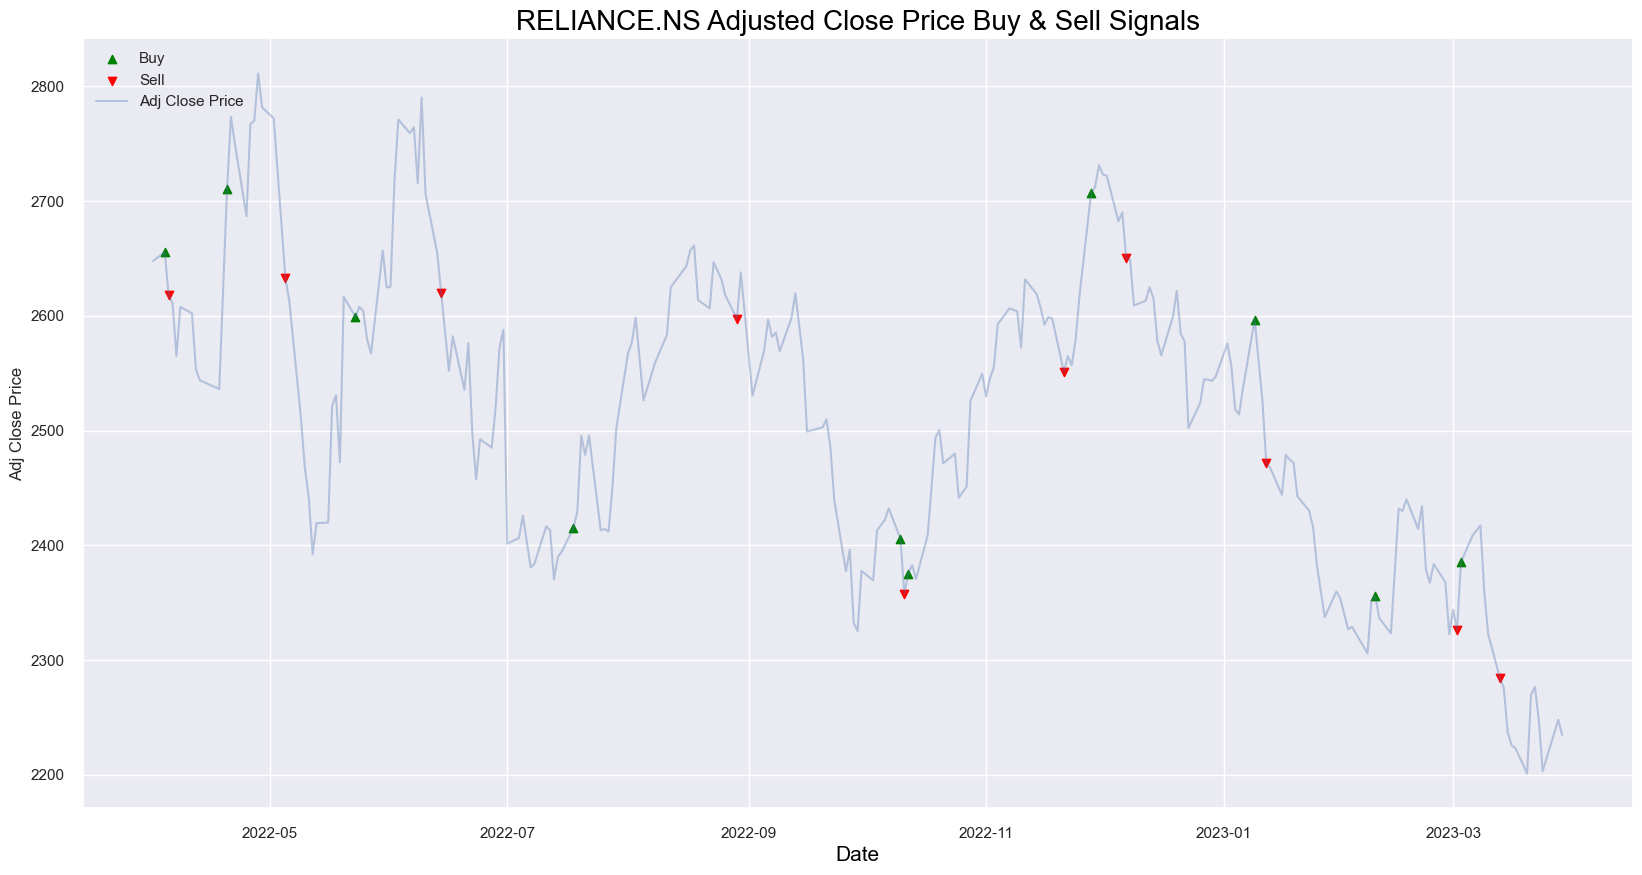

In [442]:
ticker = 'RELIANCE.NS'
title_txt = 'RELIANCE.NS Adjusted Close Price Buy & Sell Signals'

buy_sell_macd_plot()

## 5.2 Momentum Strategies

In momentum algorithmic trading strategies stocks have momentum (i.e. upward or downward trends) that we can detect and exploit.

### 5.2.1 Relative Strength Index (RSI)

The RSI is a momentum indicator. A typical momentum strategy will buy stocks that have been showing an upward trend in hopes that the trend will continue, and make predictions based on whether the past recent values were going up or going down. 

The RSI determines the level of overbought (70) and oversold (30) zones using a default lookback period of 14 i.e. it uses the last 14 values to calculate its values. The idea is to buy when the RSI touches the 30 barrier and sell when it touches the 70 barrier. 

In [443]:
def adj_12mo():
  sns.set(rc={'figure.figsize':(15, 9)})
  nifty_stocks[ticker]['Adj Close'].loc['2022-04-01':'2023-03-31'].plot(label=f"{label_txt}")
  plt.title(f"{title_txt}", color = 'black', fontsize = 20)
  plt.xlabel('Date', color = 'black', fontsize = 15)
  plt.ylabel('Stock Price (p)', color = 'black', fontsize = 15);
  plt.legend()

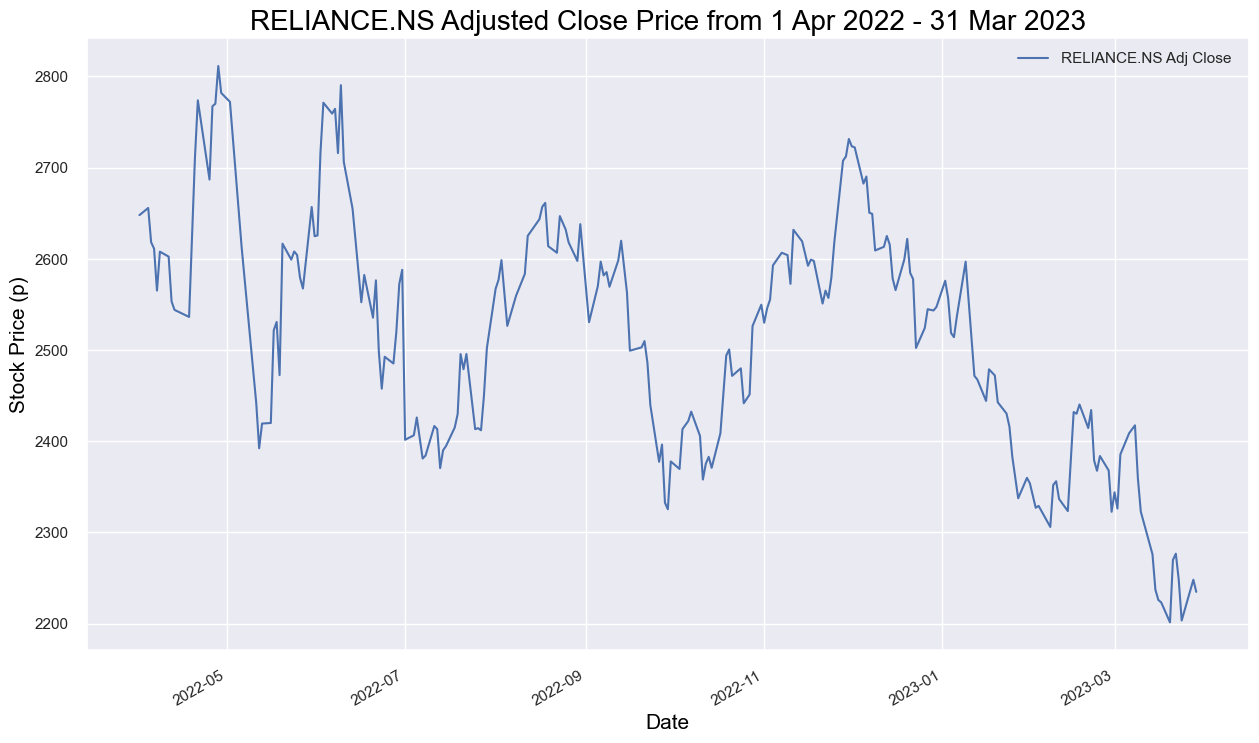

In [444]:
ticker = 'RELIANCE.NS'
title_txt = "RELIANCE.NS Adjusted Close Price from 1 Apr 2022 - 31 Mar 2023"
label_txt = "RELIANCE.NS Adj Close "

adj_12mo()

In [445]:
RELIANCEINDUSTRY_adj_12mo = RELIANCEINDUSTRY[['Adj Close']]['2022-04-01':'2023-03-31']

In [446]:
# Prepare the data to calculate the RSI

# Get difference in price for previous day
delta = RELIANCEINDUSTRY_adj_12mo['Adj Close'].diff(1)
delta

Date
2022-04-01          NaN
2022-04-04     7.826172
2022-04-05   -37.536865
2022-04-06    -6.979004
2022-04-07   -46.061279
                ...    
2023-03-23   -28.800049
2023-03-24   -44.500000
2023-03-27    34.250000
2023-03-28    10.449951
2023-03-29   -13.300049
Name: Adj Close, Length: 248, dtype: float64

In [447]:
# Remove NaNs

delta = delta.dropna()
delta

Date
2022-04-04     7.826172
2022-04-05   -37.536865
2022-04-06    -6.979004
2022-04-07   -46.061279
2022-04-08    42.671387
                ...    
2023-03-23   -28.800049
2023-03-24   -44.500000
2023-03-27    34.250000
2023-03-28    10.449951
2023-03-29   -13.300049
Name: Adj Close, Length: 247, dtype: float64

In [448]:
# Get positive gains (up) and negative gains (down)
up = delta.copy()
down = delta.copy()

up[up < 0] = 0
down[down > 0] = 0

In [449]:
# Get time period

period = 14

# Calculate average gain and average loss
AVG_Gain = up.rolling(window=period).mean()
#AVG_Loss = abs(down.rolling(window=period).mean())
AVG_Loss = down.abs().rolling(window=period).mean()

In [450]:
# Calculate RSI based on SMA

# Calculate Relative Strength (RS)
RS = AVG_Gain / AVG_Loss
# Calculate RSI
RSI = 100.0 - (100.0 / (1.0 + RS))

In [451]:
def rsi():
  sns.set(rc={'figure.figsize':(20, 10)})
  plt.title(f"{title_txt}", color = 'black', fontsize = 20)
  plt.xlabel('Date', color = 'black', fontsize = 15)
  plt.ylabel('RSI', color = 'black', fontsize = 15);
  RSI.plot()


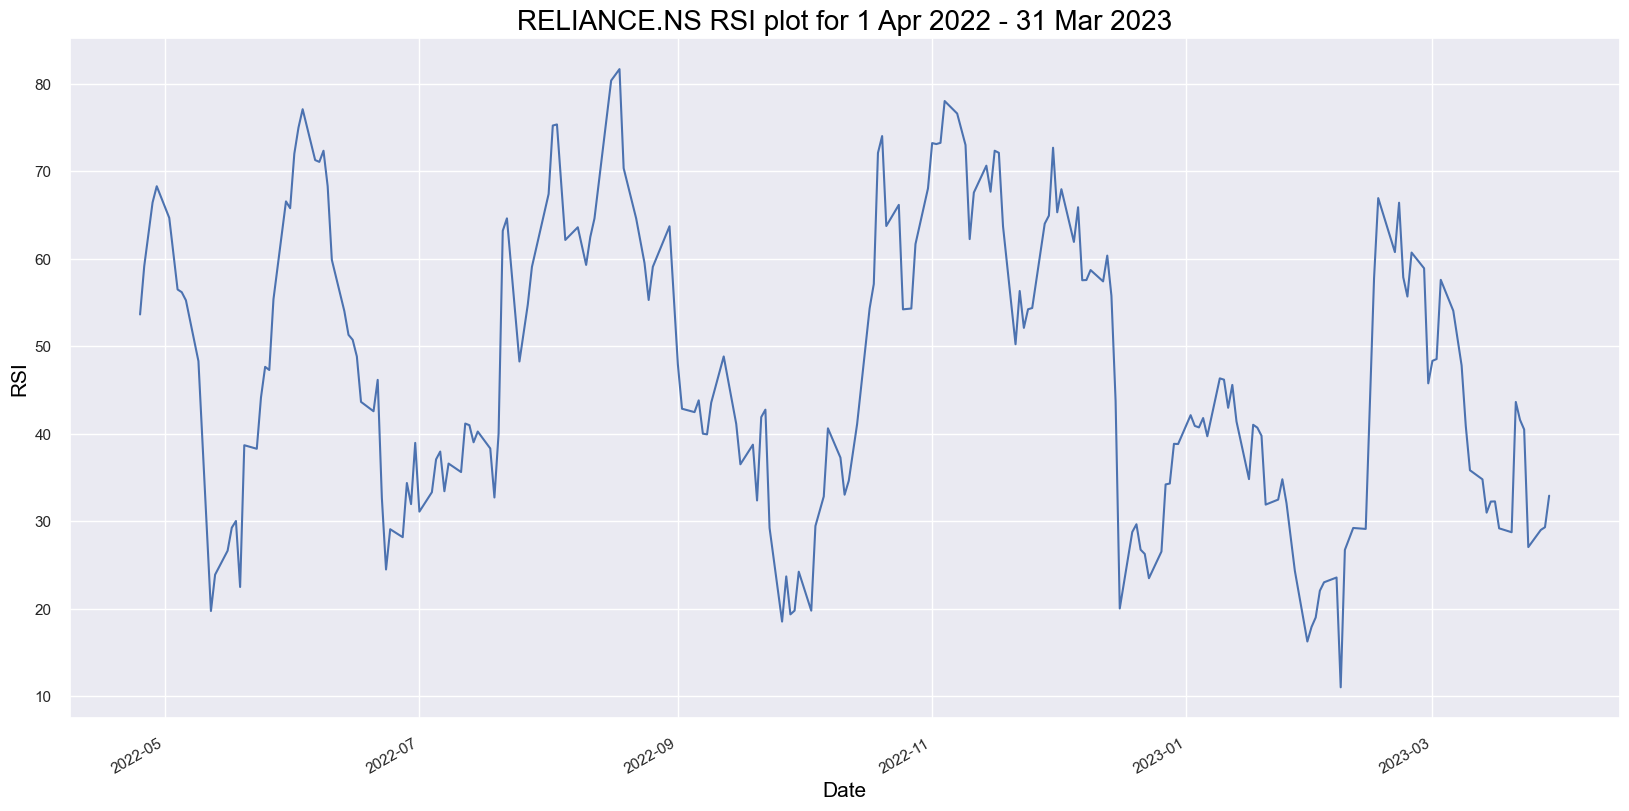

In [452]:
ticker = 'RELIANCE.NS'
title_txt = "RELIANCE.NS RSI plot for 1 Apr 2022 - 31 Mar 2023"
label_txt = "RELIANCE.NS RSI level"

rsi()

In [453]:
# Create dataframe with Adjusted Close and RSI

new_df = pd.DataFrame()
new_df['Adj Close'] = RELIANCEINDUSTRY_adj_12mo['Adj Close']
new_df['RSI'] = RSI
new_df

Adj Close        RSI
Date                              
2022-04-01  2647.878174        NaN
2022-04-04  2655.704346        NaN
2022-04-05  2618.167480        NaN
2022-04-06  2611.188477        NaN
2022-04-07  2565.127197        NaN
...                 ...        ...
2023-03-23  2247.800049  40.493264
2023-03-24  2203.300049  27.048191
2023-03-27  2237.550049  29.007759
2023-03-28  2248.000000  29.319817
2023-03-29  2234.699951  32.921980

[248 rows x 2 columns]

In [454]:
def adj_close_12mo():
  sns.set(rc={'figure.figsize':(20, 10)})
  plt.plot(new_df.index, new_df['Adj Close'])
  plt.title(f"{title_txt}", color = 'black', fontsize = 20)
  plt.xlabel('Date', color = 'black', fontsize = 15)
  plt.ylabel('Stock Price (p)', color = 'black', fontsize = 15);
  plt.legend(new_df.columns.values, loc = 'upper left')
  plt.show()

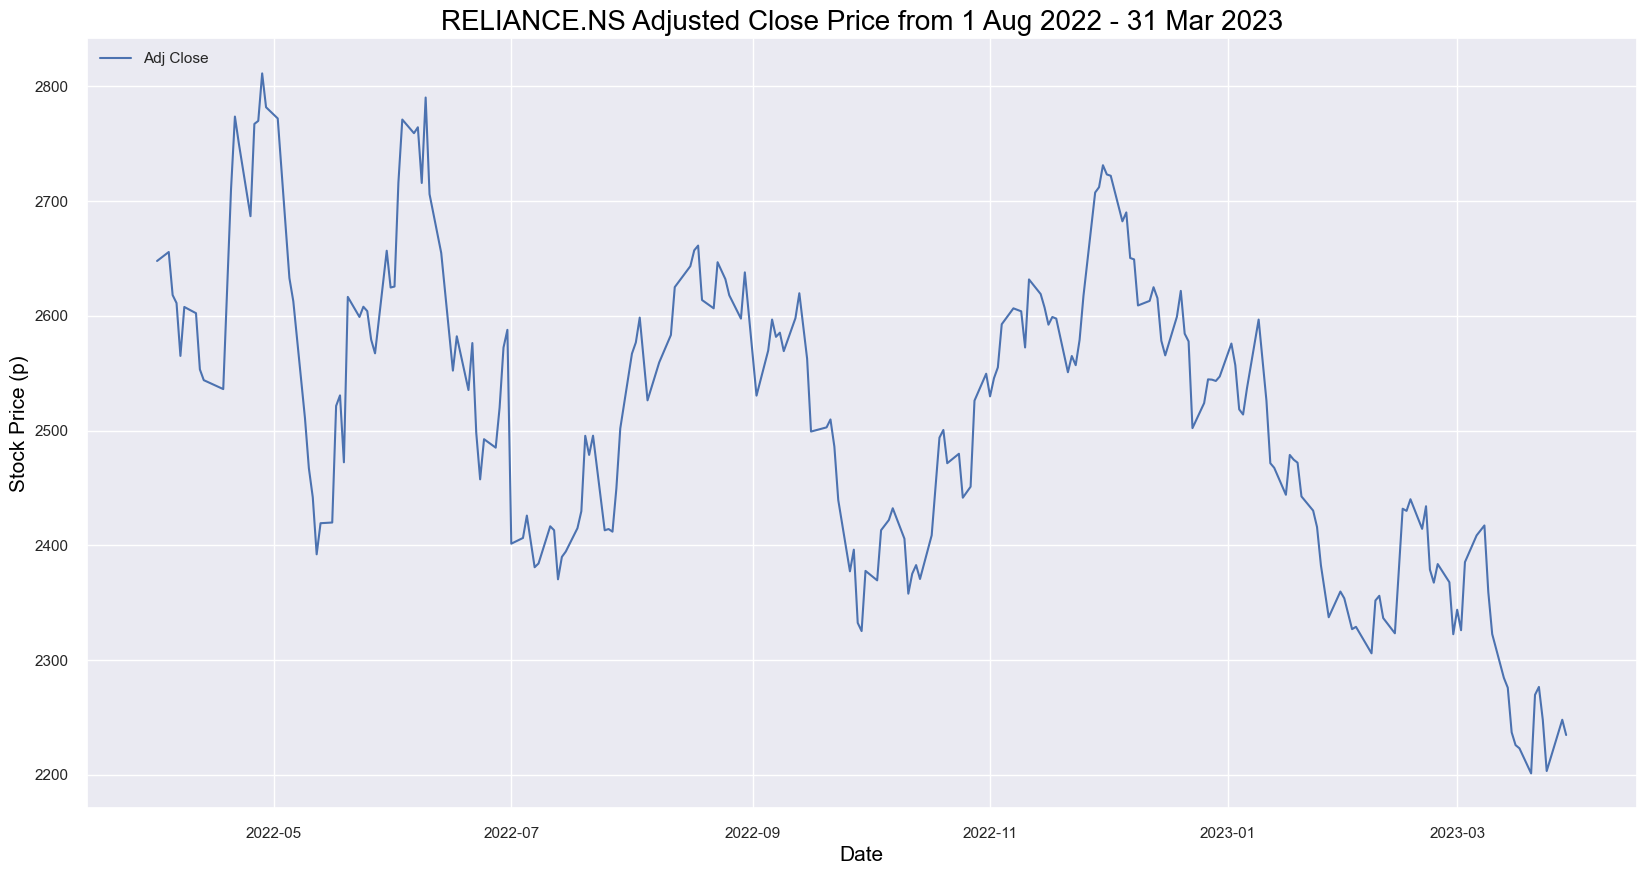

In [455]:
title_txt = "RELIANCE.NS Adjusted Close Price from 1 Aug 2022 - 31 Mar 2023"

adj_close_12mo()

In [456]:
# Plot corresponding RSI values and the significant levels

def rsi_sma():
  plt.figure(figsize=(20, 10))
  plt.title(f"{title_txt}", color = 'black', fontsize = 20)
  plt.plot(new_df.index, new_df['RSI'])
  plt.xlabel('Date', color = 'black', fontsize = 15)
  plt.axhline(0, linestyle='--', alpha = 0.5, color='gray')
  plt.axhline(10, linestyle='--', alpha = 0.5, color='orange')
  plt.axhline(20, linestyle='--', alpha = 0.5, color='green')
  plt.axhline(30, linestyle='--', alpha = 0.5, color='red')
  plt.axhline(70, linestyle='--', alpha = 0.5, color='red')
  plt.axhline(80, linestyle='--', alpha = 0.5, color='green')
  plt.axhline(90, linestyle='--', alpha = 0.5, color='orange')
  plt.axhline(100, linestyle='--', alpha = 0.5, color='gray')
  plt.show()

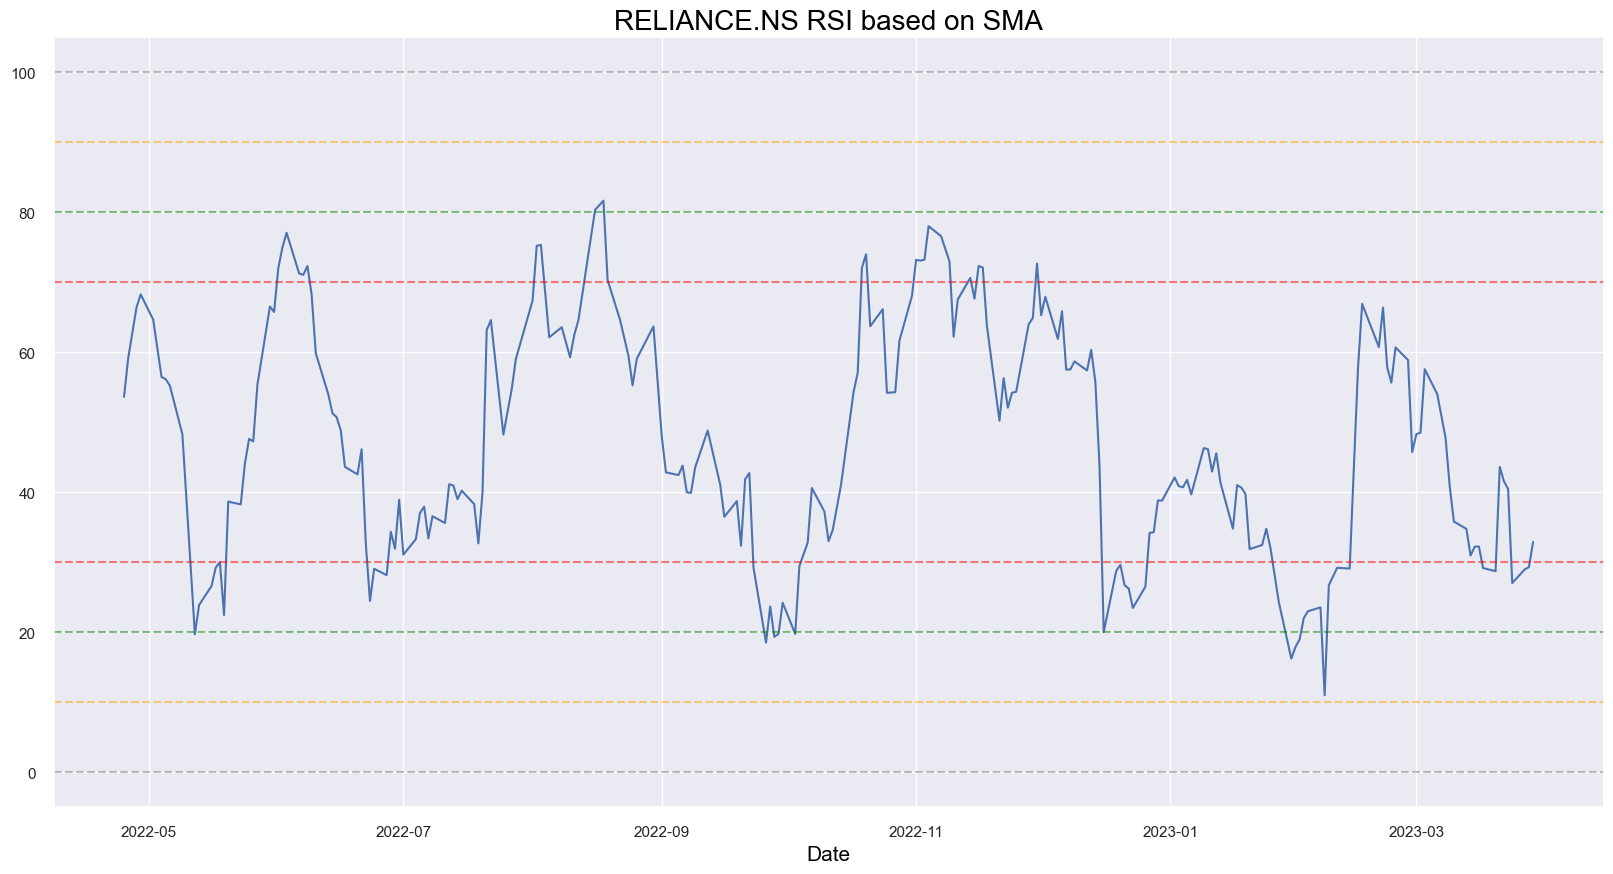

In [457]:
title_txt = 'RELIANCE.NS RSI based on SMA'

rsi_sma()

In [458]:
period = 14

# Calculate the EWMA average gain and average loss
AVG_Gain2 = up.ewm(span=period).mean()
AVG_Loss2 = down.abs().ewm(span=period).mean()

# Calculate the RSI based on EWMA
RS2 = AVG_Gain2 / AVG_Loss2
RSI2 = 100.0 - (100.0 / (1.0 + RS2))

In [459]:
new_df2 = pd.DataFrame()
new_df2['Adj Close'] = RELIANCEINDUSTRY_adj_12mo['Adj Close']
new_df2['RSI2'] = RSI2
new_df2

Adj Close        RSI2
Date                               
2022-04-01  2647.878174         NaN
2022-04-04  2655.704346  100.000000
2022-04-05  2618.167480   15.304042
2022-04-06  2611.188477   12.950910
2022-04-07  2565.127197    5.965607
...                 ...         ...
2023-03-23  2247.800049   40.226412
2023-03-24  2203.300049   32.091261
2023-03-27  2237.550049   42.430635
2023-03-28  2248.000000   45.359407
2023-03-29  2234.699951   42.206168

[248 rows x 2 columns]

In [460]:
# Plot corresponding RSI values and the significant levels

def rsi_ewma():
  plt.figure(figsize=(20, 10))
  plt.title(f"{title_txt}", color = 'black', fontsize = 20)
  plt.xlabel('Date', color = 'black', fontsize = 15)
  plt.plot(new_df2.index, new_df2['RSI2'])
  plt.axhline(0, linestyle='--', alpha = 0.5, color='gray')
  plt.axhline(10, linestyle='--', alpha = 0.5, color='orange')
  plt.axhline(20, linestyle='--', alpha = 0.5, color='green')
  plt.axhline(30, linestyle='--', alpha = 0.5, color='red')
  plt.axhline(70, linestyle='--', alpha = 0.5, color='red')
  plt.axhline(80, linestyle='--', alpha = 0.5, color='green')
  plt.axhline(90, linestyle='--', alpha = 0.5, color='orange')
  plt.axhline(100, linestyle='--', alpha = 0.5, color='gray')
  plt.show()

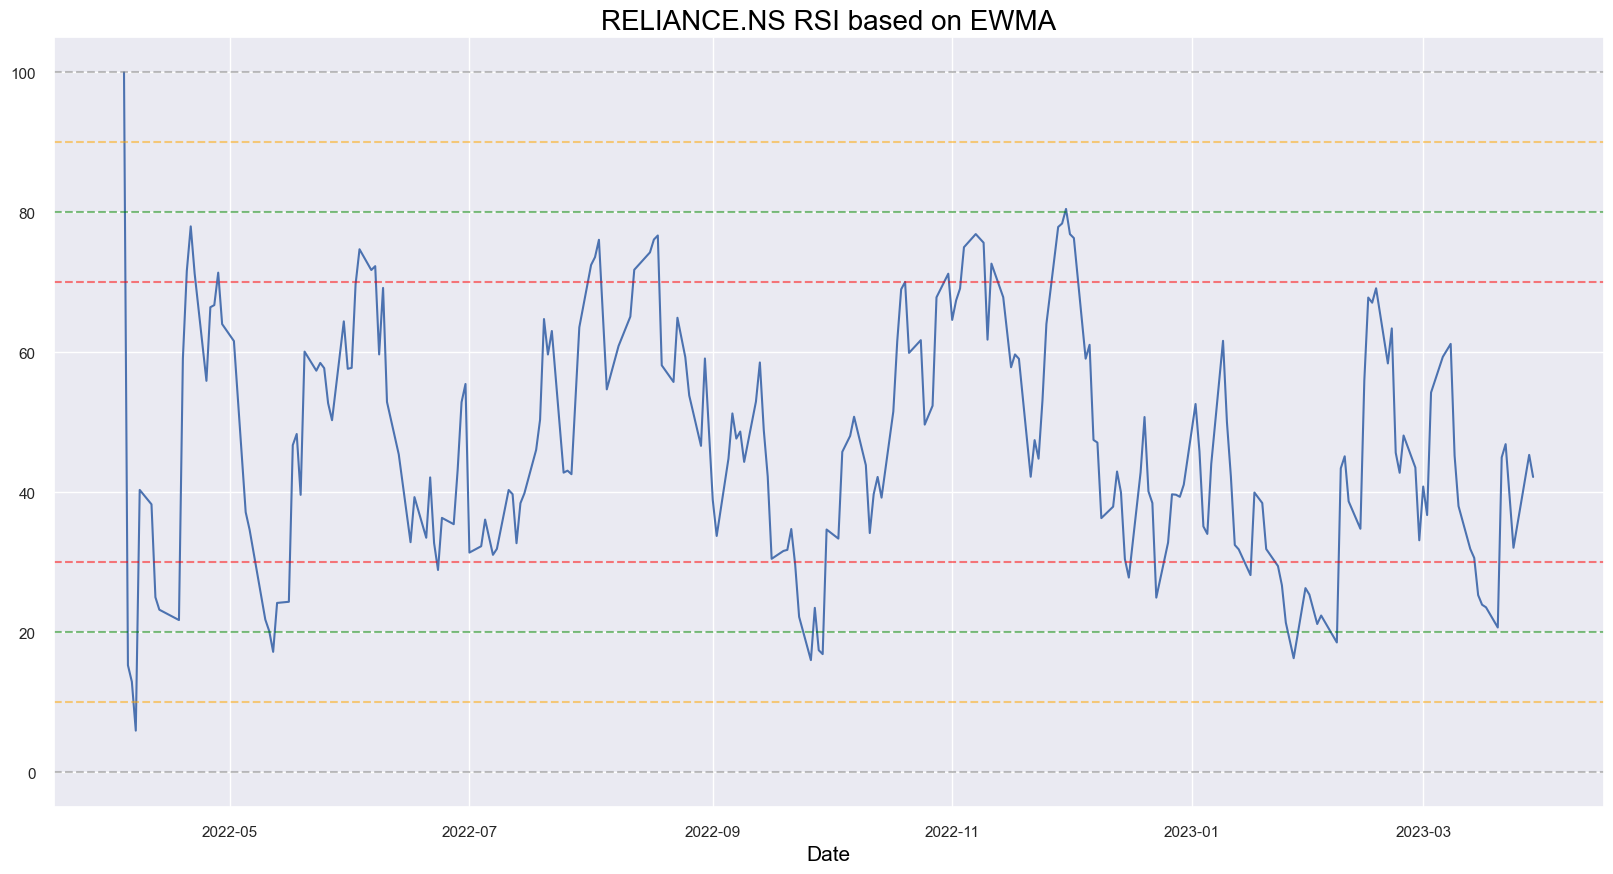

In [461]:
title_txt = 'RELIANCE.NS RSI based on EWMA'

rsi_ewma()

It appears that RSI value dips below the 20 significant level in January 2019 indicating that the stock was oversold and presented a buying opportunity for an investor before a price rise.

### 5.2.2 Money Flow Index (MFI)

Money Flow Index (MFI) is a technical oscillator, and momentum indicator, that uses price and volume data for identifying overbought or oversold signals in an asset. It can also be used to spot divergences which warn of a trend change in price. The oscillator moves between 0 and 100 and a reading of above 80 implies overbought conditions, and below 20 implies oversold conditions.

It is related to the Relative Strength Index (RSI) but incorporates volume, whereas the RSI only considers price. 

In [462]:
RELIANCEINDUSTRY_12mo = RELIANCEINDUSTRY.copy()  

In [463]:
RELIANCEINDUSTRY_12mo = RELIANCEINDUSTRY_12mo['2022-04-01':'2023-03-31']
RELIANCEINDUSTRY_12mo

Open         High          Low        Close    Adj Close  \
Date                                                                          
2022-04-01  2636.000000  2665.149902  2622.000000  2655.850098  2647.878174   
2022-04-04  2655.449951  2675.000000  2641.649902  2663.699951  2655.704346   
2022-04-05  2651.100098  2669.899902  2620.699951  2626.050049  2618.167480   
2022-04-06  2587.100098  2634.500000  2587.100098  2619.050049  2611.188477   
2022-04-07  2595.100098  2606.000000  2567.000000  2572.850098  2565.127197   
...                 ...          ...          ...          ...          ...   
2023-03-23  2268.000000  2269.899902  2243.050049  2247.800049  2247.800049   
2023-03-24  2245.250000  2250.000000  2198.000000  2203.300049  2203.300049   
2023-03-27  2217.500000  2254.000000  2200.199951  2237.550049  2237.550049   
2023-03-28  2245.000000  2256.500000  2237.000000  2248.000000  2248.000000   
2023-03-29  2239.000000  2244.800049  2211.100098  2234.699951  2234.699951   

             Volume  
Date                 
2022-04-01  3656408  
2022-04-04  3659307  
2022-04-05  6068663  
2022-04-06  5656703  
2022-04-07  7151632  
...             ...  
2023-03-23  7499082  
2023-03-24  5711497  
2023-03-27  6486068  
2023-03-28  5804018  
2023-03-29  8678073  

[248 rows x 6 columns]

In [464]:
def RELIANCEINDUSTRY_12mo_close():
  plt.figure(figsize=(20, 10))
  plt.plot(RELIANCEINDUSTRY_12mo['Close'])
  plt.title(f"{title_txt}", color = 'black', fontsize = 20)
  plt.xlabel('Date', color = 'black', fontsize = 15)
  plt.ylabel('Close Price', color = 'black', fontsize = 15)
  plt.legend(RELIANCEINDUSTRY_12mo.columns.values, loc='upper left')
  plt.show()

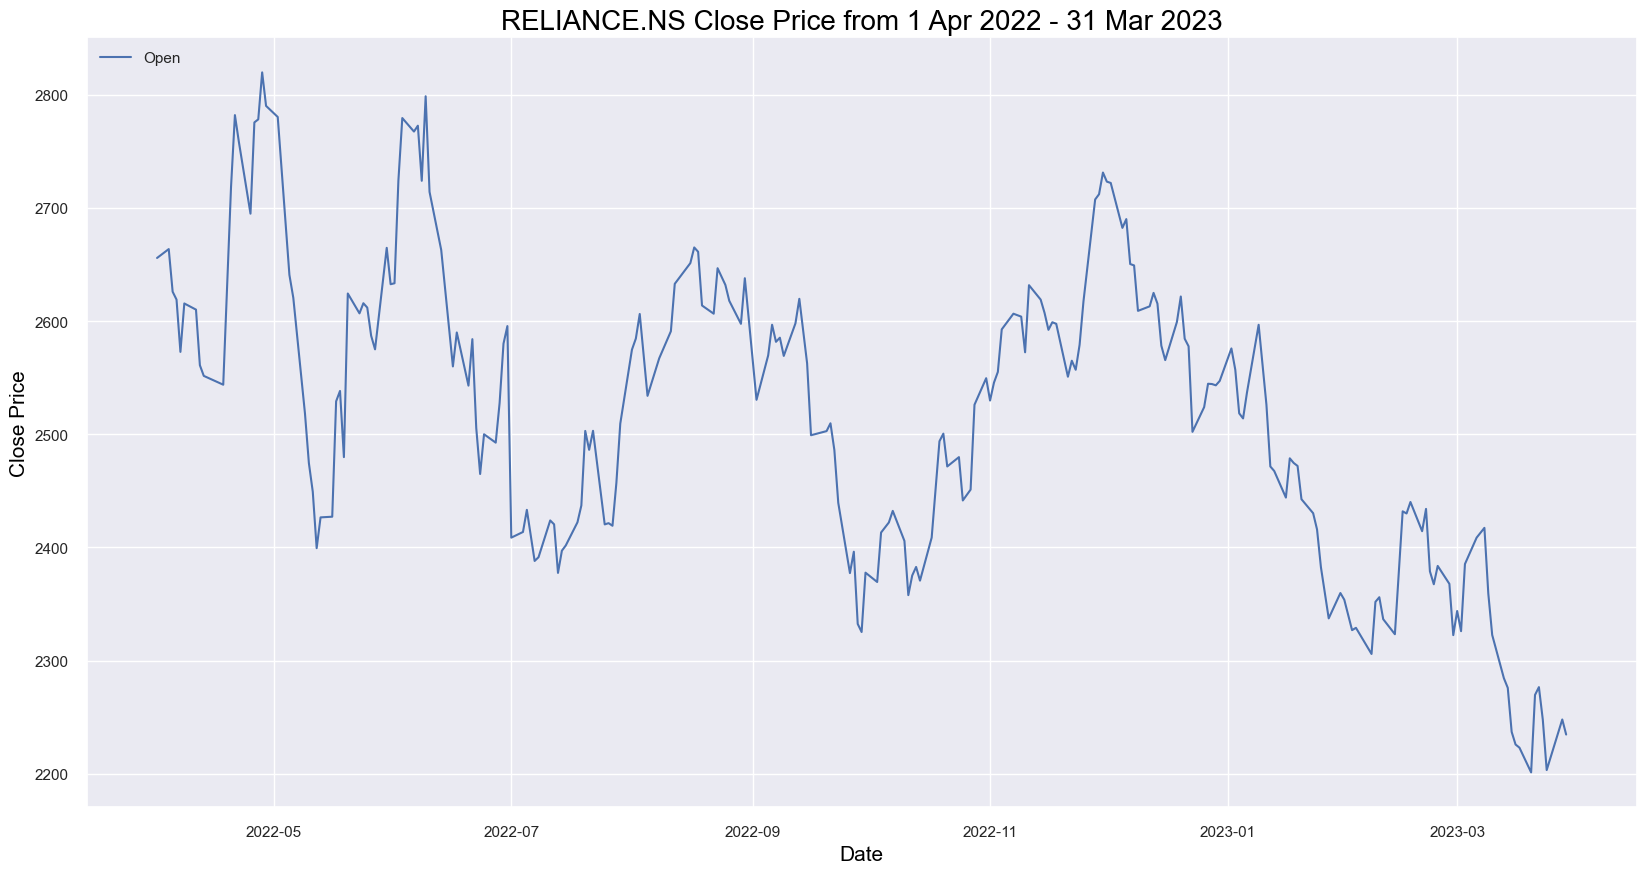

In [465]:
title_txt = "RELIANCE.NS Close Price from 1 Apr 2022 - 31 Mar 2023"
label_txt = "RELIANCE.NS Close price "

RELIANCEINDUSTRY_12mo_close()

In [466]:
# Calculate typical price

typical_price = (RELIANCEINDUSTRY_12mo['Close'] + RELIANCEINDUSTRY_12mo['High'] + RELIANCEINDUSTRY_12mo['Low']) / 3
typical_price

Date
2022-04-01    2647.666667
2022-04-04    2660.116618
2022-04-05    2638.883301
2022-04-06    2613.550049
2022-04-07    2581.950033
                 ...     
2023-03-23    2253.583333
2023-03-24    2217.100016
2023-03-27    2230.583333
2023-03-28    2247.166667
2023-03-29    2230.200033
Length: 248, dtype: float64

In [467]:
period = 14

In [468]:
# Calculate the money flow
money_flow = typical_price * RELIANCEINDUSTRY_12mo['Volume']
money_flow

Date
2022-04-01    9.680950e+09
2022-04-04    9.734183e+09
2022-04-05    1.601449e+10
2022-04-06    1.478408e+10
2022-04-07    1.846516e+10
                  ...     
2023-03-23    1.689981e+10
2023-03-24    1.266296e+10
2023-03-27    1.446772e+10
2023-03-28    1.304260e+10
2023-03-29    1.935384e+10
Length: 248, dtype: float64

In [469]:
# Get all positive and negative money flows
positive_flow = []
negative_flow = []

# Loop through typical price
for i in range(1, len(typical_price)):
  if typical_price[i] > typical_price[i-1]:
    positive_flow.append(money_flow[i-1])
    negative_flow.append(0)
  elif typical_price[i] < typical_price[i-1]:
    negative_flow.append(money_flow[i-1])
    positive_flow.append(0)
  else:
    positive_flow.append(0)
    negative_flow.append(0)


In [470]:
# Get all positive and negative money flows within same time period
positive_mf = []
negative_mf = []

for i in range(period-1, len(positive_flow)):
  positive_mf.append(sum(positive_flow[i + 1 - period : i+1]))
for i in range(period-1, len(negative_flow)):
  negative_mf.append(sum(negative_flow[i + 1 - period : i+1]))

In [471]:
# Calculate money flow index

mfi = 100 * (np.array(positive_mf) / (np.array(positive_mf) + np.array(negative_mf)))
mfi

array([60.05250566, 61.84490615, 66.35979408, 73.29751753, 68.64924311,
       61.25606371, 56.28475172, 53.87925277, 52.92439813, 51.02292008,
       46.0230422 , 37.51872124, 28.92375868, 27.75145688, 34.61003372,
       33.26949605, 34.04326189, 26.26663066, 33.75002782, 42.58308607,
       41.66746719, 48.56747462, 49.57896852, 50.01489611, 57.45882732,
       58.63112947, 46.89136882, 45.12454152, 46.08551453, 39.6464474 ,
       34.62298783, 35.07812326, 34.86911365, 27.44306509, 27.0834166 ,
       21.89055415, 21.73043594, 22.24127729, 16.36852964, 15.79124733,
       25.00968995, 20.5810121 , 11.35382148, 20.41315472, 26.58547431,
       33.24650133, 33.23837137, 41.85639983, 41.09810309, 32.39889362,
       42.5820387 , 41.85024712, 41.16293475, 41.54086751, 42.57844428,
       46.42839661, 46.46604485, 45.53836617, 40.91977321, 39.76463021,
       39.94786504, 39.25300947, 39.24597369, 55.53922151, 44.90374446,
       43.88317717, 46.31843316, 53.56048412, 52.16273845, 52.58

In [472]:
df2 = pd.DataFrame()
df2['MFI'] = mfi

In [473]:
# Create the plot

def mfi_plot():
  plt.figure(figsize=(20, 10))
  plt.plot(df2['MFI'], label = 'MFI')
  plt.axhline(10, linestyle = '--', color = 'orange')
  plt.axhline(20, linestyle = '--', color = 'blue')
  plt.axhline(80, linestyle = '--', color = 'blue')
  plt.axhline(90, linestyle = '--', color = 'orange')
  plt.title(f"{title_txt}", color = 'black', fontsize = 20)
  plt.xlabel('Time periods', color = 'black', fontsize = 15)
  plt.ylabel('MFI Values', color = 'black', fontsize = 15)
  plt.show()

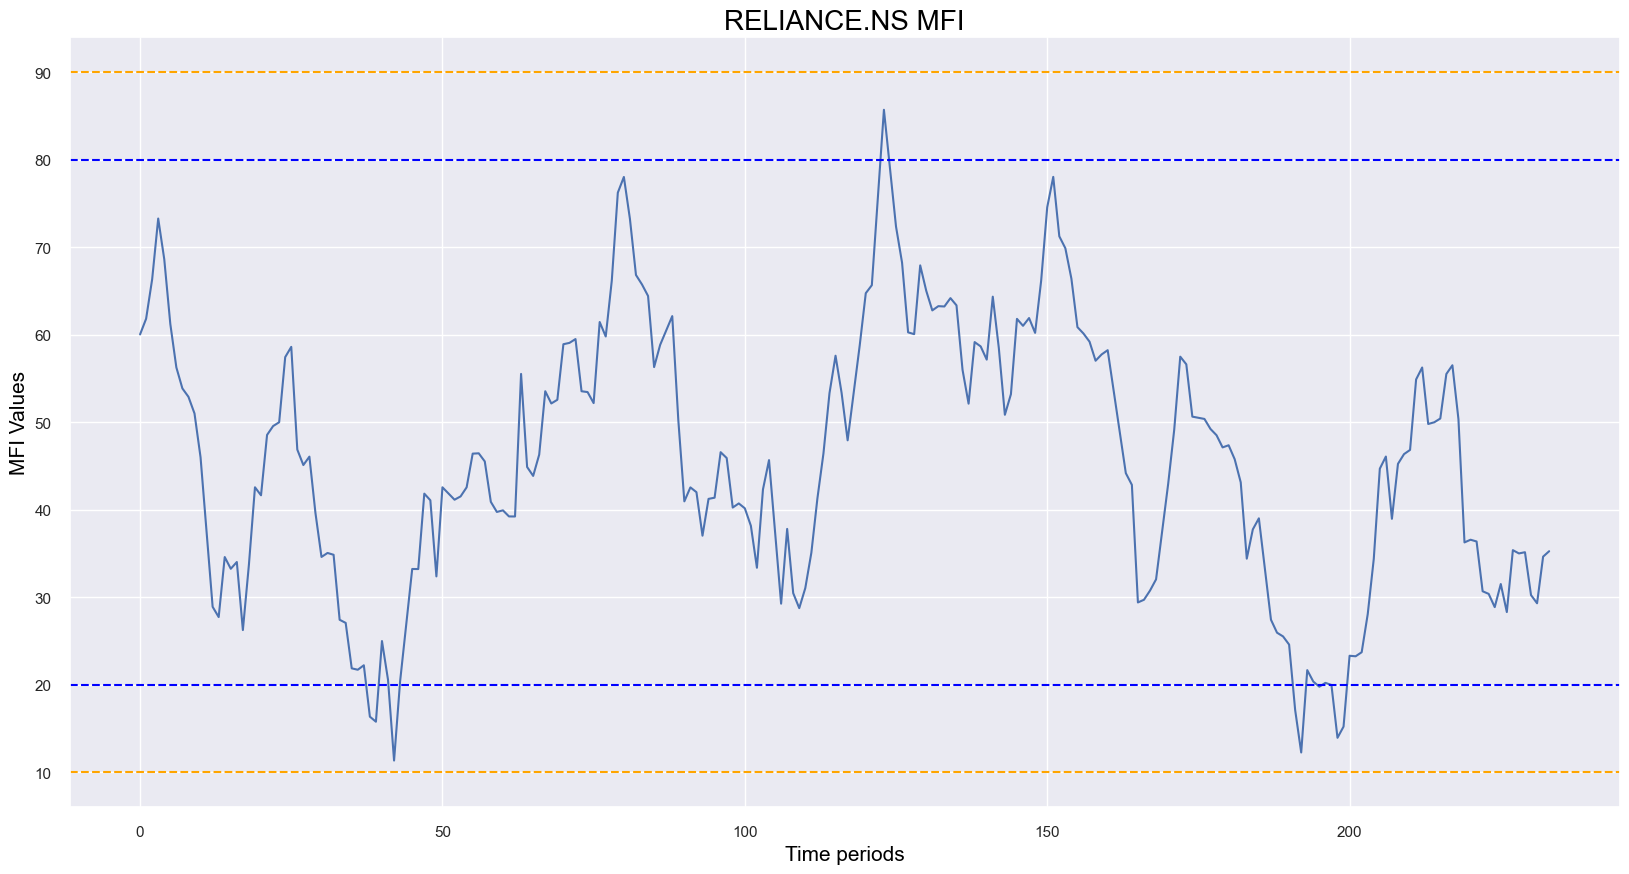

In [474]:
title_txt = "RELIANCE.NS MFI"

mfi_plot()

In [475]:
new_mfi_df = pd.DataFrame()
new_mfi_df = RELIANCEINDUSTRY_12mo[period:]
new_mfi_df['MFI'] = mfi

In [476]:
new_mfi_df

Open         High          Low        Close    Adj Close  \
Date                                                                          
2022-04-25  2742.399902  2758.399902  2663.649902  2695.000000  2686.910400   
2022-04-26  2710.000000  2795.000000  2707.699951  2775.649902  2767.318359   
2022-04-27  2755.850098  2828.000000  2755.050049  2778.350098  2770.010254   
2022-04-28  2809.949951  2851.000000  2786.100098  2819.850098  2811.385742   
2022-04-29  2856.149902  2856.149902  2777.300049  2790.250000  2781.874512   
...                 ...          ...          ...          ...          ...   
2023-03-23  2268.000000  2269.899902  2243.050049  2247.800049  2247.800049   
2023-03-24  2245.250000  2250.000000  2198.000000  2203.300049  2203.300049   
2023-03-27  2217.500000  2254.000000  2200.199951  2237.550049  2237.550049   
2023-03-28  2245.000000  2256.500000  2237.000000  2248.000000  2248.000000   
2023-03-29  2239.000000  2244.800049  2211.100098  2234.699951  2234.699951   

              Volume        MFI  
Date                             
2022-04-25   7874671  60.052506  
2022-04-26   5643066  61.844906  
2022-04-27   8924920  66.359794  
2022-04-28  11820892  73.297518  
2022-04-29   8406156  68.649243  
...              ...        ...  
2023-03-23   7499082  35.161585  
2023-03-24   5711497  30.264862  
2023-03-27   6486068  29.326740  
2023-03-28   5804018  34.655044  
2023-03-29   8678073  35.278204  

[234 rows x 7 columns]

In [477]:
# Create function to get buy and sell signals

def get_signal(data, high, low):
  buy_signal = []
  sell_signal = []

  for i in range(len(data['MFI'])):
    if data['MFI'][i] > high:
      buy_signal.append(np.nan)
      sell_signal.append(data['Close'][i])
    elif data['MFI'][i] < low:
      buy_signal.append(data['Close'][i])
      sell_signal.append(np.nan)
    else:
      sell_signal.append(np.nan)
      buy_signal.append(np.nan)

  return (buy_signal, sell_signal)


In [478]:
# Add new columns (Buy & Sell)

new_mfi_df['Buy'] = get_signal(new_mfi_df, 80, 20)[0]
new_mfi_df['Sell'] = get_signal(new_mfi_df, 80, 20)[1]

new_mfi_df

Open         High          Low        Close    Adj Close  \
Date                                                                          
2022-04-25  2742.399902  2758.399902  2663.649902  2695.000000  2686.910400   
2022-04-26  2710.000000  2795.000000  2707.699951  2775.649902  2767.318359   
2022-04-27  2755.850098  2828.000000  2755.050049  2778.350098  2770.010254   
2022-04-28  2809.949951  2851.000000  2786.100098  2819.850098  2811.385742   
2022-04-29  2856.149902  2856.149902  2777.300049  2790.250000  2781.874512   
...                 ...          ...          ...          ...          ...   
2023-03-23  2268.000000  2269.899902  2243.050049  2247.800049  2247.800049   
2023-03-24  2245.250000  2250.000000  2198.000000  2203.300049  2203.300049   
2023-03-27  2217.500000  2254.000000  2200.199951  2237.550049  2237.550049   
2023-03-28  2245.000000  2256.500000  2237.000000  2248.000000  2248.000000   
2023-03-29  2239.000000  2244.800049  2211.100098  2234.699951  2234.699951   

              Volume        MFI  Buy  Sell  
Date                                        
2022-04-25   7874671  60.052506  NaN   NaN  
2022-04-26   5643066  61.844906  NaN   NaN  
2022-04-27   8924920  66.359794  NaN   NaN  
2022-04-28  11820892  73.297518  NaN   NaN  
2022-04-29   8406156  68.649243  NaN   NaN  
...              ...        ...  ...   ...  
2023-03-23   7499082  35.161585  NaN   NaN  
2023-03-24   5711497  30.264862  NaN   NaN  
2023-03-27   6486068  29.326740  NaN   NaN  
2023-03-28   5804018  34.655044  NaN   NaN  
2023-03-29   8678073  35.278204  NaN   NaN  

[234 rows x 9 columns]

In [479]:
def mfi_buy_sell_plot():
  plt.figure(figsize=(20, 10))
  plt.plot(new_mfi_df['Close'], label = 'Close Price', alpha = 0.5)
  plt.scatter(new_mfi_df.index, new_mfi_df['Buy'], color = 'green', label = 'Buy Signal', marker = '^', alpha = 1)
  plt.scatter(new_mfi_df.index, new_mfi_df['Sell'], color = 'red', label = 'Sell Signal', marker = 'v', alpha = 1)
  plt.title(f"{title_txt}", color = 'black', fontsize = 20)
  plt.xlabel('Date', color = 'black', fontsize = 15)
  plt.ylabel('Close Price', color = 'black', fontsize = 15)
  plt.legend(loc='upper left')
  plt.show()

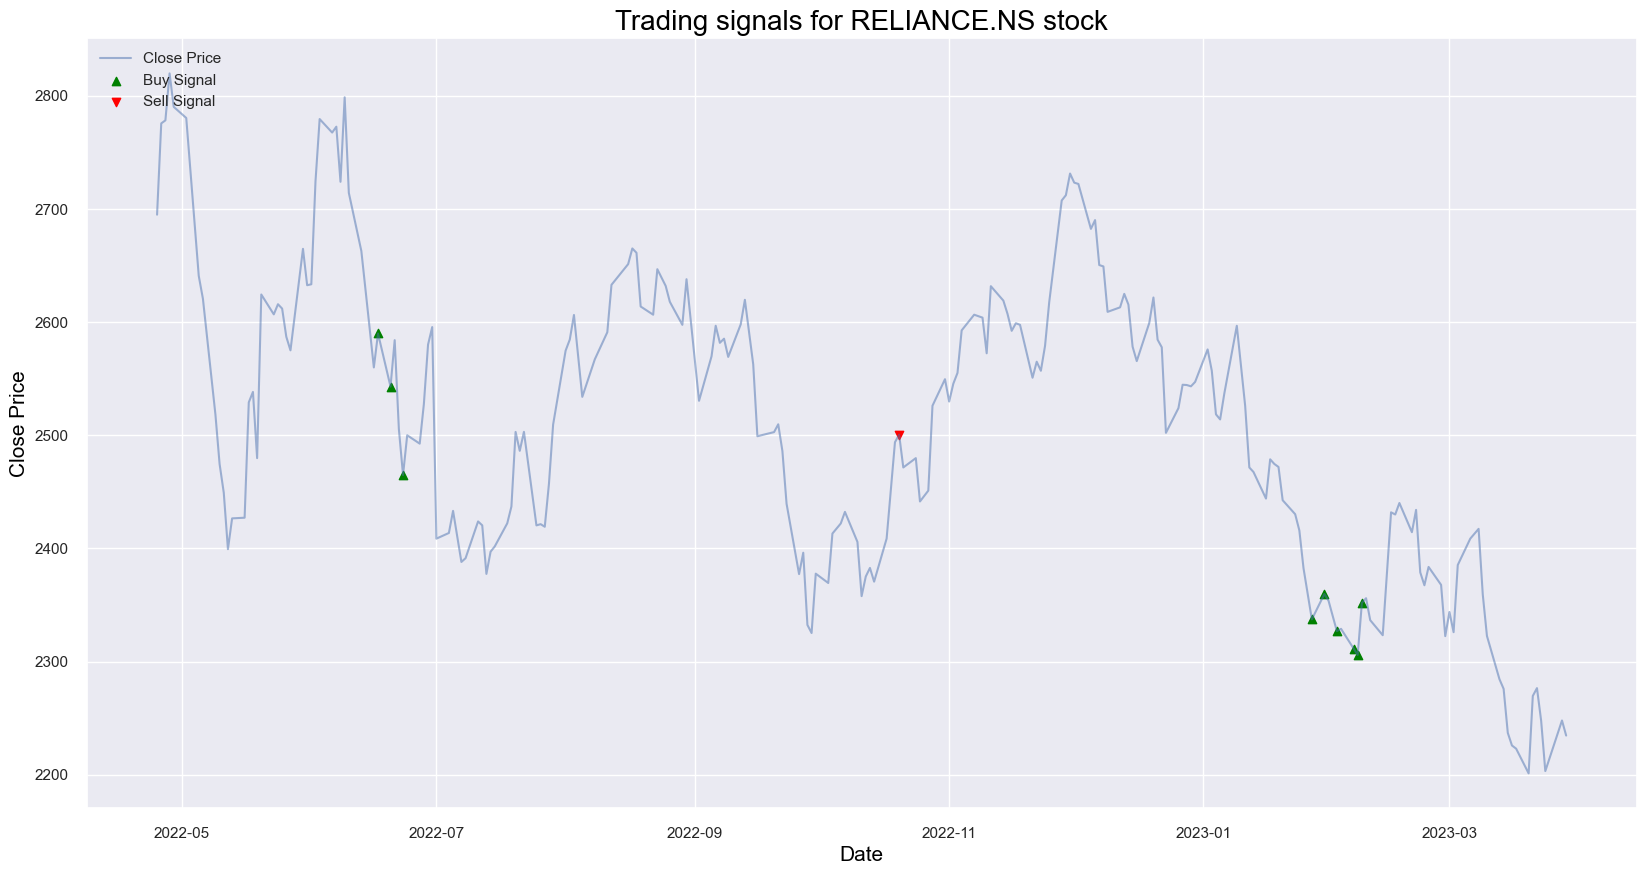

In [480]:
title_txt = "Trading signals for RELIANCE.NS stock"
mfi_buy_sell_plot()

### 5.2.3 Stochastic Oscillator

The stochastic oscillator is a momentum indicator comparing the closing price of a security to the range of its prices over a certain period of time and is one of the best-known momentum indicators along with RSI and MACD.

The intuition is that in a market trending upward, prices will close near the high, and in a market trending downward, prices close near the low.

The stochastic oscillator is plotted within a range of zero and 100. The default parameters are an overbought zone of 80, an oversold zone of 20 and well-used lookbacks period of 14 and 5 which can be used simultaneously. The oscillator has two lines, the %K and %D, where the former measures momentum and the latter measures the moving average of the former. The %D line is more important of the two indicators and tends to produce better trading signals which are created when the %K crosses through the %D.

In [481]:
RELIANCEINDUSTRY_so = RELIANCEINDUSTRY.copy()
RELIANCEINDUSTRY_so

Open         High          Low        Close    Adj Close  \
Date                                                                          
2007-04-02   335.569153   336.510223   323.248413   325.403015   291.745697   
2007-04-03   327.025116   333.340271   324.300964   332.040100   297.696259   
2007-04-04   333.835571   339.023895   333.761261   337.612274   302.692047   
2007-04-05   337.550354   337.996124   334.875702   336.522614   301.715179   
2007-04-09   338.045654   343.741669   337.302704   342.825348   307.365936   
...                 ...          ...          ...          ...          ...   
2023-03-23  2268.000000  2269.899902  2243.050049  2247.800049  2247.800049   
2023-03-24  2245.250000  2250.000000  2198.000000  2203.300049  2203.300049   
2023-03-27  2217.500000  2254.000000  2200.199951  2237.550049  2237.550049   
2023-03-28  2245.000000  2256.500000  2237.000000  2248.000000  2248.000000   
2023-03-29  2239.000000  2244.800049  2211.100098  2234.699951  2234.699951   

              Volume  
Date                  
2007-04-02  13286092  
2007-04-03  10745415  
2007-04-04   8035662  
2007-04-05   4899877  
2007-04-09   4489883  
...              ...  
2023-03-23   7499082  
2023-03-24   5711497  
2023-03-27   6486068  
2023-03-28   5804018  
2023-03-29   8678073  

[3947 rows x 6 columns]

The stochastic oscillator is calculated using the following formula:

%K = 100(C – L14)/(H14 – L14)

Where:

C = the most recent closing price

L14 = the low of the 14 previous trading sessions

H14 = the highest price traded during the same 14-day period

%K= the current market rate for the currency pair

%D = 3-period moving average of %K

In [482]:
# In this implementation there are 3 possible states – long, short, flat (i.e. no position).

#Create the "L14" column in the DataFrame
RELIANCEINDUSTRY_so['L14'] = RELIANCEINDUSTRY_so['Low'].rolling(window=14).min()

#Create the "H14" column in the DataFrame
RELIANCEINDUSTRY_so['H14'] = RELIANCEINDUSTRY_so['High'].rolling(window=14).max()

#Create the "%K" column in the DataFrame
RELIANCEINDUSTRY_so['%K'] = 100*((RELIANCEINDUSTRY_so['Close'] - RELIANCEINDUSTRY_so['L14']) / (RELIANCEINDUSTRY_so['H14'] - RELIANCEINDUSTRY_so['L14']) )

#Create the "%D" column in the DataFrame
RELIANCEINDUSTRY_so['%D'] = RELIANCEINDUSTRY_so['%K'].rolling(window=3).mean()

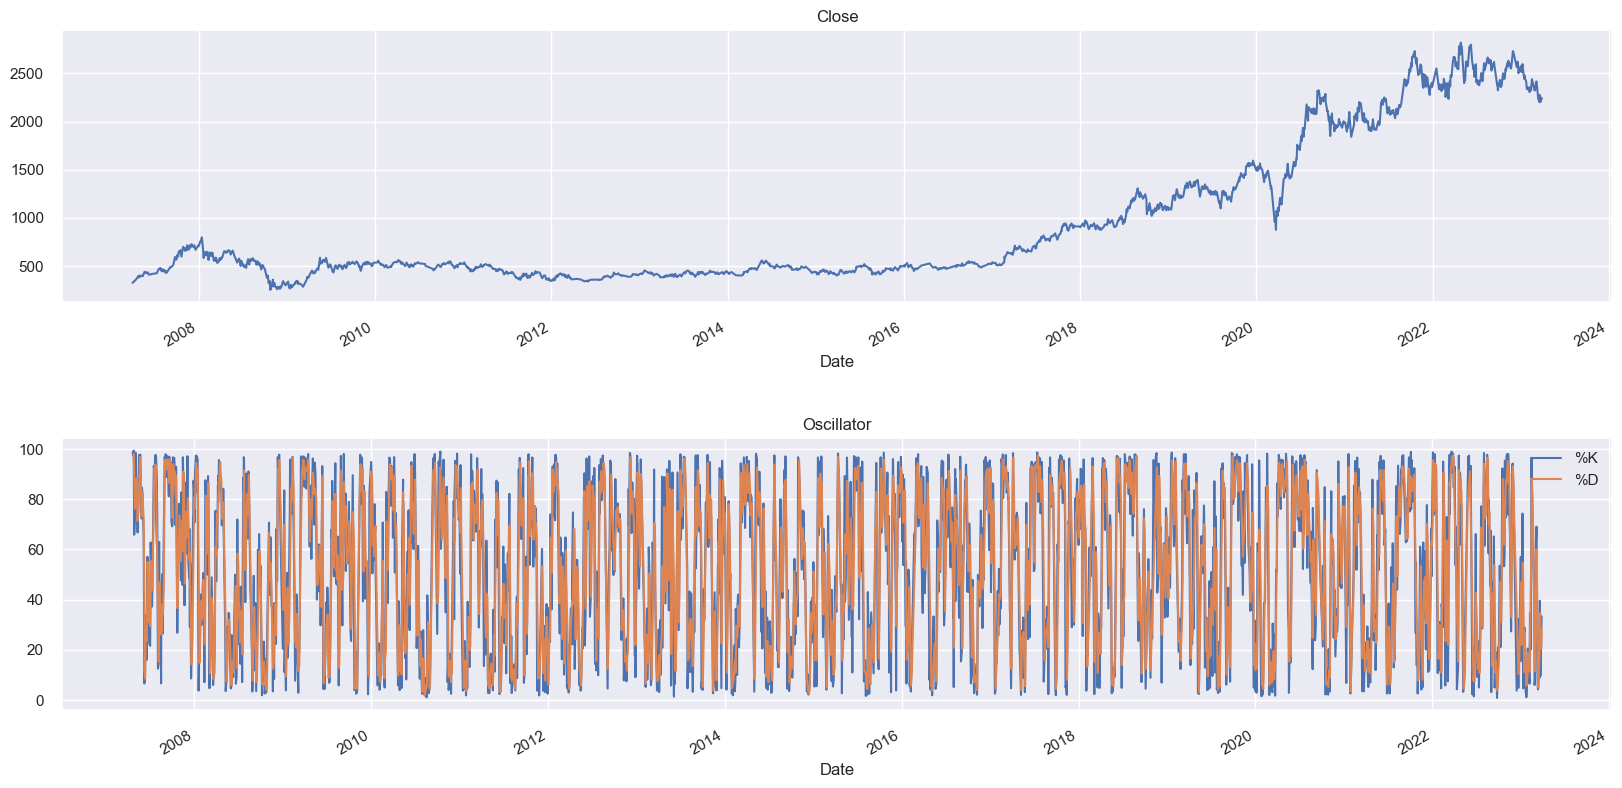

In [483]:
#create a plot (with 2 subplots) showing the RELIANCEINDUSTRY.NS price over time, along with a visual representation of the Stochastic Oscillator.

fig, axes = plt.subplots(nrows=2, ncols=1,figsize=(20,10))
fig.subplots_adjust(hspace=0.5)

RELIANCEINDUSTRY_so['Close'].plot(ax=axes[0]); axes[0].set_title('Close')
RELIANCEINDUSTRY_so[['%K','%D']].plot(ax=axes[1]); axes[1].set_title('Oscillator');

In [484]:
#Create a column in the DataFrame showing "TRUE" if sell entry signal is given and "FALSE" otherwise. 
#A sell is initiated when the %K line crosses down through the %D line and the value of the oscillator is above 80 
RELIANCEINDUSTRY_so['Sell Entry'] = ((RELIANCEINDUSTRY_so['%K'] < RELIANCEINDUSTRY_so['%D']) & (RELIANCEINDUSTRY_so['%K'].shift(1) > RELIANCEINDUSTRY_so['%D'].shift(1))) & (RELIANCEINDUSTRY_so['%D'] > 80) 

#Create a column in the DataFrame showing "TRUE" if sell exit signal is given and "FALSE" otherwise. 
#A sell exit signal is given when the %K line crosses back up through the %D line 
RELIANCEINDUSTRY_so['Sell Exit'] = ((RELIANCEINDUSTRY_so['%K'] > RELIANCEINDUSTRY_so['%D']) & (RELIANCEINDUSTRY_so['%K'].shift(1) < RELIANCEINDUSTRY_so['%D'].shift(1))) 

#create a placeholder column to populate with short positions (-1 for short and 0 for flat) using boolean values created above 
RELIANCEINDUSTRY_so['Short'] = np.nan 
RELIANCEINDUSTRY_so.loc[RELIANCEINDUSTRY_so['Sell Entry'],'Short'] = -1 
RELIANCEINDUSTRY_so.loc[RELIANCEINDUSTRY_so['Sell Exit'],'Short'] = 0 

#Set initial position on day 1 to flat 
RELIANCEINDUSTRY_so['Short'][0] = 0 

#Forward fill the position column to represent the holding of positions through time 
RELIANCEINDUSTRY_so['Short'] = RELIANCEINDUSTRY_so['Short'].fillna(method='pad') 

#Create a column in the DataFrame showing "TRUE" if buy entry signal is given and "FALSE" otherwise. 
#A buy is initiated when the %K line crosses up through the %D line and the value of the oscillator is below 20 
RELIANCEINDUSTRY_so['Buy Entry'] = ((RELIANCEINDUSTRY_so['%K'] > RELIANCEINDUSTRY_so['%D']) & (RELIANCEINDUSTRY_so['%K'].shift(1) < RELIANCEINDUSTRY_so['%D'].shift(1))) & (RELIANCEINDUSTRY_so['%D'] < 20) 

#Create a column in the DataFrame showing "TRUE" if buy exit signal is given and "FALSE" otherwise. 
#A buy exit signal is given when the %K line crosses back down through the %D line 
RELIANCEINDUSTRY_so['Buy Exit'] = ((RELIANCEINDUSTRY_so['%K'] < RELIANCEINDUSTRY_so['%D']) & (RELIANCEINDUSTRY_so['%K'].shift(1) > RELIANCEINDUSTRY_so['%D'].shift(1))) 

#create a placeholder column to populate with long positions (1 for long and 0 for flat) using boolean values created above 
RELIANCEINDUSTRY_so['Long'] = np.nan  
RELIANCEINDUSTRY_so.loc[RELIANCEINDUSTRY_so['Buy Entry'],'Long'] = 1  
RELIANCEINDUSTRY_so.loc[RELIANCEINDUSTRY_so['Buy Exit'],'Long'] = 0  

#Set initial position on day 1 to flat 
RELIANCEINDUSTRY_so['Long'][0] = 0  

#Forward fill the position column to represent the holding of positions through time 
RELIANCEINDUSTRY_so['Long'] = RELIANCEINDUSTRY_so['Long'].fillna(method='pad') 

#Add Long and Short positions together to get final strategy position (1 for long, -1 for short and 0 for flat) 
RELIANCEINDUSTRY_so['Position'] = RELIANCEINDUSTRY_so['Long'] + RELIANCEINDUSTRY_so['Short']

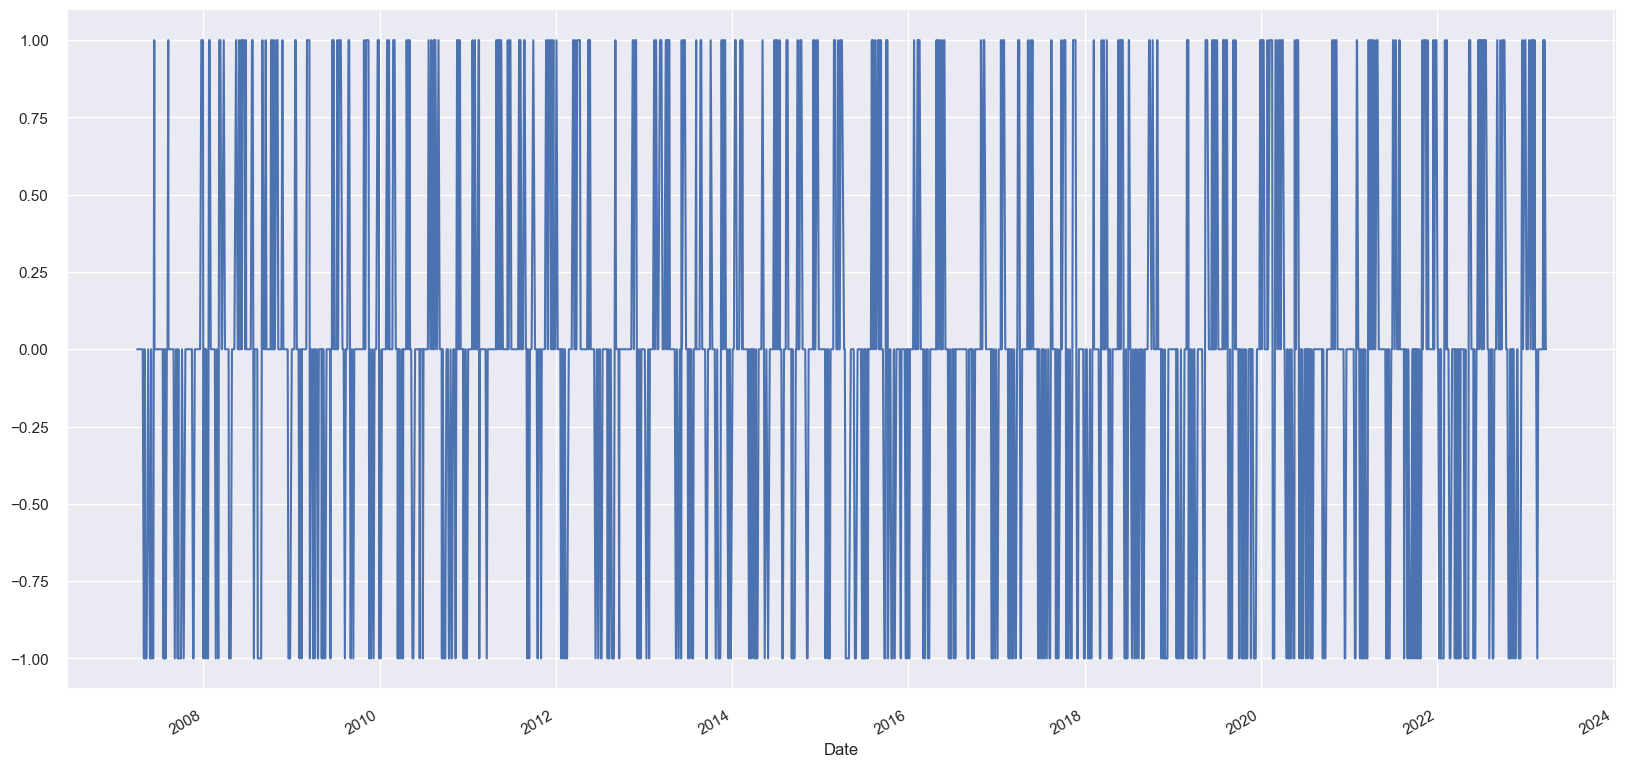

In [485]:
# plot the position through time to get an idea of when we are long and when we are short
RELIANCEINDUSTRY_so['Position'].plot(figsize=(20,10));

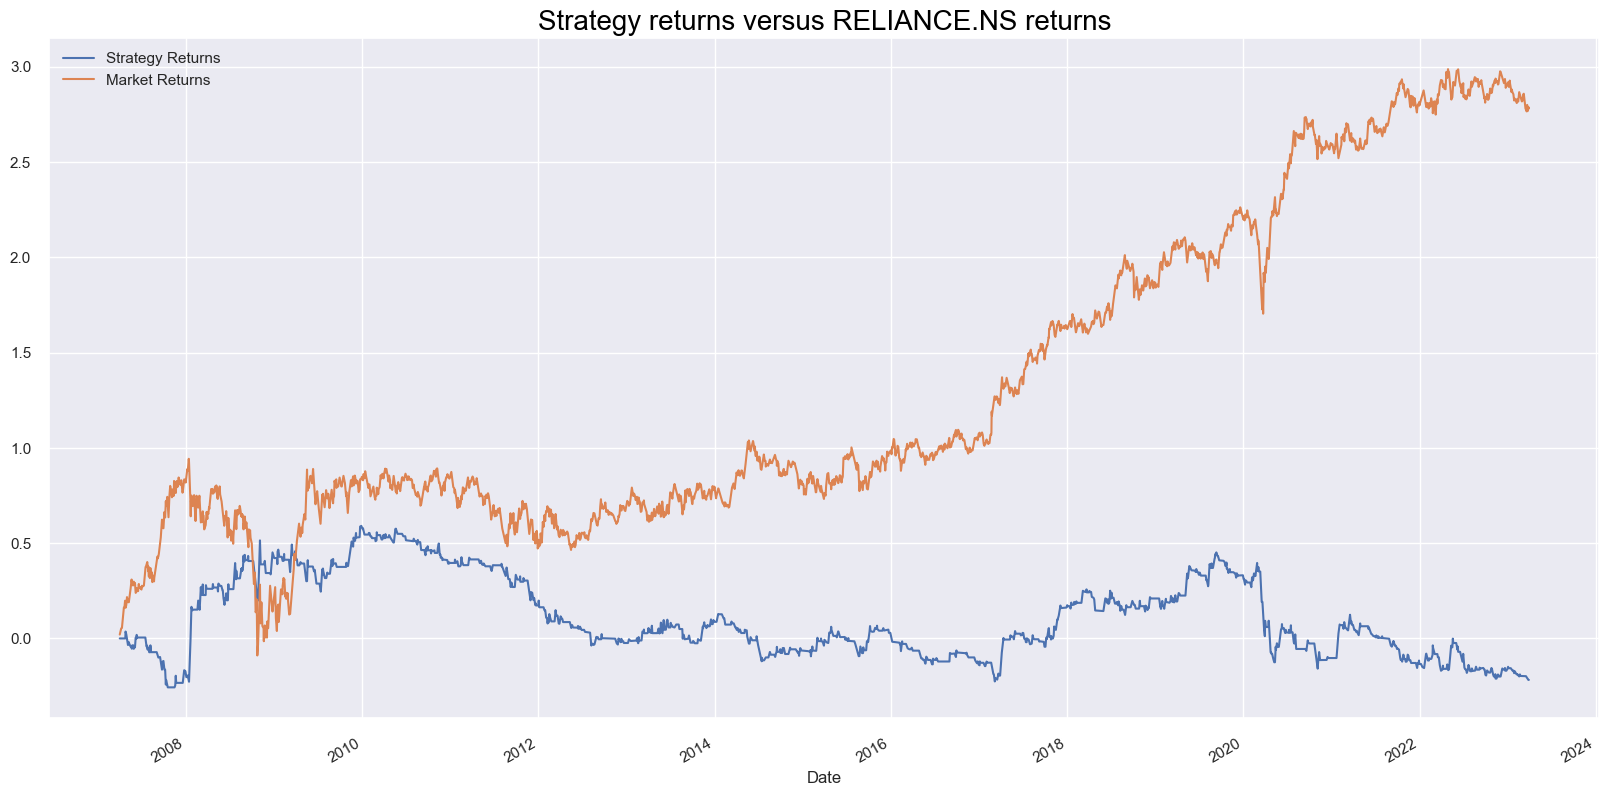

In [486]:
#Set up a column holding the daily RELIANCE.NS returns
RELIANCEINDUSTRY_so['Market Returns'] = RELIANCEINDUSTRY_so['Close'].pct_change()

#Create column for Strategy Returns by multiplying the daily RELIANCE.NS returns by the position that was held at close
#of business the previous day
RELIANCEINDUSTRY_so['Strategy Returns'] = RELIANCEINDUSTRY_so['Market Returns'] * RELIANCEINDUSTRY_so['Position'].shift(1)

#Finally plot the strategy returns versuS RELIANCE.NS returns
RELIANCEINDUSTRY_so[['Strategy Returns','Market Returns']].cumsum().plot(figsize=(20,10));

plt.title('Strategy returns versus RELIANCE.NS returns', color = 'black', fontsize = 20);

The returns are positive at least, but we could have done much better by just buying and holding RELIANCEINDUSTRY.NS stock, which is slightly disappointing.

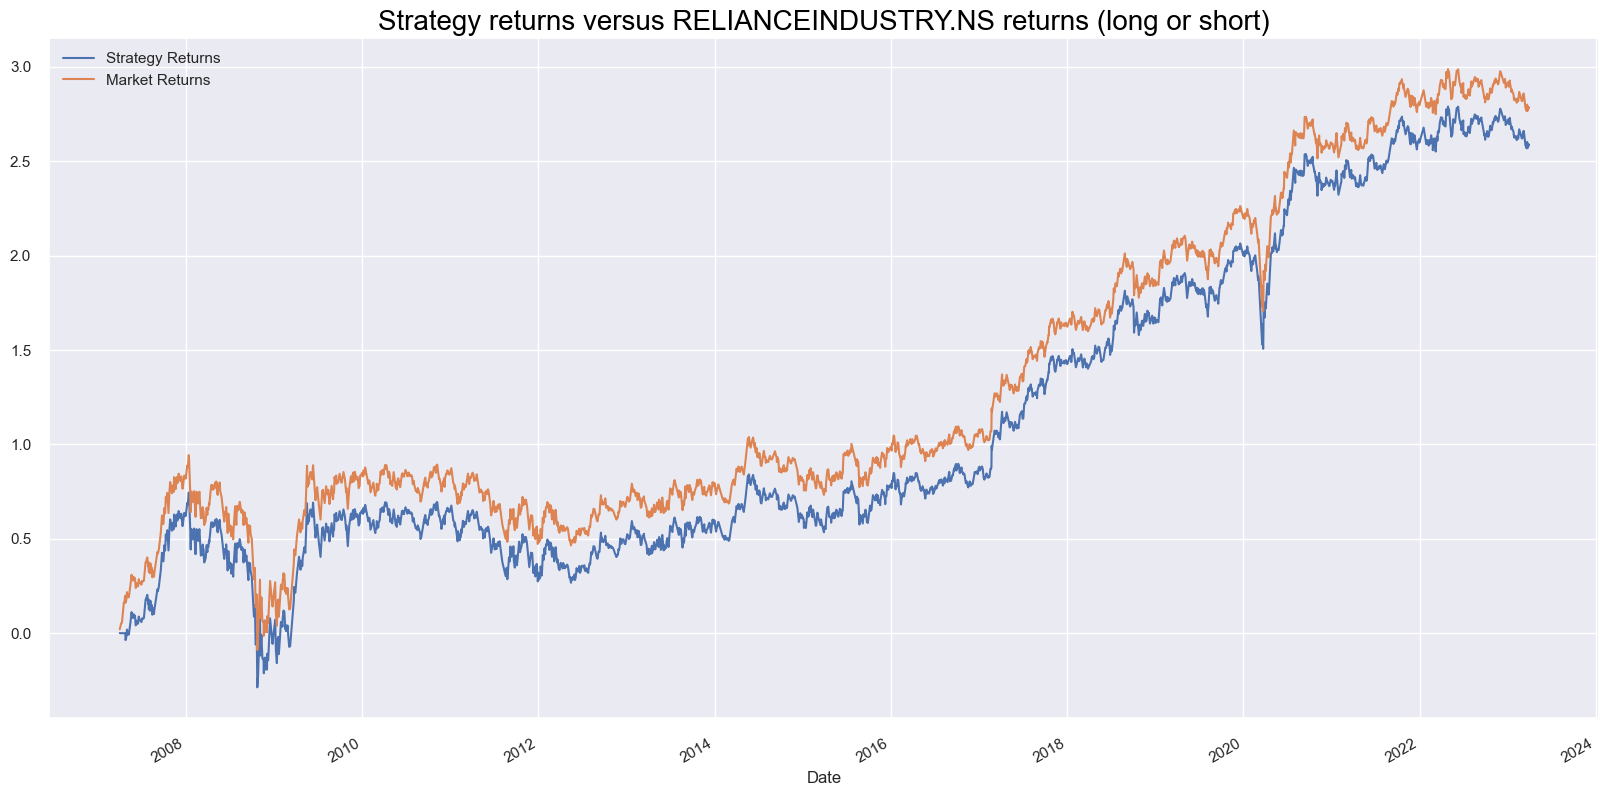

In [487]:
# second implementation of the strategy – the one where we are either long or short

RELIANCEINDUSTRY_so['L14'] = RELIANCEINDUSTRY_so['Low'].rolling(window=14).min()
RELIANCEINDUSTRY_so['H14'] = RELIANCEINDUSTRY_so['High'].rolling(window=14).max()

RELIANCEINDUSTRY_so['%K'] = (RELIANCEINDUSTRY_so['Close'] - RELIANCEINDUSTRY_so['L14']) / (RELIANCEINDUSTRY_so['H14'] - RELIANCEINDUSTRY_so['L14'])
RELIANCEINDUSTRY_so['%D']=RELIANCEINDUSTRY_so['%K'].rolling(window=3).mean()

RELIANCEINDUSTRY_so['Sell Entry'] = ((RELIANCEINDUSTRY_so['%K'] < RELIANCEINDUSTRY_so['%D']) & (RELIANCEINDUSTRY_so['%K'].shift(1) > RELIANCEINDUSTRY_so['%D'].shift(1))) & (RELIANCEINDUSTRY_so['%D'] > 80)

RELIANCEINDUSTRY_so['Buy Entry']=(RELIANCEINDUSTRY_so['%K'] > RELIANCEINDUSTRY_so['%D']) & (RELIANCEINDUSTRY_so['%K'].shift(1) < RELIANCEINDUSTRY_so['%D'].shift(1)) & (RELIANCEINDUSTRY_so['%D'] < 20)

#Create empty "Position" column
RELIANCEINDUSTRY_so['Position'] = np.nan 

#Set position to -1 for sell signals
RELIANCEINDUSTRY_so.loc[RELIANCEINDUSTRY_so['Sell Entry'],'Position'] = -1 

#Set position to -1 for buy signals
RELIANCEINDUSTRY_so.loc[RELIANCEINDUSTRY_so['Buy Entry'],'Position'] = 1 

#Set starting position to flat (i.e. 0)
RELIANCEINDUSTRY_so['Position'].iloc[0] = 0 

#Forward fill the position column to show holding of positions through time
RELIANCEINDUSTRY_so['Position'] = RELIANCEINDUSTRY_so['Position'].fillna(method='ffill')

#Set up a column holding the daily RELIANCEINDUSTRY.NS returns
RELIANCEINDUSTRY_so['Market Returns'] = RELIANCEINDUSTRY_so['Close'].pct_change()

#Create column for Strategy Returns by multiplying the daily RELIANCEINDUSTRYDUSTRY.NS returns by the position that was held at close
#of business the previous day
RELIANCEINDUSTRY_so['Strategy Returns'] = RELIANCEINDUSTRY_so['Market Returns'] * RELIANCEINDUSTRY_so['Position'].shift(1)

#Finally plot the strategy returns versus RELIANCEINDUSTRY.NS returns
RELIANCEINDUSTRY_so[['Strategy Returns','Market Returns']].cumsum().plot(figsize=(20,10));

plt.title('Strategy returns versus RELIANCEINDUSTRY.NS returns (long or short)', color = 'black', fontsize = 20);

This implementation gives a much better outcome for the second half of the back-tested period from 2015-2019.

### 5.2.4  Rate of Change (ROC) 

The ROC indicator is a pure momentum oscillator. The ROC calculation compares the current price with the price "n" periods ago e.g. when we compute the ROC of the daily price with a 9-day lag, we are simply looking at how much, in percentage, the price has gone up (or down) compared to 9 days ago. Like other momentum indicators, ROC has overbought and oversold zones that may be adjusted according to market conditions. 

In [488]:
RELIANCEINDUSTRY_roc = RELIANCEINDUSTRY.copy()
RELIANCEINDUSTRY_roc

Open         High          Low        Close    Adj Close  \
Date                                                                          
2007-04-02   335.569153   336.510223   323.248413   325.403015   291.745697   
2007-04-03   327.025116   333.340271   324.300964   332.040100   297.696259   
2007-04-04   333.835571   339.023895   333.761261   337.612274   302.692047   
2007-04-05   337.550354   337.996124   334.875702   336.522614   301.715179   
2007-04-09   338.045654   343.741669   337.302704   342.825348   307.365936   
...                 ...          ...          ...          ...          ...   
2023-03-23  2268.000000  2269.899902  2243.050049  2247.800049  2247.800049   
2023-03-24  2245.250000  2250.000000  2198.000000  2203.300049  2203.300049   
2023-03-27  2217.500000  2254.000000  2200.199951  2237.550049  2237.550049   
2023-03-28  2245.000000  2256.500000  2237.000000  2248.000000  2248.000000   
2023-03-29  2239.000000  2244.800049  2211.100098  2234.699951  2234.699951   

              Volume  
Date                  
2007-04-02  13286092  
2007-04-03  10745415  
2007-04-04   8035662  
2007-04-05   4899877  
2007-04-09   4489883  
...              ...  
2023-03-23   7499082  
2023-03-24   5711497  
2023-03-27   6486068  
2023-03-28   5804018  
2023-03-29   8678073  

[3947 rows x 6 columns]

In [489]:
RELIANCEINDUSTRY_roc_12mo = RELIANCEINDUSTRY_roc['2022-04-01':'2023-03-31']
RELIANCEINDUSTRY_roc_12mo 

Open         High          Low        Close    Adj Close  \
Date                                                                          
2022-04-01  2636.000000  2665.149902  2622.000000  2655.850098  2647.878174   
2022-04-04  2655.449951  2675.000000  2641.649902  2663.699951  2655.704346   
2022-04-05  2651.100098  2669.899902  2620.699951  2626.050049  2618.167480   
2022-04-06  2587.100098  2634.500000  2587.100098  2619.050049  2611.188477   
2022-04-07  2595.100098  2606.000000  2567.000000  2572.850098  2565.127197   
...                 ...          ...          ...          ...          ...   
2023-03-23  2268.000000  2269.899902  2243.050049  2247.800049  2247.800049   
2023-03-24  2245.250000  2250.000000  2198.000000  2203.300049  2203.300049   
2023-03-27  2217.500000  2254.000000  2200.199951  2237.550049  2237.550049   
2023-03-28  2245.000000  2256.500000  2237.000000  2248.000000  2248.000000   
2023-03-29  2239.000000  2244.800049  2211.100098  2234.699951  2234.699951   

             Volume  
Date                 
2022-04-01  3656408  
2022-04-04  3659307  
2022-04-05  6068663  
2022-04-06  5656703  
2022-04-07  7151632  
...             ...  
2023-03-23  7499082  
2023-03-24  5711497  
2023-03-27  6486068  
2023-03-28  5804018  
2023-03-29  8678073  

[248 rows x 6 columns]

In [490]:
RELIANCEINDUSTRY_roc_12mo['ROC'] = ( RELIANCEINDUSTRY_roc_12mo['Adj Close'] / RELIANCEINDUSTRY_roc_12mo['Adj Close'].shift(9) -1 ) * 100
RELIANCEINDUSTRY_roc_12mo[['Adj Close', 'ROC']]

Adj Close       ROC
Date                             
2022-04-01  2647.878174       NaN
2022-04-04  2655.704346       NaN
2022-04-05  2618.167480       NaN
2022-04-06  2611.188477       NaN
2022-04-07  2565.127197       NaN
...                 ...       ...
2023-03-23  2247.800049 -3.224691
2023-03-24  2203.300049 -3.554386
2023-03-27  2237.550049 -1.687203
2023-03-28  2248.000000  0.489482
2023-03-29  2234.699951  0.395348

[248 rows x 2 columns]

In [491]:
# selection of data - last 100 days

RELIANCEINDUSTRY_roc_100d = RELIANCEINDUSTRY_roc_12mo[-100:]
dates = RELIANCEINDUSTRY_roc_100d.index
price = RELIANCEINDUSTRY_roc_100d['Adj Close']
roc = RELIANCEINDUSTRY_roc_100d['ROC']

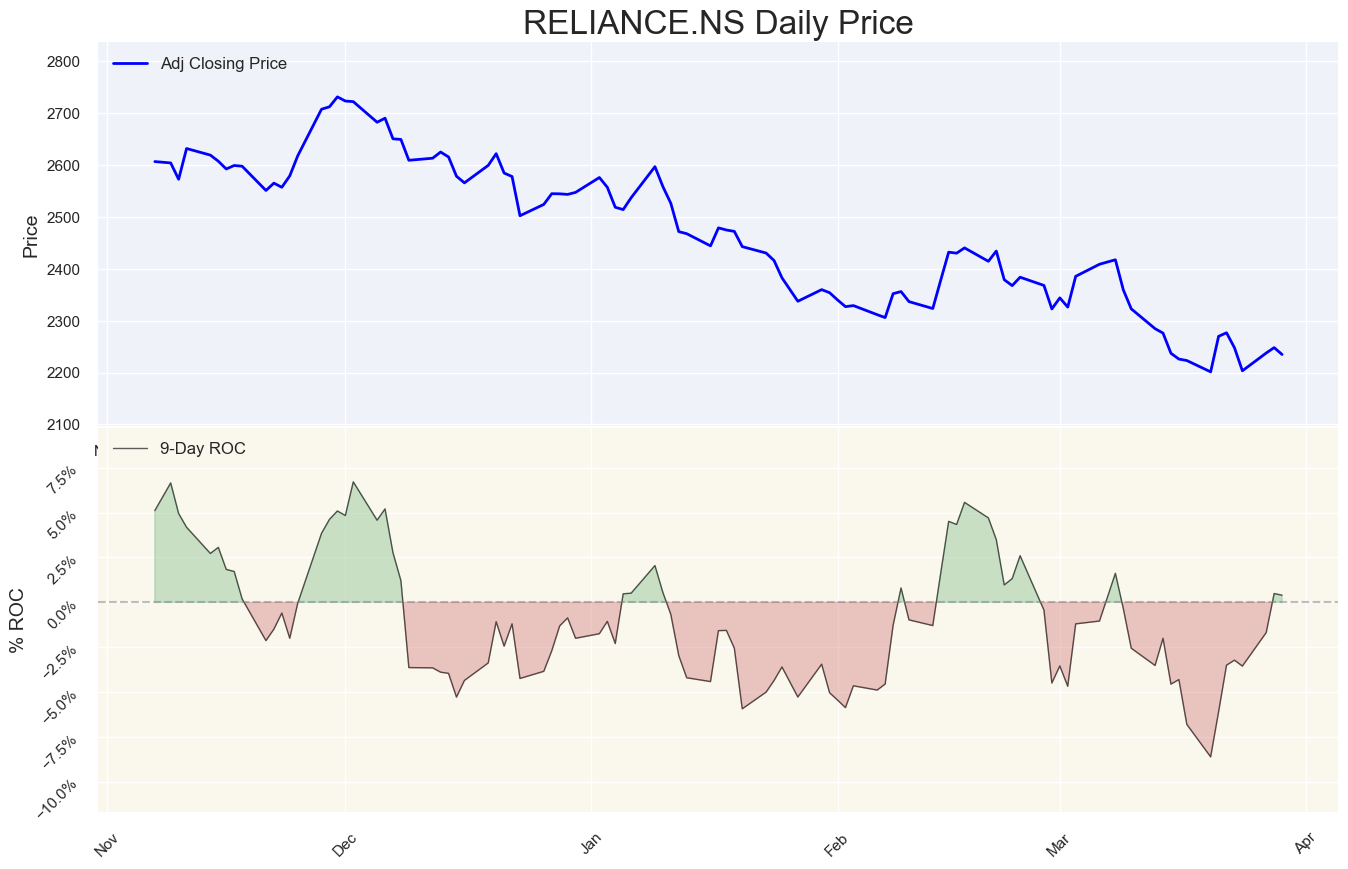

In [492]:
# Plot RELIANCE.NS Adj Close Price and 9-day ROC for last 100 days of 2019

fig = plt.figure(figsize=(16,10))
fig.subplots_adjust(hspace=0)

plt.rcParams.update({'font.size': 14})

# Price subplot
price_ax = plt.subplot(2, 1, 1)
price_ax.plot(dates, price, color='blue', linewidth=2, label="Adj Closing Price")
price_ax.legend(loc="upper left", fontsize=12)
price_ax.set_ylabel("Price")
price_ax.set_title("RELIANCE.NS Daily Price", fontsize=24)

# ROC subplot
roc_ax = plt.subplot(2, 1, 2, sharex = price_ax)
roc_ax.plot(roc, color='k', linewidth = 1, alpha=0.7, label="9-Day ROC")
roc_ax.legend(loc="upper left", fontsize=12)
roc_ax.set_ylabel("% ROC")

# Adding a horizontal line at the zero level in the ROC subplot:
roc_ax.axhline(0, color = (.5, .5, .5), linestyle = '--', alpha = 0.5)

# Filling the areas between the indicator and the level 0 line:
roc_ax.fill_between(dates, 0, roc, where = (roc >= 0), color='g', alpha=0.3, interpolate=True)
roc_ax.fill_between(dates, 0, roc, where = (roc  < 0), color='r', alpha=0.3, interpolate=True)

# Formatting the date labels
roc_ax.xaxis.set_major_formatter(DateFormatter('%b'))

# Formatting the labels on the y axis for ROC:
roc_ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter())

# Adding a grid to both subplots:
# price_ax.grid(b=True, linestyle='--', alpha=0.5)
# roc_ax.grid(b=True, linestyle='--', alpha=0.5)

# Setting a background color for the both subplots:
price_ax.set_facecolor((.94,.95,.98))
roc_ax.set_facecolor((.98,.97,.93))

# Adding margins around the plots:
price_ax.margins(0.05, 0.2)
roc_ax.margins(0.05, 0.2)

# Hiding the tick marks from the horizontal and vertical axis:
price_ax.tick_params(left=False, bottom=False)
roc_ax.tick_params(left=False, bottom=False, labelrotation=45)

# Hiding all the spines for the price subplot:
for s in price_ax.spines.values():
    s.set_visible(False)
# Hiding all the spines for the ROC subplot:
for s in roc_ax.spines.values():
    s.set_visible(False)

# To better separate the two subplots, we reinstate a spine in between them
roc_ax.spines['top'].set_visible(True)
roc_ax.spines['top'].set_linewidth(1.5)

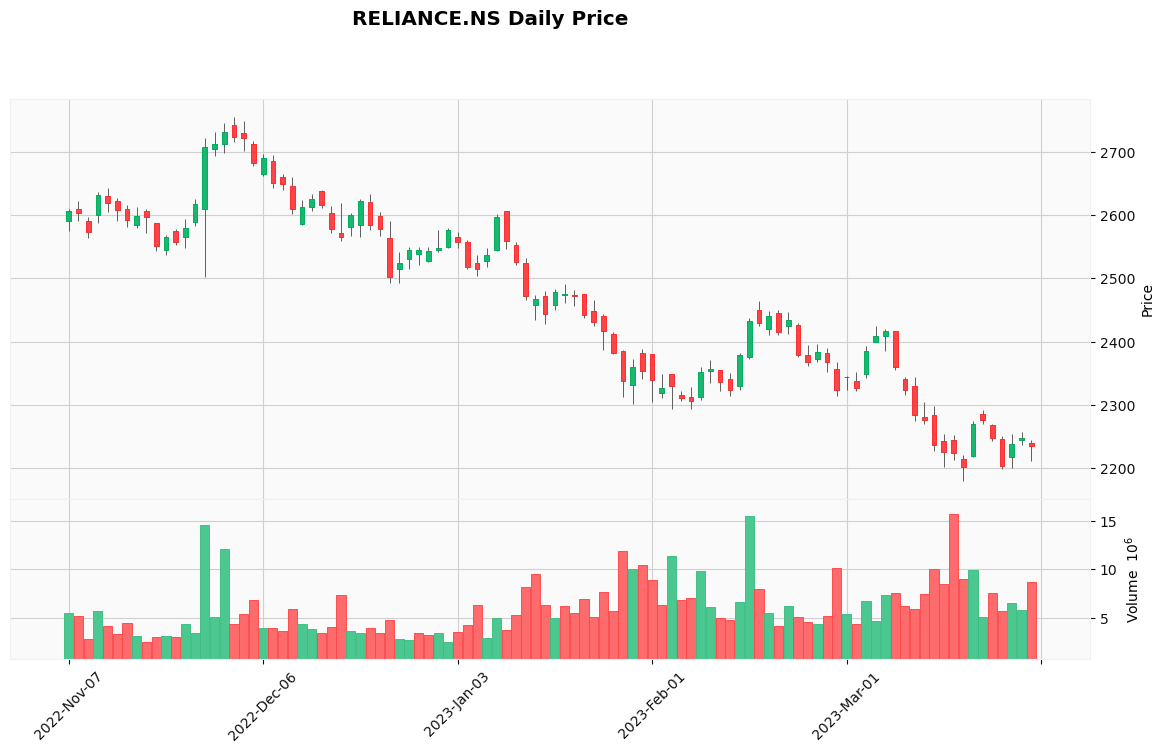

In [493]:
# Candlestick and volume plot for same time frame

mpf.plot(RELIANCEINDUSTRY_roc_100d, type='candle',  style='yahoo', figsize=(15,8),  title="RELIANCE.NS Daily Price", volume=True)


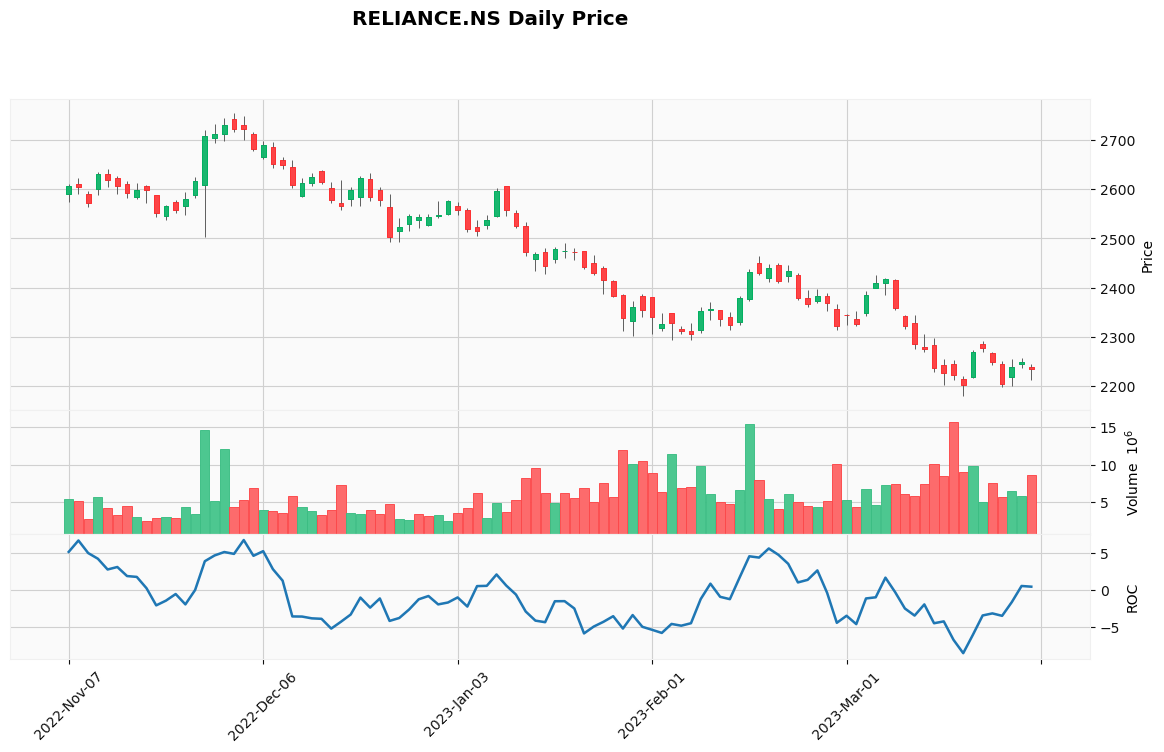

In [494]:
# Combined Candlestick, ROC and Volume plot

# We create an additional plot planing it on the third panel
roc_plot = mpf.make_addplot(roc, panel=2, ylabel='ROC')

#We pass the additional plot using the addplot parameter
mpf.plot(RELIANCEINDUSTRY_roc_100d, type='candle',  style='yahoo', figsize=(15,8), addplot=roc_plot, title="RELIANCE.NS Daily Price", volume=True)

## 5.3 Volatility trading strategies

Volatility trading involves predicting the stability of an asset’s value. Instead of trading on the price rising or falling, traders take a position on whether it will move in any direction.

### 5.3.1 Bollinger Bands

A Bollinger Band is a volatility indicator based on based on the correlation between the normal distribution and stock price and can be used to draw support and resistance curves. It is defined by a set of lines plotted two standard deviations (positively and negatively) away from a simple moving average (SMA) of the security's price, but can be adjusted to user preferences.

By default it calculates a 20-period SMA (the middle band), an upper band two standard deviations above the the moving average and a lower band two standard deviations below it.

If the price moves above the upper band this could indicate a good time to sell, and if it moves below the lower band it could be a good time to buy. 

Whereas the RSI can only be used as a confirming factor inside a ranging market, not a trending market, by using Bollinger bands we can calculate the widening variable, or moving spread between the upper and the lower bands, that tells us if prices are about to trend and whether the RSI signals might not be that reliable.

Despite 90% of the price action happening between the bands, however, a breakout is not necessarily a trading signal as it provides no clue as to the direction and extent of future price movement.

In [495]:
RELIANCEINDUSTRY_12mo

Open         High          Low        Close    Adj Close  \
Date                                                                          
2022-04-01  2636.000000  2665.149902  2622.000000  2655.850098  2647.878174   
2022-04-04  2655.449951  2675.000000  2641.649902  2663.699951  2655.704346   
2022-04-05  2651.100098  2669.899902  2620.699951  2626.050049  2618.167480   
2022-04-06  2587.100098  2634.500000  2587.100098  2619.050049  2611.188477   
2022-04-07  2595.100098  2606.000000  2567.000000  2572.850098  2565.127197   
...                 ...          ...          ...          ...          ...   
2023-03-23  2268.000000  2269.899902  2243.050049  2247.800049  2247.800049   
2023-03-24  2245.250000  2250.000000  2198.000000  2203.300049  2203.300049   
2023-03-27  2217.500000  2254.000000  2200.199951  2237.550049  2237.550049   
2023-03-28  2245.000000  2256.500000  2237.000000  2248.000000  2248.000000   
2023-03-29  2239.000000  2244.800049  2211.100098  2234.699951  2234.699951   

             Volume  
Date                 
2022-04-01  3656408  
2022-04-04  3659307  
2022-04-05  6068663  
2022-04-06  5656703  
2022-04-07  7151632  
...             ...  
2023-03-23  7499082  
2023-03-24  5711497  
2023-03-27  6486068  
2023-03-28  5804018  
2023-03-29  8678073  

[248 rows x 6 columns]

In [496]:
RELIANCEINDUSTRY_12mo_bb = RELIANCEINDUSTRY_12mo.copy()

In [497]:
RELIANCEINDUSTRY_12mo_bb

Open         High          Low        Close    Adj Close  \
Date                                                                          
2022-04-01  2636.000000  2665.149902  2622.000000  2655.850098  2647.878174   
2022-04-04  2655.449951  2675.000000  2641.649902  2663.699951  2655.704346   
2022-04-05  2651.100098  2669.899902  2620.699951  2626.050049  2618.167480   
2022-04-06  2587.100098  2634.500000  2587.100098  2619.050049  2611.188477   
2022-04-07  2595.100098  2606.000000  2567.000000  2572.850098  2565.127197   
...                 ...          ...          ...          ...          ...   
2023-03-23  2268.000000  2269.899902  2243.050049  2247.800049  2247.800049   
2023-03-24  2245.250000  2250.000000  2198.000000  2203.300049  2203.300049   
2023-03-27  2217.500000  2254.000000  2200.199951  2237.550049  2237.550049   
2023-03-28  2245.000000  2256.500000  2237.000000  2248.000000  2248.000000   
2023-03-29  2239.000000  2244.800049  2211.100098  2234.699951  2234.699951   

             Volume  
Date                 
2022-04-01  3656408  
2022-04-04  3659307  
2022-04-05  6068663  
2022-04-06  5656703  
2022-04-07  7151632  
...             ...  
2023-03-23  7499082  
2023-03-24  5711497  
2023-03-27  6486068  
2023-03-28  5804018  
2023-03-29  8678073  

[248 rows x 6 columns]

In [498]:
#Get the time period (20 days)
period = 20
# Calculate the 20 Day Simple Moving Average, Std Deviation, Upper Band and Lower Band
#Calculating the Simple Moving Average
RELIANCEINDUSTRY_12mo_bb['SMA'] = RELIANCEINDUSTRY_12mo_bb['Close'].rolling(window=period).mean()
# Get the standard deviation
RELIANCEINDUSTRY_12mo_bb['STD'] = RELIANCEINDUSTRY_12mo_bb['Close'].rolling(window=period).std()
#Calculate the Upper Bollinger Band
RELIANCEINDUSTRY_12mo_bb['Upper'] = RELIANCEINDUSTRY_12mo_bb['SMA'] + (RELIANCEINDUSTRY_12mo_bb['STD'] * 2)
#Calculate the Lower Bollinger Band
RELIANCEINDUSTRY_12mo_bb['Lower'] = RELIANCEINDUSTRY_12mo_bb['SMA'] - (RELIANCEINDUSTRY_12mo_bb['STD'] * 2)
#Create a list of columns to keep
column_list = ['Close', 'SMA', 'Upper', 'Lower']

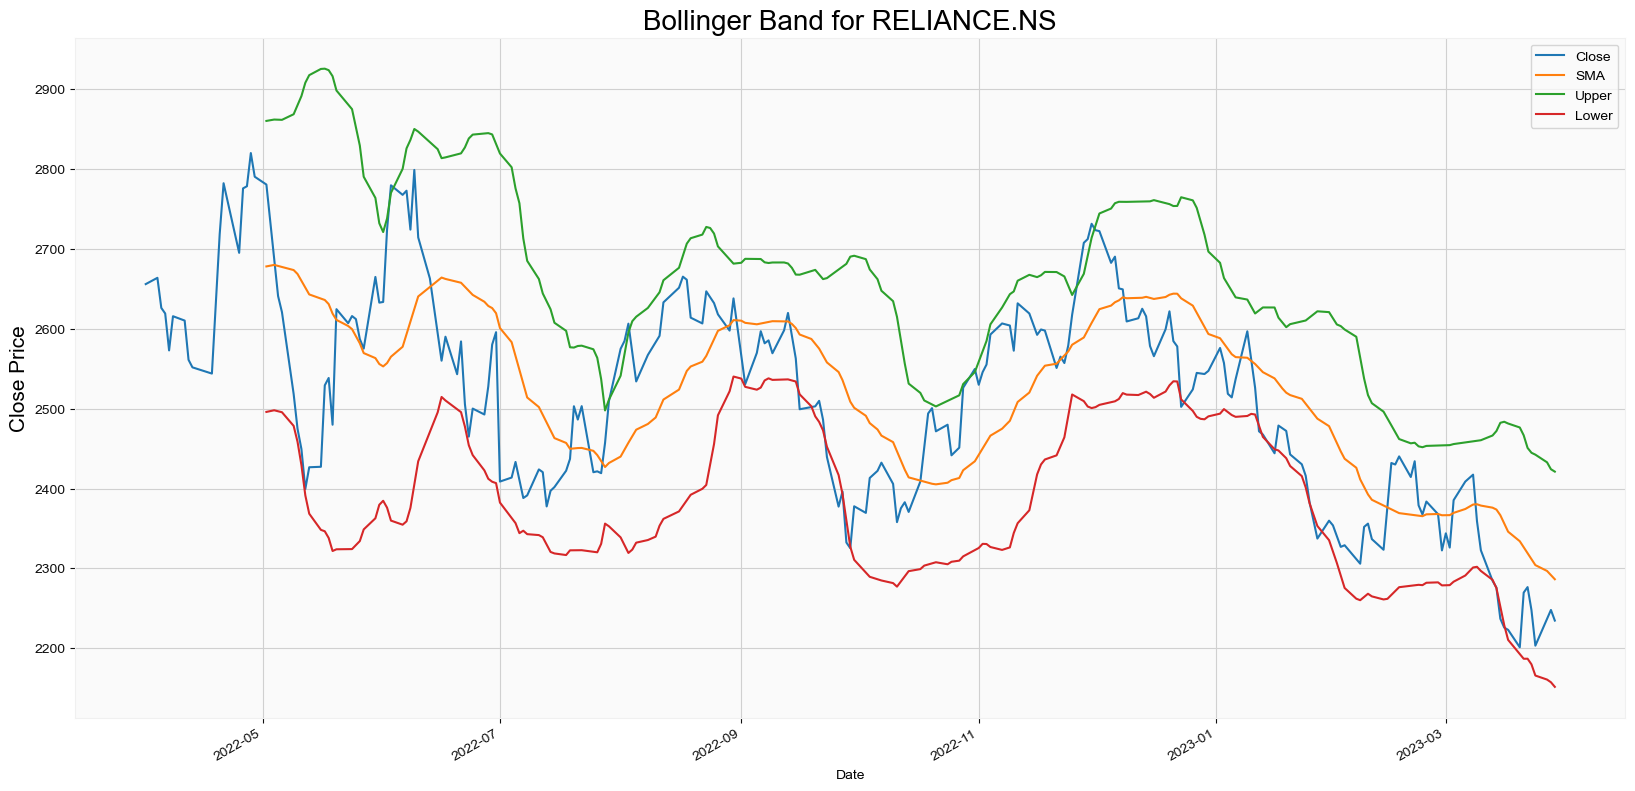

In [499]:
def bb_12mo():
  RELIANCEINDUSTRY_12mo_bb[column_list].plot(figsize=(20,10))
  plt.style.use('seaborn')
  plt.title('Bollinger Band for RELIANCE.NS', color = 'black', fontsize = 20)
  plt.ylabel('Close Price', color = 'black', fontsize = 15)
  plt.show();

bb_12mo()

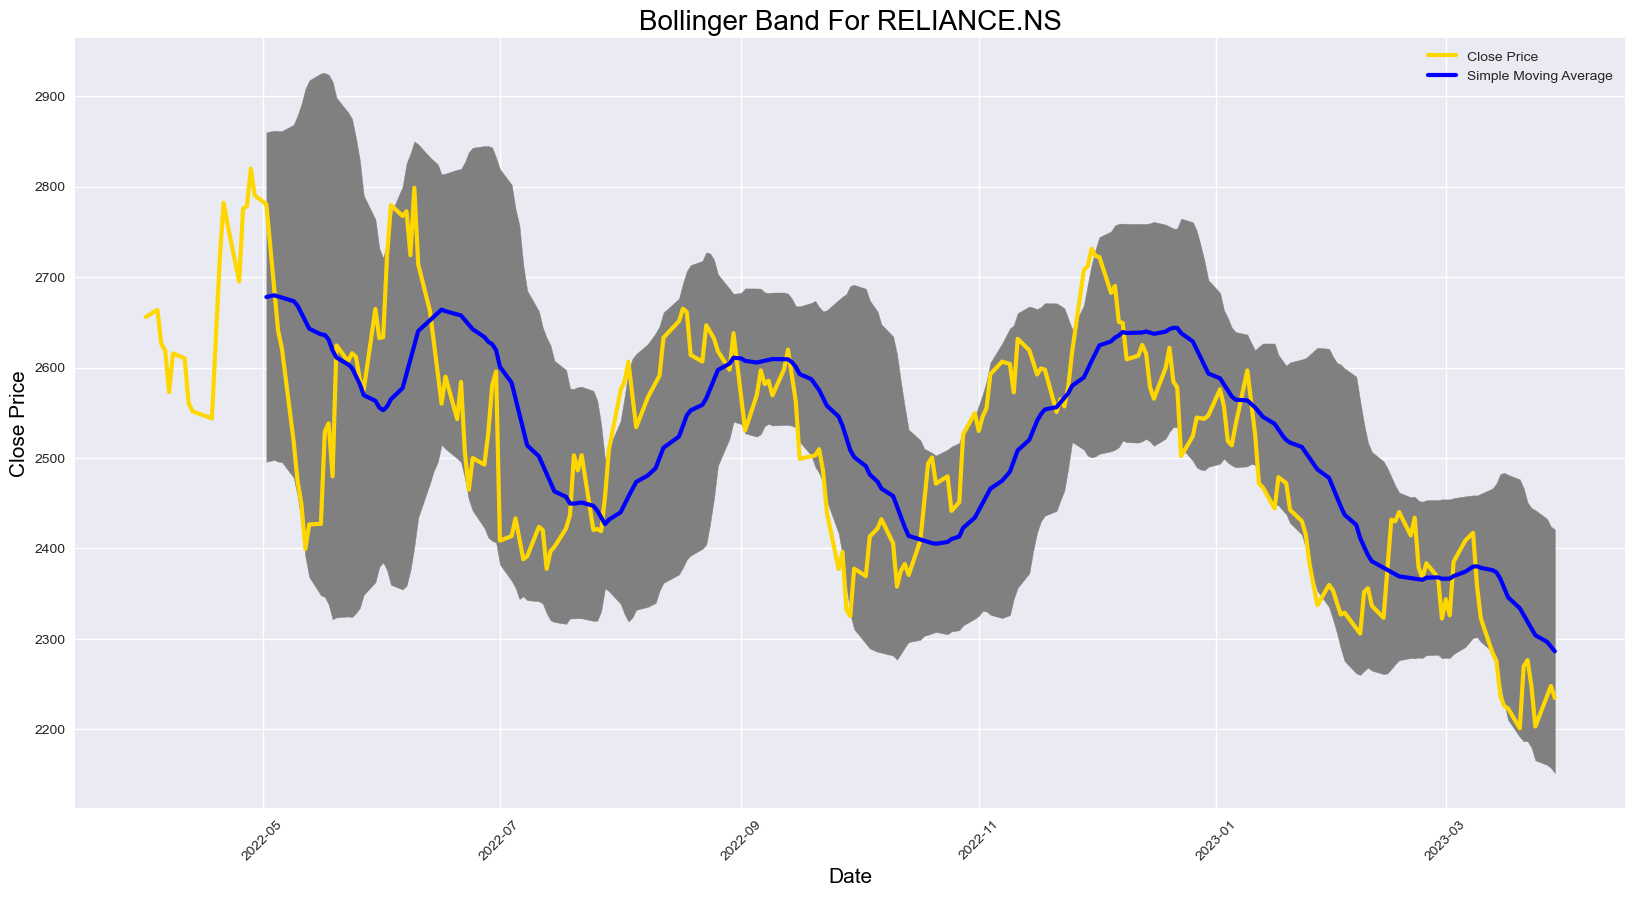

In [500]:
#Plot and shade the area between the two Bollinger bands

def bb_shaded():
  #Get the figure and the figure size
  fig = plt.figure(figsize=(20,10)) 

  #Add the subplot
  ax = fig.add_subplot(1,1,1) #Number of rows, cols, & index

  # Get the index values of the DataFrame
  x_axis = RELIANCEINDUSTRY_12mo_bb.index

  # Plot and shade the area between the upper band and the lower band Grey
  ax.fill_between(x_axis, RELIANCEINDUSTRY_12mo_bb['Upper'], RELIANCEINDUSTRY_12mo_bb['Lower'], color='grey')

  # Plot the Closing Price and Moving Average
  ax.plot(x_axis, RELIANCEINDUSTRY_12mo_bb['Close'], color='gold', lw=3, label = 'Close Price') #lw = line width
  ax.plot(x_axis, RELIANCEINDUSTRY_12mo_bb['SMA'], color='blue', lw=3, label = 'Simple Moving Average')

  # Set the Title & Show the Image
  ax.set_title('Bollinger Band For RELIANCE.NS', color = 'black', fontsize = 20)
  ax.set_xlabel('Date', color = 'black', fontsize = 15)
  ax.set_ylabel('Close Price', color = 'black', fontsize = 15)
  plt.xticks(rotation = 45)
  ax.legend()
  plt.show();

bb_shaded()

In [501]:
#Create a new data frame
new_RELIANCEINDUSTRY_12mo_bb = RELIANCEINDUSTRY_12mo_bb[period-1:]
#Show the new data frame
new_RELIANCEINDUSTRY_12mo_bb

Open         High          Low        Close    Adj Close  \
Date                                                                          
2022-05-02  2762.000000  2805.500000  2758.050049  2780.449951  2772.104004   
2022-05-04  2785.000000  2790.000000  2676.300049  2693.649902  2685.564453   
2022-05-05  2723.500000  2730.000000  2632.000000  2640.899902  2632.972656   
2022-05-06  2612.199951  2659.000000  2593.550049  2620.649902  2612.783447   
2022-05-09  2574.949951  2597.100098  2507.000000  2518.300049  2510.740967   
...                 ...          ...          ...          ...          ...   
2023-03-23  2268.000000  2269.899902  2243.050049  2247.800049  2247.800049   
2023-03-24  2245.250000  2250.000000  2198.000000  2203.300049  2203.300049   
2023-03-27  2217.500000  2254.000000  2200.199951  2237.550049  2237.550049   
2023-03-28  2245.000000  2256.500000  2237.000000  2248.000000  2248.000000   
2023-03-29  2239.000000  2244.800049  2211.100098  2234.699951  2234.699951   

             Volume          SMA        STD        Upper        Lower  
Date                                                                   
2022-05-02  4369022  2677.980017  91.059662  2860.099340  2495.860694  
2022-05-04  8882792  2679.870007  90.968401  2861.806808  2497.933206  
2022-05-05  7942721  2678.730005  91.323875  2861.377756  2496.082254  
2022-05-06  9068448  2678.459998  91.495648  2861.451293  2495.468702  
2022-05-09  8345649  2673.422498  97.514306  2868.451109  2478.393886  
...             ...          ...        ...          ...          ...  
2023-03-23  7499082  2312.340002  66.200612  2444.741227  2179.938778  
2023-03-24  5711497  2304.130005  69.117332  2442.364668  2165.895341  
2023-03-27  6486068  2296.822510  67.978491  2432.779492  2160.865528  
2023-03-28  5804018  2290.830005  66.657391  2424.144786  2157.515224  
2023-03-29  8678073  2286.437500  67.348069  2421.133639  2151.741361  

[229 rows x 10 columns]

In [502]:
# Create a function to get the buy and sell signals
def get_signal_bb(data):
  buy_signal = [] #buy list
  sell_signal = [] #sell list

  for i in range(len(data['Close'])):
      if data['Close'][i] > data['Upper'][i]: #Then you should sell 
        buy_signal.append(np.nan)
        sell_signal.append(data['Close'][i])
      elif data['Close'][i] < data['Lower'][i]: #Then you should buy
        sell_signal.append(np.nan)
        buy_signal.append(data['Close'][i])
      else:
        buy_signal.append(np.nan)
        sell_signal.append(np.nan)
  return (buy_signal, sell_signal)

In [503]:
#Create new columns for the buy and sell signals
new_RELIANCEINDUSTRY_12mo_bb['Buy'] = get_signal_bb(new_RELIANCEINDUSTRY_12mo_bb)[0]
new_RELIANCEINDUSTRY_12mo_bb['Sell'] = get_signal_bb(new_RELIANCEINDUSTRY_12mo_bb)[1]

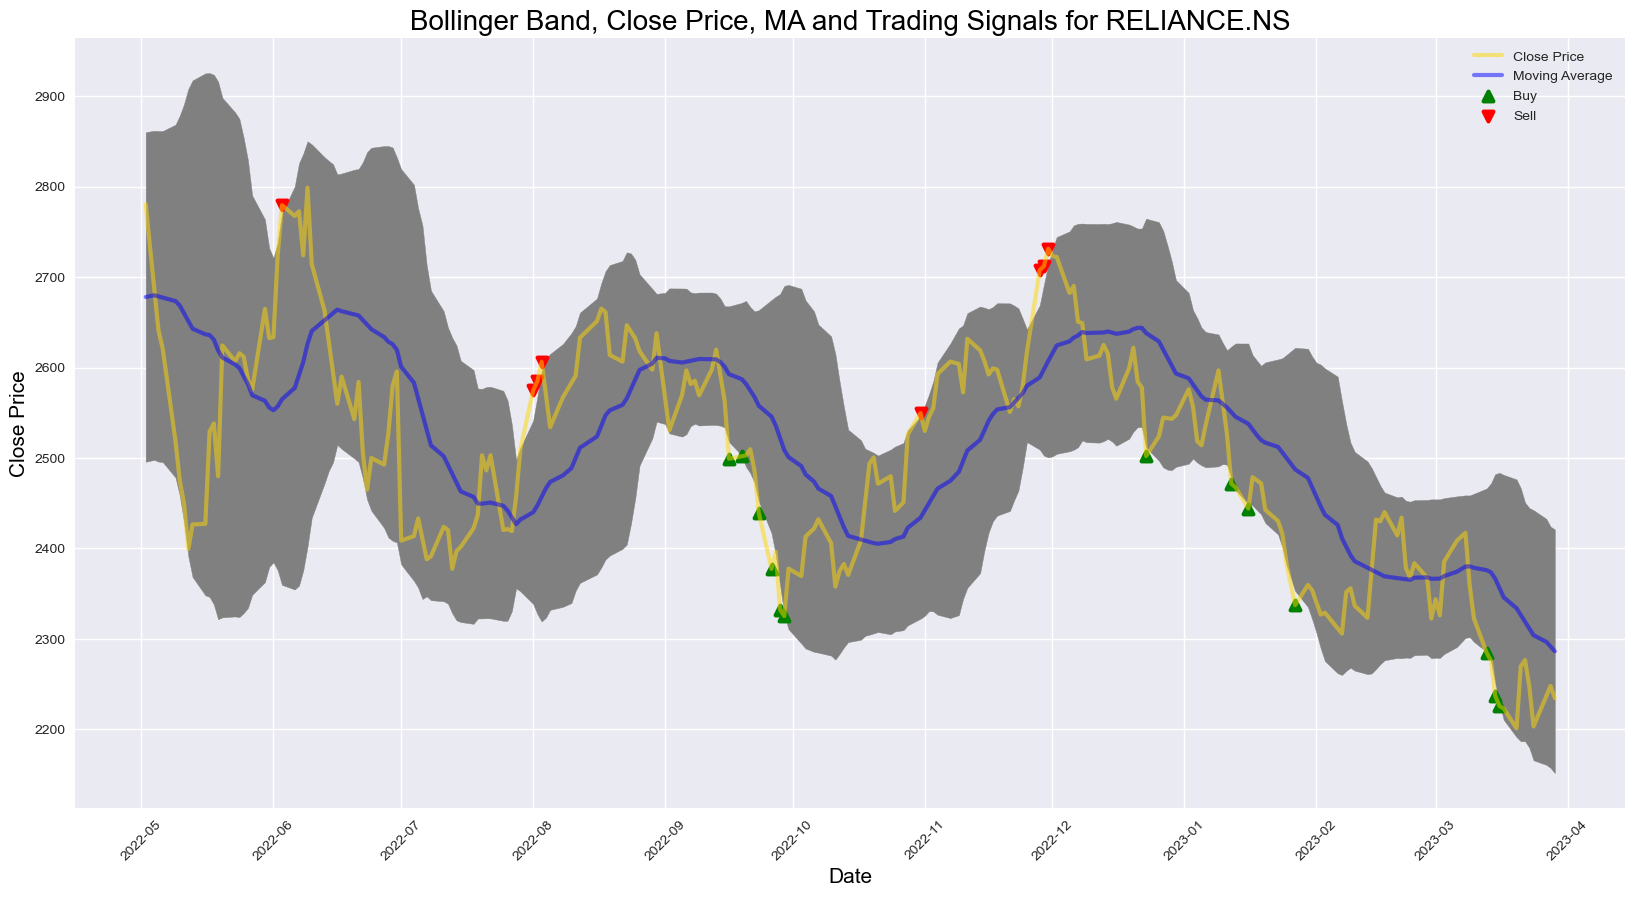

In [504]:
#Plot all of the data

def bb_alldata():
  #Get the figure and the figure size
  fig = plt.figure(figsize=(20,10))

  #Add the subplot
  ax = fig.add_subplot(1,1,1) #Number of rows, cols, & index
  # Get the index values of the DataFrame
  x_axis = new_RELIANCEINDUSTRY_12mo_bb.index
  # Plot and shade the area between the upper band and the lower band Grey

  ax.fill_between(x_axis, new_RELIANCEINDUSTRY_12mo_bb['Upper'], new_RELIANCEINDUSTRY_12mo_bb['Lower'], color='grey')
  # Plot the Closing Price and Moving Average
  ax.plot(x_axis, new_RELIANCEINDUSTRY_12mo_bb['Close'], color='gold', lw=3, label = 'Close Price',alpha = 0.5)
  ax.plot(x_axis, new_RELIANCEINDUSTRY_12mo_bb['SMA'], color='blue', lw=3, label = 'Moving Average',alpha = 0.5)
  ax.scatter(x_axis, new_RELIANCEINDUSTRY_12mo_bb['Buy'] , color='green', lw=3, label = 'Buy',marker = '^', alpha = 1)
  ax.scatter(x_axis, new_RELIANCEINDUSTRY_12mo_bb['Sell'] , color='red', lw=3, label = 'Sell',marker = 'v', alpha = 1)
  # Set the Title & Show the Image
  ax.set_title('Bollinger Band, Close Price, MA and Trading Signals for RELIANCE.NS', color = 'black', fontsize = 20)
  ax.set_xlabel('Date', color = 'black', fontsize = 15)
  ax.set_ylabel('Close Price', color = 'black', fontsize = 15)
  plt.xticks(rotation = 45)
  ax.legend()
  plt.show();

bb_alldata()

The Bollinger Bands technical indicator is an example of a mean reversion strategy. 

### 5.3.2 Mean reversion strategies

In mean reversion algorithmic trading strategies stocks return to their mean and we can exploit when it deviates from that mean.

These strategies usually involve selling into up moves and buying into down moves, a contrarian approach which assumes that the market has become oversold/overbought and prices will revert to their historical trends. This is almost the opposite of trend following where we enter in the direction of the strength and momentum, and momentum strategies such as buying stocks that have been showing an upward trend in hopes that the trend will continue, a continuation approach. 

### Pairs Trading

Pairs Trading is a market neutral trading strategy and a type of statistical arbitrage, which is exploiting statistical properties that we believe can make money if they continue. 

The basic idea is to select two cointegrated stocks which move similarly/are statistically related and deviate from their mean. Then sell the high priced stock and buy the low priced stock where there is a price divergence between the pairs. You make money from a pairs trade when your “long” outperforms your “short”: If your “long” rises more than your “short” or if your “long” falls less than your “short”.

Pairs Trading can be called a mean reversion strategy where we bet that the prices will revert to their historical trends.

In [505]:
# create copy of nifty_stocks stocks to find two cointegrated stocks for pairs trading

nifty_stocks_pairs = nifty_stocks.copy()
nifty_stocks_pairs

BRITANNIA.NS                                                      \
                   Open         High          Low        Close    Adj Close   
Date                                                                          
2007-04-02   124.495003   124.495003   120.620003   121.364998    94.312416   
2007-04-03   121.099998   123.500000   120.114998   122.985001    95.571320   
2007-04-04   123.500000   123.500000   120.500000   122.070000    94.860291   
2007-04-05   122.000000   125.500000   121.500000   123.419998    95.909363   
2007-04-09   124.995003   125.699997   123.610001   123.805000    96.208549   
...                 ...          ...          ...          ...          ...   
2023-03-23  4250.000000  4255.500000  4196.750000  4242.700195  4171.182617   
2023-03-24  4242.000000  4242.000000  4189.850098  4199.950195  4129.152832   
2023-03-27  4224.049805  4245.299805  4198.799805  4214.799805  4143.752441   
2023-03-28  4229.500000  4229.500000  4153.000000  4200.000000  4129.202148   
2023-03-29  4205.000000  4297.950195  4198.950195  4276.200195  4204.117676   

                   BAJAJ-AUTO.NS                                         ...  \
            Volume          Open         High          Low        Close  ...   
Date                                                                     ...   
2007-04-02    9160    590.650024   592.500000   564.500000   576.750000  ...   
2007-04-03   19110    570.025024   584.250000   565.000000   573.299988  ...   
2007-04-04   19790    575.000000   582.500000   571.275024   577.937500  ...   
2007-04-05   17500    575.000000   581.000000   572.000000   576.174988  ...   
2007-04-09   18470    579.462524   587.500000   570.500000   574.349976  ...   
...            ...           ...          ...          ...          ...  ...   
2023-03-23  197372   3902.500000  3912.399902  3853.050049  3862.949951  ...   
2023-03-24  198393   3845.100098  3882.899902  3812.000000  3827.899902  ...   
2023-03-27  283791   3834.949951  3844.300049  3800.000000  3807.550049  ...   
2023-03-28  224554   3821.000000  3833.800049  3769.550049  3791.600098  ...   
2023-03-29  316461   3810.500000  3894.000000  3800.149902  3879.300049  ...   

           HINDPETRO.NS                                     WIPRO.NS  \
                    Low       Close   Adj Close   Volume        Open   
Date                                                                   
2007-04-02    53.244446   53.400002   25.405321   915948  125.910004   
2007-04-03    52.700001   54.166664   25.770063  2760777  116.775002   
2007-04-04    54.022221   54.566666   25.960373   740304  121.050003   
2007-04-05    54.466667   55.799999   26.547134  1305913  124.222504   
2007-04-09    56.111111   56.544445   26.901312  1032282  123.750008   
...                 ...         ...         ...      ...         ...   
2023-03-23   242.000000  242.699997  242.699997  2119676  364.899994   
2023-03-24   238.500000  238.850006  238.850006   988849  363.350006   
2023-03-27   235.050003  236.300003  236.300003  1445949  361.750000   
2023-03-28   230.300003  234.250000  234.250000  1906841  363.000000   
2023-03-29   231.550003  234.050003  234.050003  4312592  358.000000   

                                                                     
                  High         Low       Close   Adj Close   Volume  
Date                                                                 
2007-04-02  126.900009  115.875008  116.718758   99.692268  6225088  
2007-04-03  120.982506  116.718758  120.206253  102.671021  4945408  
2007-04-04  124.290009  120.656258  123.603760  105.572914  7065972  
2007-04-05  125.212509  121.533752  124.335007  106.197495  3919648  
2007-04-09  127.575005  119.700005  126.180008  107.773323  2547102  
...                ...         ...         ...         ...      ...  
2023-03-23  364.899994  360.350006  361.500000  361.500000  4742596  
2023-03-24  366.850006  361.000000  361.750000  361.750000  3953348  
2023

In [506]:
# Concise summary of the dataframe

nifty_stocks_pairs.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3947 entries, 2007-04-02 to 2023-03-29
Data columns (total 90 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   (BRITANNIA.NS, Open)        3947 non-null   float64
 1   (BRITANNIA.NS, High)        3947 non-null   float64
 2   (BRITANNIA.NS, Low)         3947 non-null   float64
 3   (BRITANNIA.NS, Close)       3947 non-null   float64
 4   (BRITANNIA.NS, Adj Close)   3947 non-null   float64
 5   (BRITANNIA.NS, Volume)      3947 non-null   int64  
 6   (BAJAJ-AUTO.NS, Open)       3947 non-null   float64
 7   (BAJAJ-AUTO.NS, High)       3947 non-null   float64
 8   (BAJAJ-AUTO.NS, Low)        3947 non-null   float64
 9   (BAJAJ-AUTO.NS, Close)      3947 non-null   float64
 10  (BAJAJ-AUTO.NS, Adj Close)  3947 non-null   float64
 11  (BAJAJ-AUTO.NS, Volume)     3947 non-null   int64  
 12  (TECHM.NS, Open)            3947 non-null   float64
 13  (TECHM.NS, High

In [507]:
# Descriptive statistics for Nifty50 stocks

nifty_stocks_pairs.describe()

BRITANNIA.NS                                                      \
              Open         High          Low        Close    Adj Close   
count  3947.000000  3947.000000  3947.000000  3947.000000  3947.000000   
mean   1517.979094  1535.310898  1499.304671  1516.587756  1385.287170   
std    1411.950739  1425.665471  1396.264585  1410.319530  1333.638181   
min     107.199997   110.099998    98.025002   109.739998    87.239052   
25%     210.000000   214.709999   207.500000   211.262497   174.397713   
50%    1088.000000  1107.650024  1075.000000  1095.474976   954.196106   
75%    2995.000000  3029.650024  2961.837402  2994.474976  2687.365479   
max    4660.000000  4669.200195  4600.000000  4637.350098  4559.179688   

                    BAJAJ-AUTO.NS                                         ...  \
             Volume          Open         High          Low        Close  ...   
count  3.947000e+03   3947.000000  3947.000000  3947.000000  3947.000000  ...   
mean   2.848790e+05   2175.191952  2201.707106  2147.584408  2173.642770  ...   
std    3.663915e+05   1065.404917  1074.817711  1055.511031  1064.219084  ...   
min    0.000000e+00    131.000000   153.524994   131.000000   150.949997  ...   
25%    5.879300e+04   1448.450012  1464.000000  1427.250000  1445.424988  ...   
50%    2.093240e+05   2310.000000  2339.149902  2281.000000  2312.100098  ...   
75%    3.719875e+05   2932.949951  2960.000000  2897.050049  2926.000000  ...   
max    6.269128e+06   4294.299805  4361.399902  4242.000000  4295.049805  ...   

      HINDPETRO.NS                                             WIPRO.NS  \
               Low        Close    Adj Close        Volume         Open   
count  3947.000000  3947.000000  3947.000000  3.947000e+03  3947.000000   
mean    165.795700   168.568705   121.394790  5.605805e+06   224.575982   
std     107.083227   108.776214    91.705929  4.966958e+06   130.650046   
min      35.111111    36.244446    19.404514  0.000000e+00    45.292503   
25%      67.344444    68.411110    37.357101  2.935640e+06   148.125031   
50%     137.800003   139.622223    85.414391  4.430119e+06   198.000000   
75%     247.025002   251.275002   203.607971  6.840378e+06   243.506310   
max     478.750000   488.350006   338.976257  8.690175e+07   722.750000   

                                                                         
              High          Low        Close    Adj Close        Volume  
count  3947.000000  3947.000000  3947.000000  3947.000000  3.947000e+03  
mean    227.298563   221.585368   224.370836   214.595869  5.636657e+06  
std     131.740390   129.226861   130.352177   133.104488  5.898251e+06  
min      46.113750    40.590000    45.202503    39.168766  0.000000e+00  
25%     149.896896   146.250031   148.074394   132.153152  2.925130e+06  
50%     199.575043   195.375046   197.606293   189.943924  4.304706e+06  
75%     245.949997   240.300003   243.468781   237.214066  6.400022e+06  
max     739.849976   716.000000   721.500000   712.624756  1.303676e+08  

[8 rows x 90 columns]

In [508]:
RELIANCE_historical =  nifty_stocks_pairs['RELIANCE.NS']
BPCL_historical =  nifty_stocks_pairs['BPCL.NS']
HPCL_historical =  nifty_stocks_pairs['HINDPETRO.NS']
BRITANNIA_historical =  nifty_stocks_pairs['BRITANNIA.NS']
NESTLEIND_historical =  nifty_stocks_pairs['NESTLEIND.NS']
HINDUNILVR_historical =  nifty_stocks_pairs['HINDUNILVR.NS']
TECHM_historical =  nifty_stocks_pairs['TECHM.NS']
INFY_historical =  nifty_stocks_pairs['INFY.NS']
WIPRO_historical =  nifty_stocks_pairs['WIPRO.NS']

In [509]:
# DataFrame of the closing price of selected stocks

nifty_stocks_close = pd.DataFrame({
                                "RELIANCE.NS": RELIANCE_historical.Close,
                                "BPCL.NS": BPCL_historical.Close,
                                "HINDPETRO.NS": HPCL_historical.Close,
                                "BRITANNIA.NS": BRITANNIA_historical.Close,
                                "NESTLEIND.NS": NESTLEIND_historical.Close,
                                "HINDUNILVR.NS": HINDUNILVR_historical.Close,
                                "TECHM.NS": TECHM_historical.Close,
                                "INFY.NS": INFY_historical.Close,
                                "WIPRO.NS": WIPRO_historical.Close
                                })
nifty_stocks_close.head()

RELIANCE.NS    BPCL.NS  HINDPETRO.NS  BRITANNIA.NS  NESTLEIND.NS  \
Date                                                                           
2007-04-02   325.403015  48.816666     53.400002    121.364998    527.049988   
2007-04-03   332.040100  49.525002     54.166664    122.985001    527.049988   
2007-04-04   337.612274  49.958332     54.566666    122.070000    527.049988   
2007-04-05   336.522614  50.549999     55.799999    123.419998    527.049988   
2007-04-09   342.825348  52.091667     56.544445    123.805000    527.049988   

            HINDUNILVR.NS    TECHM.NS     INFY.NS    WIPRO.NS  
Date                                                           
2007-04-02     195.699997  335.250000  240.368744  116.718758  
2007-04-03     200.199997  335.712494  245.581253  120.206253  
2007-04-04     197.800003  342.975006  249.287506  123.603760  
2007-04-05     200.000000  344.000000  249.037506  124.335007  
2007-04-09     204.649994  353.725006  255.943756  126.180008

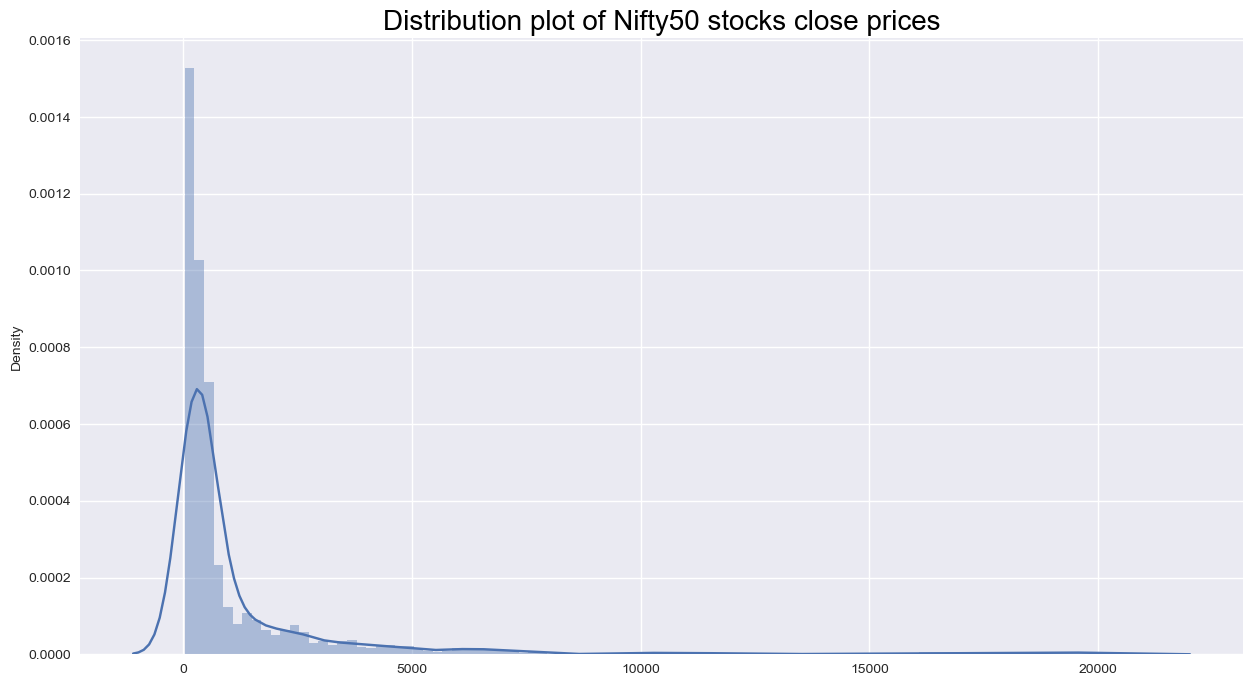

In [510]:
# Distribution plot of close prices

def dist_plt():
  plt.style.use('seaborn')
  plt.figure(figsize=(15, 8))
  plt.title("Distribution plot of Nifty50 stocks close prices", color = 'black', fontsize = 20)
  sns.distplot(nifty_stocks_close, bins=100, kde=True);

dist_plt()

The distribution of prices is always positive. It has a very long tail and a high peak near zero. This is because we are looking at prices from different stocks with diverse closing prices over 10 years. 

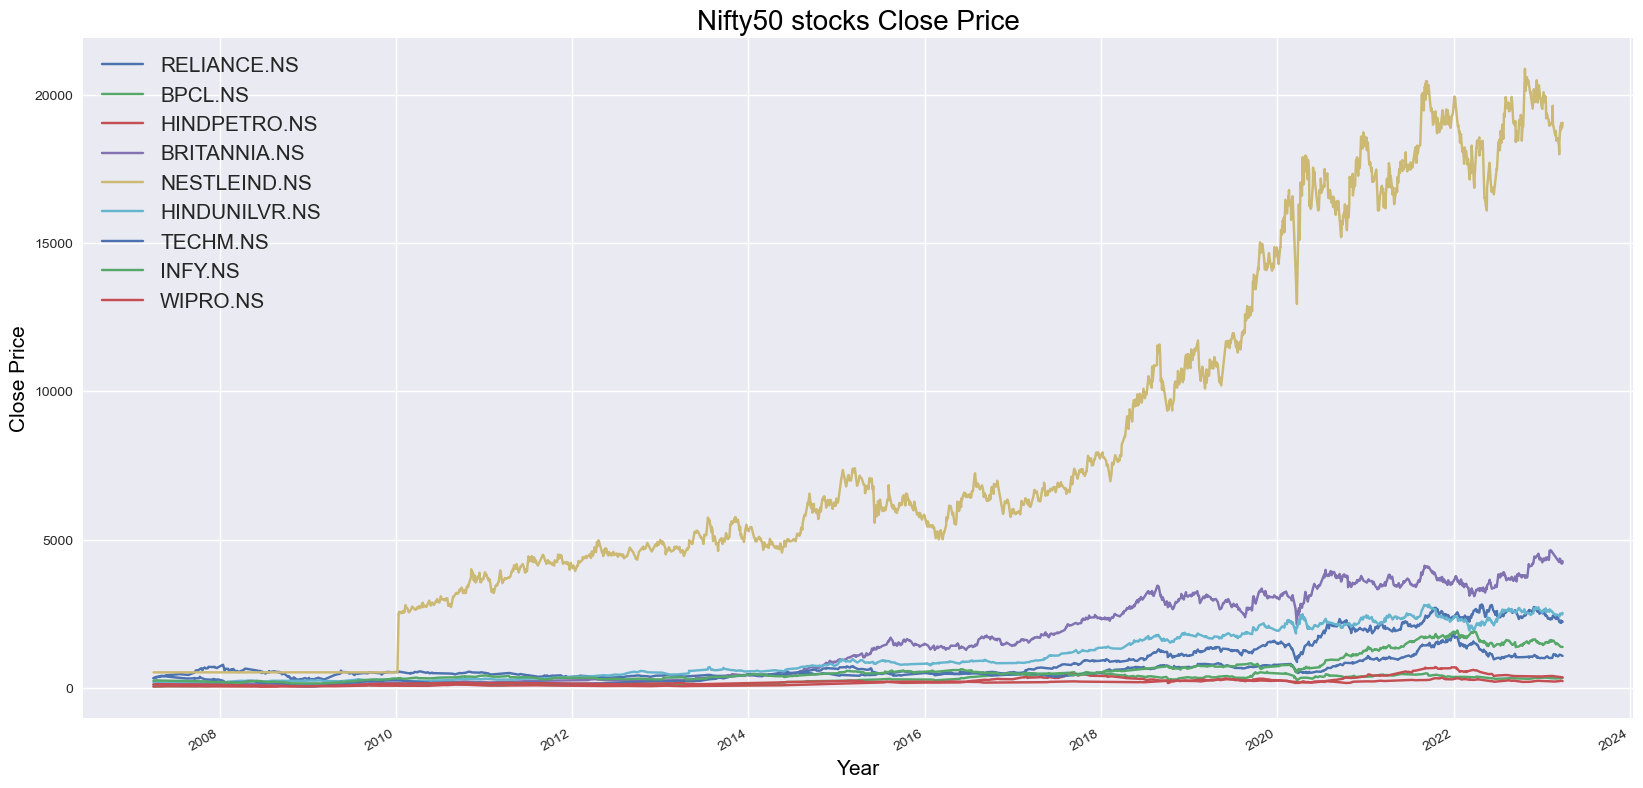

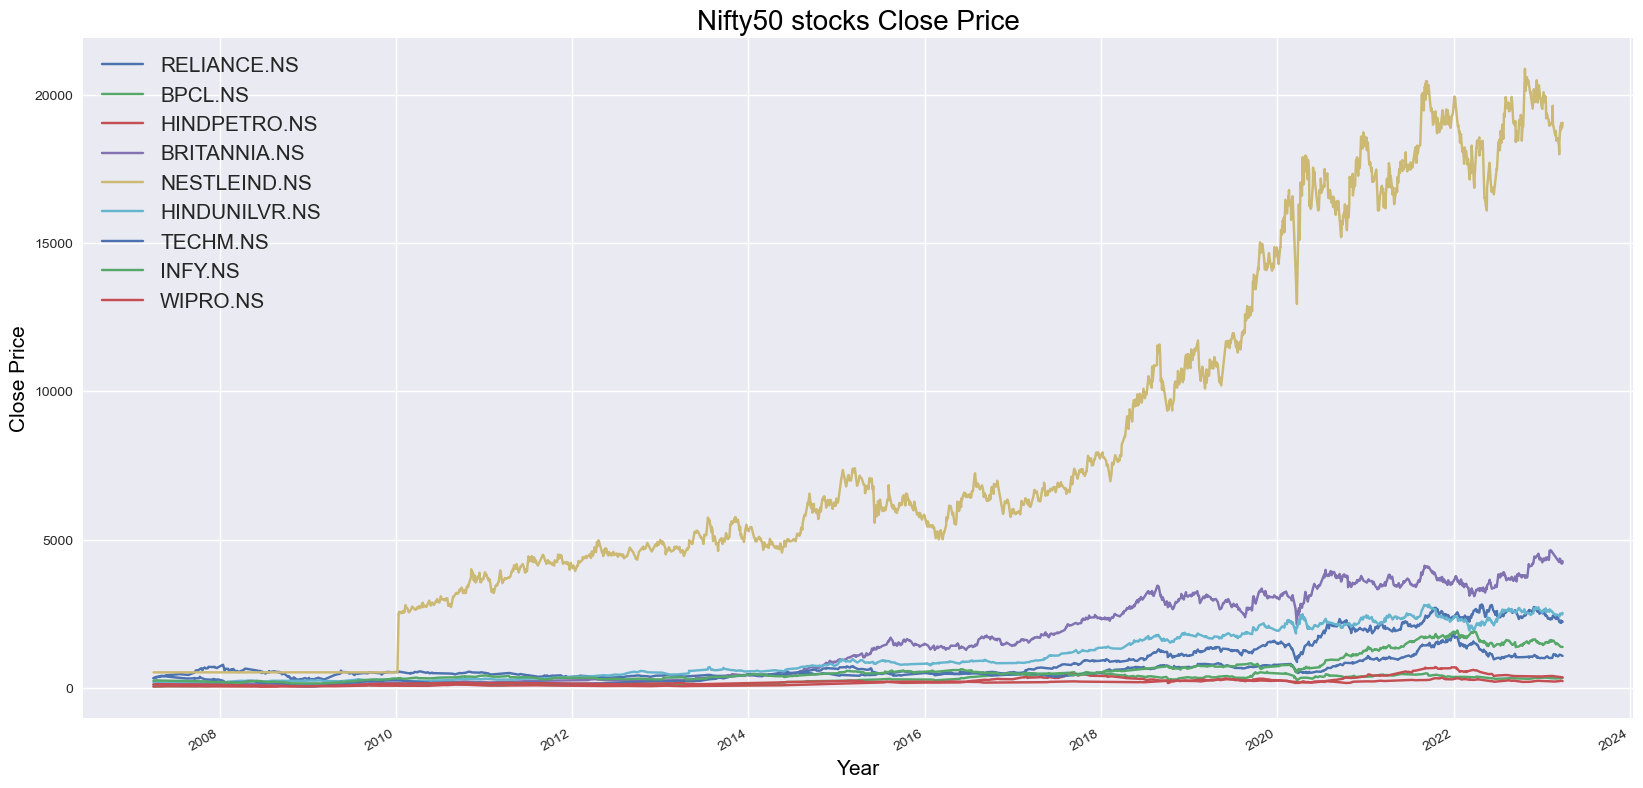

In [511]:
# Plot close prices of selected stocks

def ftse_close():
  nifty_stocks_close.plot(figsize=(20,10))
  plt.title('Nifty50 stocks Close Price', color = 'black', fontsize = 20)
  plt.legend(fontsize=15)
  plt.xlabel('Year', color = 'black', fontsize = 15)
  plt.ylabel('Close Price', color = 'black', fontsize = 15);

ftse_close()

ftse_close()

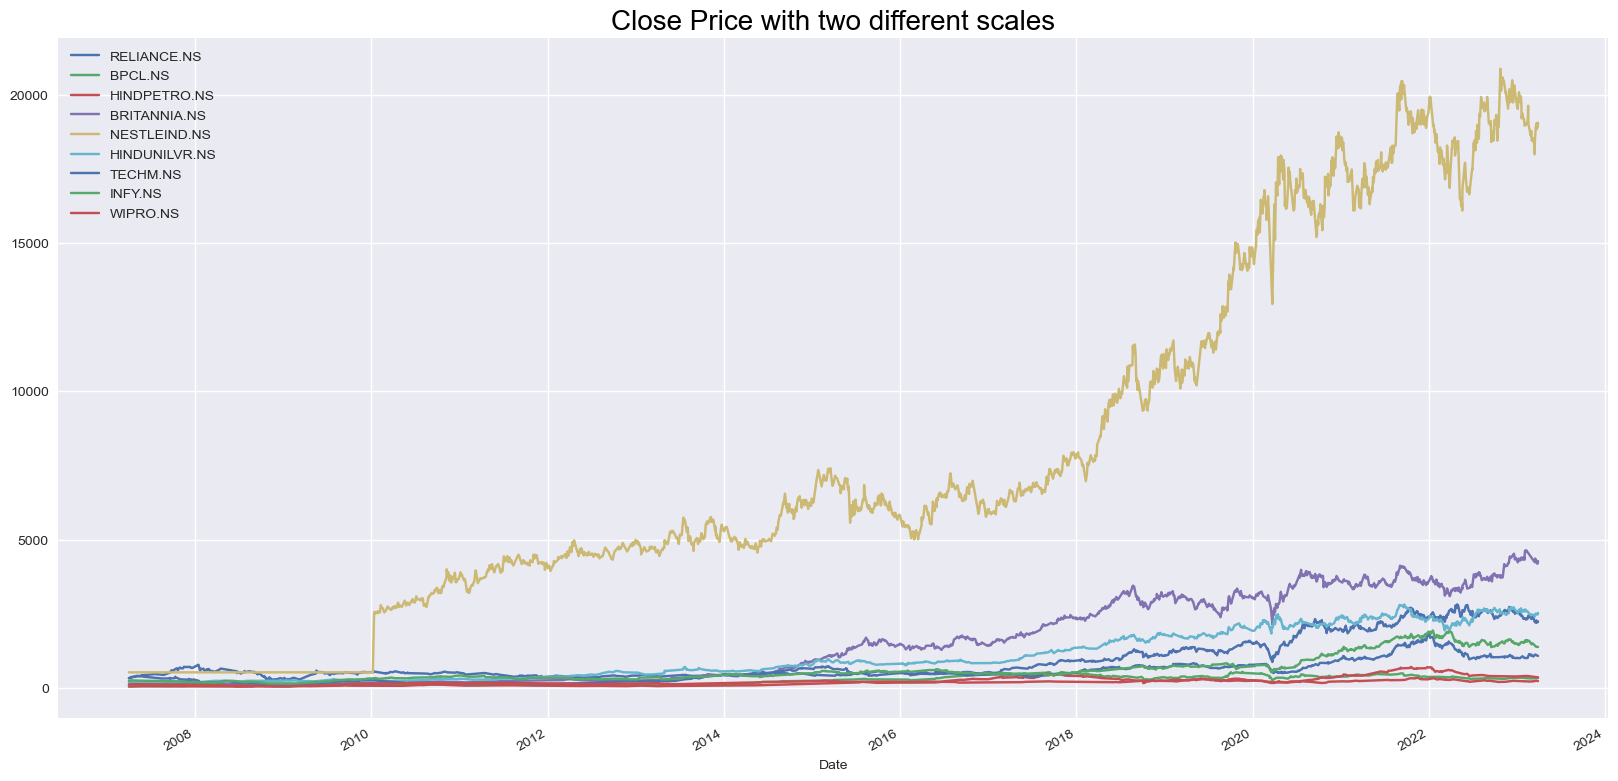

In [512]:
def two_scales():
  ax = nifty_stocks_close.plot(secondary_y = ["BP.NS"], grid = True, legend = True, figsize=(20,10))
  plt.title('Close Price with two different scales', color = 'black', fontsize = 20);

two_scales()

### Correlation

We will compute the correlation, or strength and direction of the linear relationship between pairs of stocks.

In [513]:
np.corrcoef(RELIANCE_historical['Close'],BPCL_historical['Close'])

array([[1.        , 0.60110473],
       [0.60110473, 1.        ]])

In [514]:
# compute the correlations between every pair of stocks
correlation_matrix = nifty_stocks_close.corr() 
correlation_matrix

RELIANCE.NS   BPCL.NS  HINDPETRO.NS  BRITANNIA.NS  \
RELIANCE.NS       1.000000  0.601105      0.542247      0.892280   
BPCL.NS           0.601105  1.000000      0.947865      0.844350   
HINDPETRO.NS      0.542247  0.947865      1.000000      0.771195   
BRITANNIA.NS      0.892280  0.844350      0.771195      1.000000   
NESTLEIND.NS      0.922984  0.742011      0.626787      0.943714   
HINDUNILVR.NS     0.918806  0.795797      0.699787      0.981092   
TECHM.NS          0.877790  0.700863      0.624444      0.870803   
INFY.NS           0.942325  0.629663      0.558827      0.866320   
WIPRO.NS          0.873365  0.620661      0.555794      0.793917   

               NESTLEIND.NS  HINDUNILVR.NS  TECHM.NS   INFY.NS  WIPRO.NS  
RELIANCE.NS        0.922984       0.918806  0.877790  0.942325  0.873365  
BPCL.NS            0.742011       0.795797  0.700863  0.629663  0.620661  
HINDPETRO.NS       0.626787       0.699787  0.624444  0.558827  0.555794  
BRITANNIA.NS       0.943714       0.981092  0.870803  0.866320  0.793917  
NESTLEIND.NS       1.000000       0.979062  0.893924  0.927251  0.867820  
HINDUNILVR.NS      0.979062       1.000000  0.893436  0.900191  0.836006  
TECHM.NS           0.893924       0.893436  1.000000  0.945904  0.944305  
INFY.NS            0.927251       0.900191  0.945904  1.000000  0.964819  
WIPRO.NS           0.867820       0.836006  0.944305  0.964819  1.000000

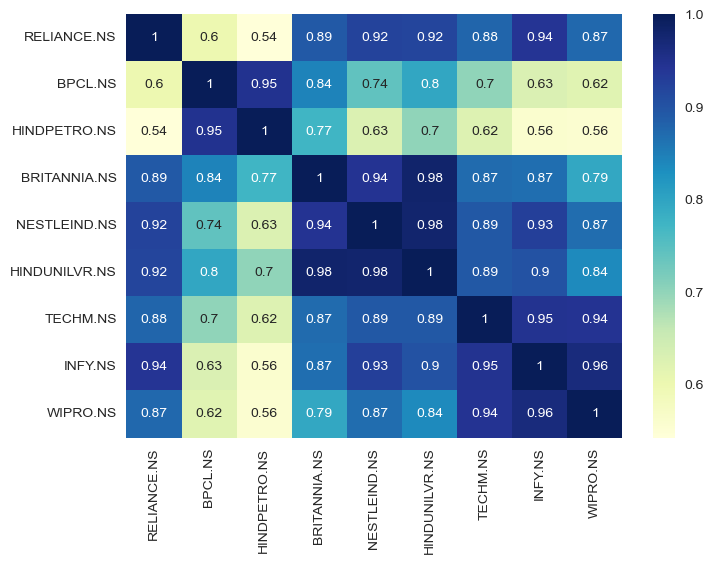

In [515]:
# Plot correlation heatmap

sns.heatmap(nifty_stocks_close.corr(), annot=True, cmap="YlGnBu");

The strongest linear correlation is between HINDUNILVR.NS and BRITANNIA.NS with 0.98. This high number represents a strong relationship between the two stocks. So if A goes up, the chances of B going up are also quite high. Based on this assumption a market neutral strategy is played where A is bought and B is sold; bought and sold decisions are made based on their individual patterns.


---



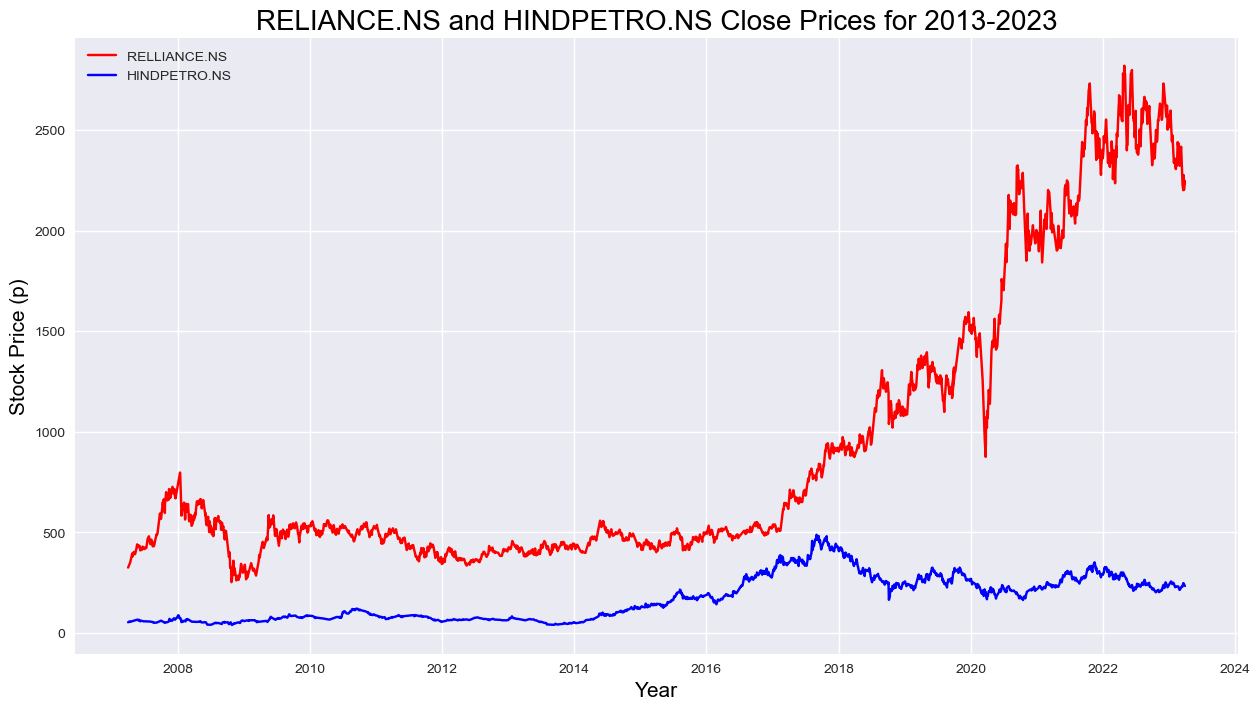

In [516]:
# Plot RELIANCE.NS and HINDPETRO.NS stocks

def stocks_RELIANCE_HINDPETRO():
  plt.figure(figsize=(15, 8))
  plt.plot(nifty_stocks_close.index, RELIANCE_historical['Close'], label = 'RELLIANCE.NS ', color= 'red')
  plt.plot(nifty_stocks_close.index, HPCL_historical['Close'], label = 'HINDPETRO.NS', color= 'blue')
  plt.title("RELIANCE.NS and HINDPETRO.NS Close Prices for 2013-2023", color = 'black', fontsize = 20)
  plt.xlabel('Year', color = 'black', fontsize = 15)
  plt.ylabel('Stock Price (p)', color = 'black', fontsize = 15);
  plt.legend(loc='upper left')
  plt.show()

stocks_RELIANCE_HINDPETRO()

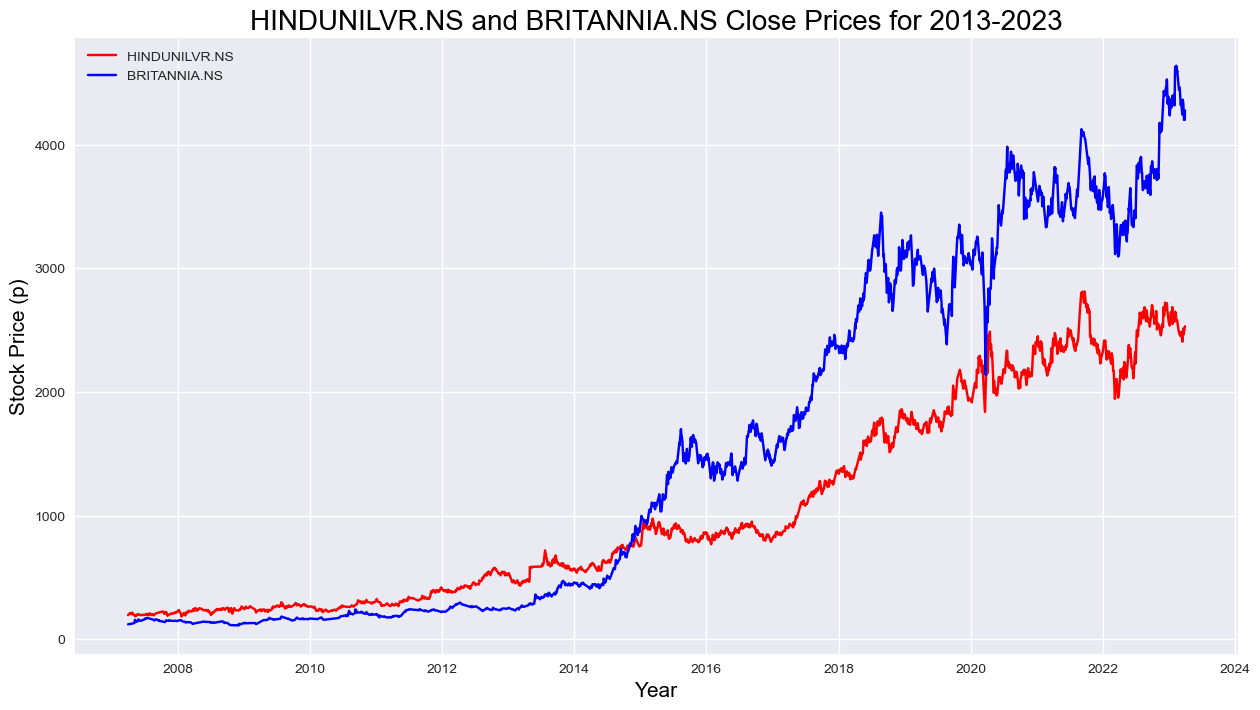

In [517]:
# Plot HINDUNILVR.NS and ULVR.NS stocks

def stocks_HINDUNILVR_ulvr():
  plt.figure(figsize=(15, 8))
  plt.plot(nifty_stocks_close.index, HINDUNILVR_historical['Close'], label = 'HINDUNILVR.NS ', color= 'red')
  plt.plot(nifty_stocks_close.index, BRITANNIA_historical['Close'], label = 'BRITANNIA.NS', color= 'blue')
  plt.title("HINDUNILVR.NS and BRITANNIA.NS Close Prices for 2013-2023", color = 'black', fontsize = 20)
  plt.xlabel('Year', color = 'black', fontsize = 15)
  plt.ylabel('Stock Price (p)', color = 'black', fontsize = 15);
  plt.legend(loc='upper left')
  plt.show()

stocks_HINDUNILVR_ulvr()

### Feature extraction - Price ratio

We need to calculate a ratio of one stock's price to another, so that we can know how much of each to buy and sell.

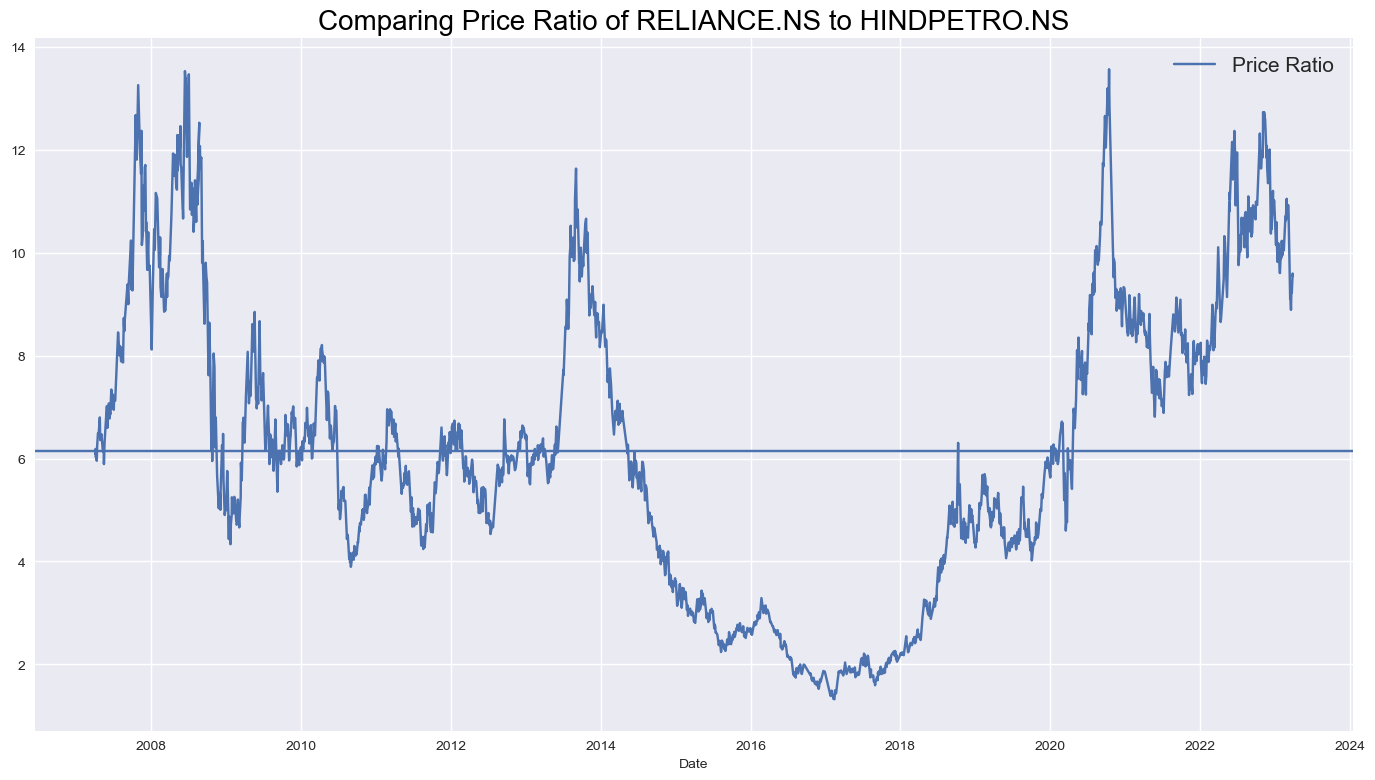

In [518]:
# Plot comparison of price ratio for RELIANCE.NS and HINDPETRO.NS 

stock1 = nifty_stocks_close['RELIANCE.NS'] # get the first price series
stock2 = nifty_stocks_close['HINDPETRO.NS'] # get the second price series
ratios = stock1 / stock2 # calculate the ratio of prices
plt.figure(figsize=(17,9))
sns.lineplot(data=ratios) # Plot the price ratio
plt.axhline(ratios.mean()) # Draw the average value
plt.legend(['Price Ratio'], loc='upper right', fontsize = 15)
plt.title('Comparing Price Ratio of RELIANCE.NS to HINDPETRO.NS', color = 'black', fontsize = 20);

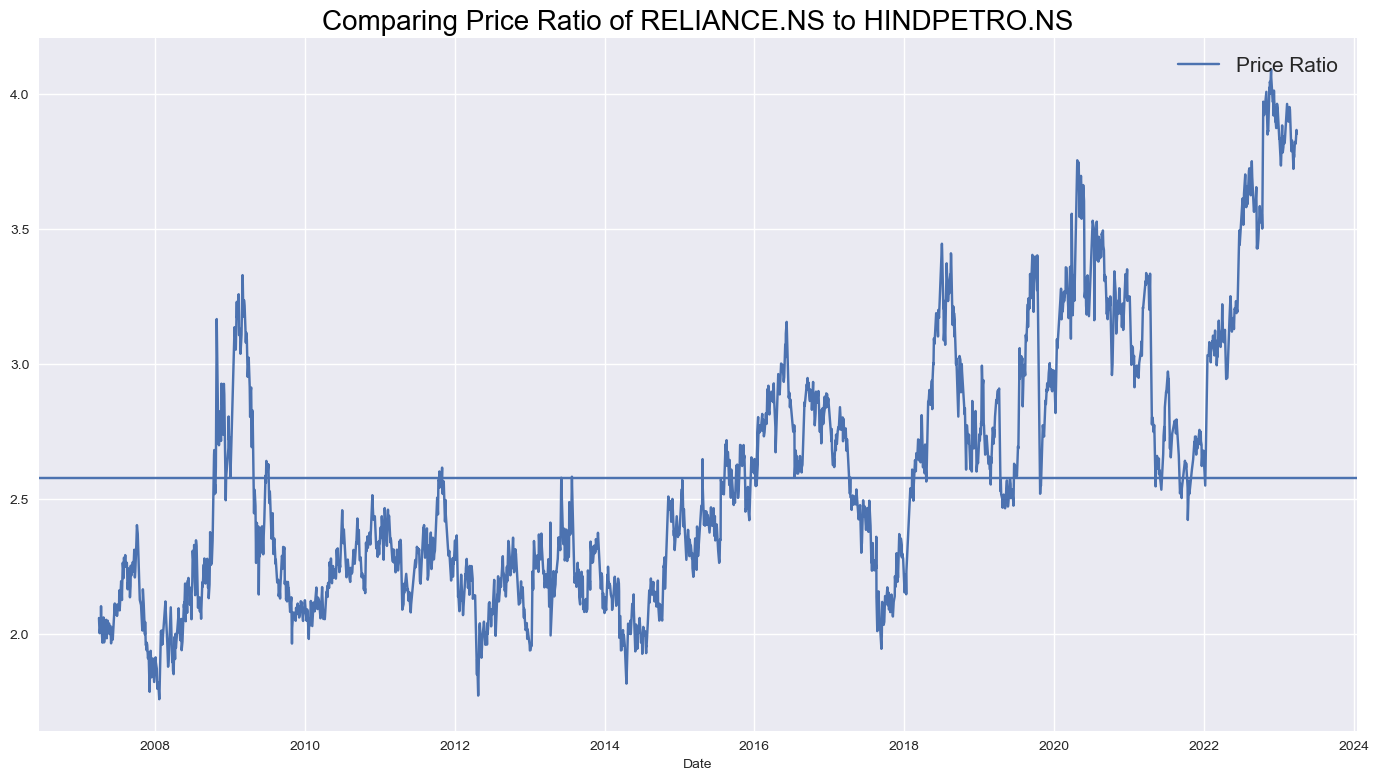

In [519]:
# Plot comparison of price ratio for IT Corporates stocks INFY.NS and WIPRO.NS

stock3 = nifty_stocks_close['INFY.NS'] # get the first price series
stock4 = nifty_stocks_close['WIPRO.NS'] # get the second price series
ratios2 = stock3 / stock4 # calculate the ratio of prices
plt.figure(figsize=(17,9))
sns.lineplot(data=ratios2) # Plot the price ratio
plt.axhline(ratios2.mean()) # Draw the average value
plt.style.use('seaborn')
plt.legend(['Price Ratio'], loc='upper right', fontsize = 15) 
plt.title('Comparing Price Ratio of RELIANCE.NS to HINDPETRO.NS', color = 'black', fontsize = 20);


Our pair of stocks do seem to float around some ratio and return to it and appear to be mean reverting. At a point where the ratio is far away from its mean, we will buy some of one stock and sell/short some of the other so that we are net neutral in our exposure to the stocks.

### Feature scaling - Z-scores

The z-score tells you how many standard deviations you are away from the mean. It is the ratio value minus its mean divided by the standard deviation of the ratio. As a measure of an observation's variability it can be used by traders to help determine market volatility. 


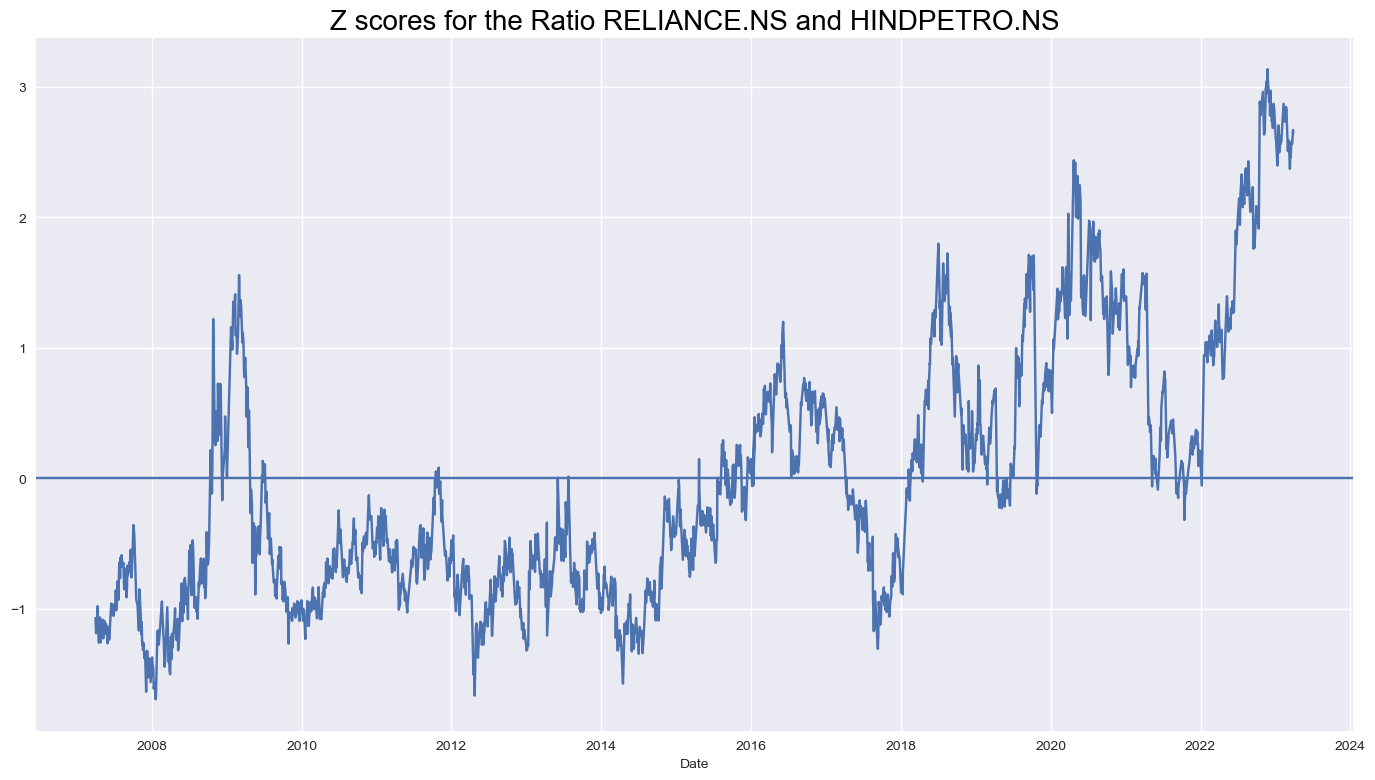

In [520]:
# Plot Z-scores for RELIANCE.NS  and HINDPETRO.NS 

plt.figure(figsize=(17, 9))
zscores = zscore(ratios2) # Let's transform to a series of Z-scores
sns.lineplot(x=ratios2.index, y=zscores) # Make another line plot
plt.axhline(zscores.mean()) 
plt.title('Z scores for the Ratio RELIANCE.NS and HINDPETRO.NS', color = 'black', fontsize = 20);

We could imagine entering the trade in early 2008 or quarter of 2012, when the z score is around -0.03 and below -0.04 respectively, and taking our gains as the line comes back towards 0 in early 2009 and late 2013. We could do the same in late 20172019 when the z score was about -0.07.

The problem with correlation is that it is not often used in real pairs trading. Just because two price series are correlated, we do not know that they will be profitable. We would like to know that if there is a price difference between two stocks that grows, that it will shrink in the future. Two stocks can be correlated if there is a price ratio that keeps on growing without a return towards a fixed value.

We will try another pair before looking at another statistical property called cointegration.

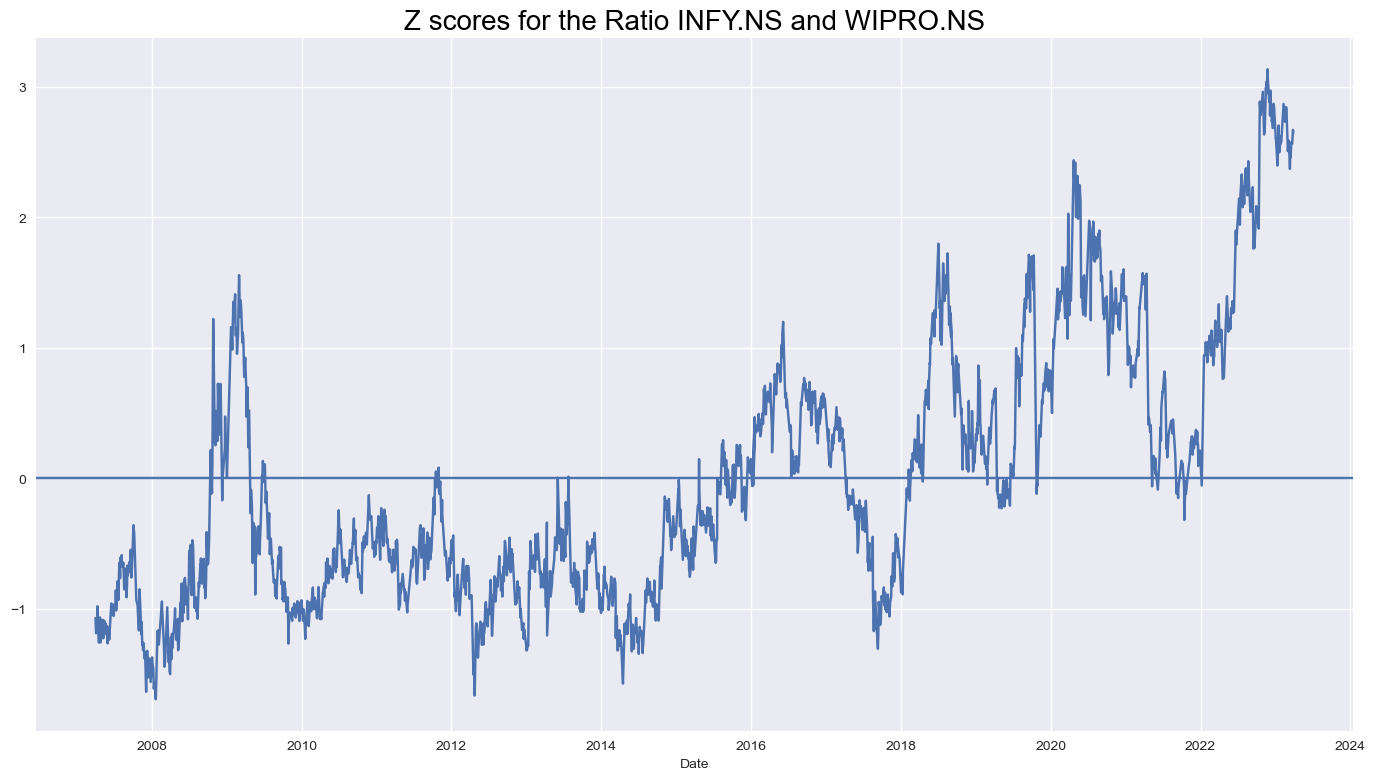

In [521]:
# Plot Z-scores for INFY.NS  and WIPRO.NS 

plt.figure(figsize=(17, 9))
zscores = zscore(ratios2) # Let's transform to a series of Z-scores
sns.lineplot(x=ratios2.index, y=zscores) # Make another line plot
plt.axhline(zscores.mean()) 
plt.title('Z scores for the Ratio INFY.NS and WIPRO.NS', color = 'black', fontsize = 20);

We could imagine entering the trade in early 2015 or early 2018, when the z score is around -2.00 and below -1.75 respectively, and taking our gains as the line comes back towards 0 in late 2016 and late 2018. We could do the same in 2019 when the z score was about 0.25.

The problem with correlation is that it is not often used in real pairs trading. Just because two price series are correlated, we do not know that they will be profitable. We would like to know that if there is a price difference between two stocks that grows, that it will shrink in the future. Two stocks can be correlated if there is a price ratio that keeps on growing without a return towards a fixed value.

We will try another pair before looking at another statistical property called cointegration.

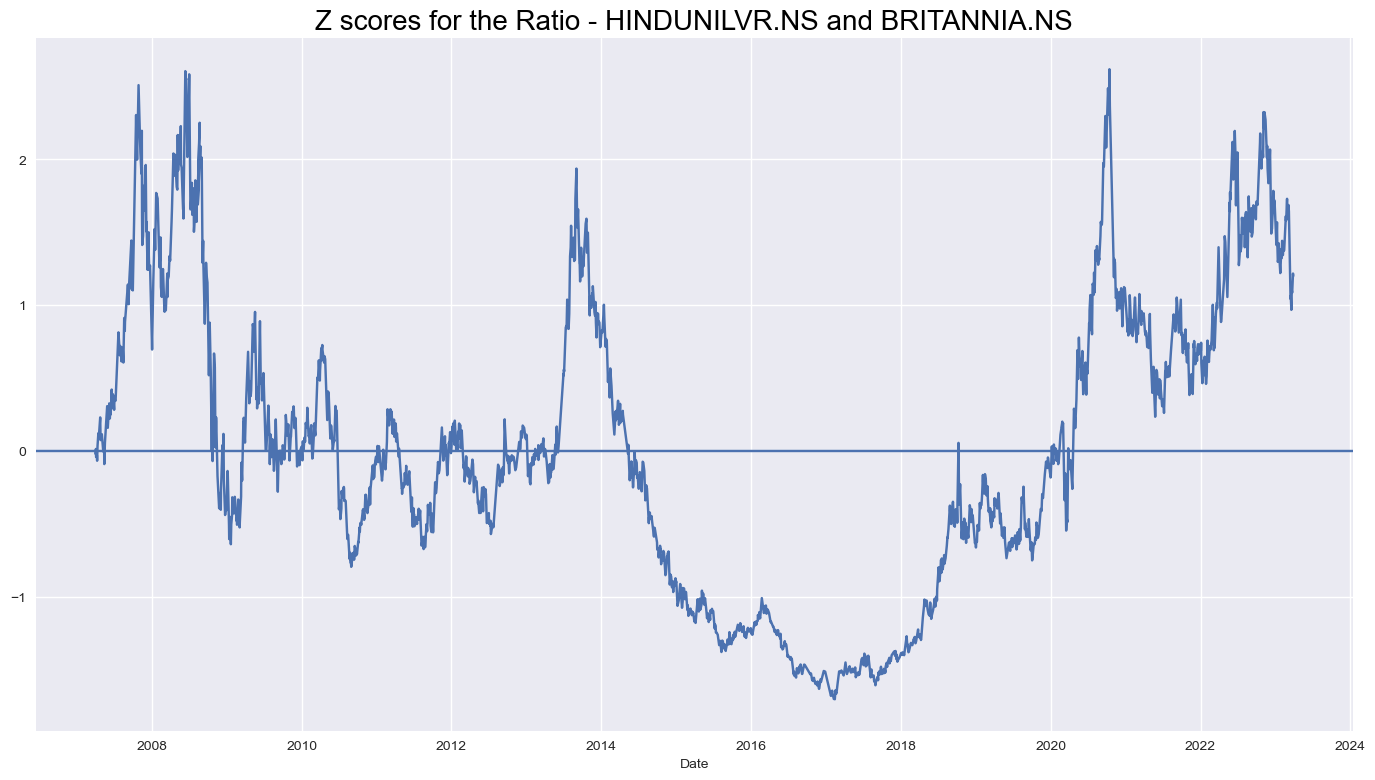

In [522]:
# Plot Z-scores for HINDUNILVR.NS and BRITANNIA.NS

plt.figure(figsize=(17, 9))
zscores1 = zscore(ratios) # Let's transform to a series of Z-scores
sns.lineplot(x=ratios2.index, y=zscores1) # Make another line plot
plt.axhline(zscores1.mean()) 
plt.title('Z scores for the Ratio - HINDUNILVR.NS and BRITANNIA.NS', color = 'black', fontsize = 20);

We could imagine entering the trade in late 2015 when the z score is around -0.75 and taking our gains as the line comes back towards 0 in late 2020.

### Cointegration

The most common test for Pairs Trading is the cointegration test. Cointegration is a statistical property of two or more time-series variables which indicates if a linear combination of the variables is stationary. 

It means that the ratio we computed will revert back to some mean value as opposed to drifting higher or lower over time. While correlation is the statistical tendency of two variables to move together, cointegration is a slightly stricter requirement.

In [523]:
# Augmented Dickey-Fuller test to check stationarity

def stationarity(a, cutoff = 0.05):
    a = np.ravel(a)
    if adfuller(a)[1] < cutoff:
      print('The series is stationary')
      print('p-value = ', adfuller(a)[1])
    else:
      print('The series is NOT stationary')
      print('p-value = ', adfuller(a)[1])

In [524]:
stationarity(RELIANCE_historical['Close'])

The series is NOT stationary
p-value =  0.9509027307210656


In [525]:
stationarity(HPCL_historical['Close'])

The series is NOT stationary
p-value =  0.5886474209174224


Neither RELIANCE.NS nor HINDPETRO.NS are stationary.

In [526]:
# Check cointegration

def cointegration(a, b):
    if coint(a, b)[1] < 0.05:
      print('The series are cointegrated')
      print('p-value = ', coint(a,b)[1])  
    else:
      print('The series are NOT cointegrated')
      print('p-value = ', coint(a,b)[1])  

In [527]:
cointegration(RELIANCE_historical['Close'], HPCL_historical['Close'])

The series are NOT cointegrated
p-value =  0.9641796093846533


RELIANCE.NS and HINDPETRO.NS are not cointegrated, so we will try HINDUNILVR.NS and BRITANNIA.NS as they are the same industry - FMCG

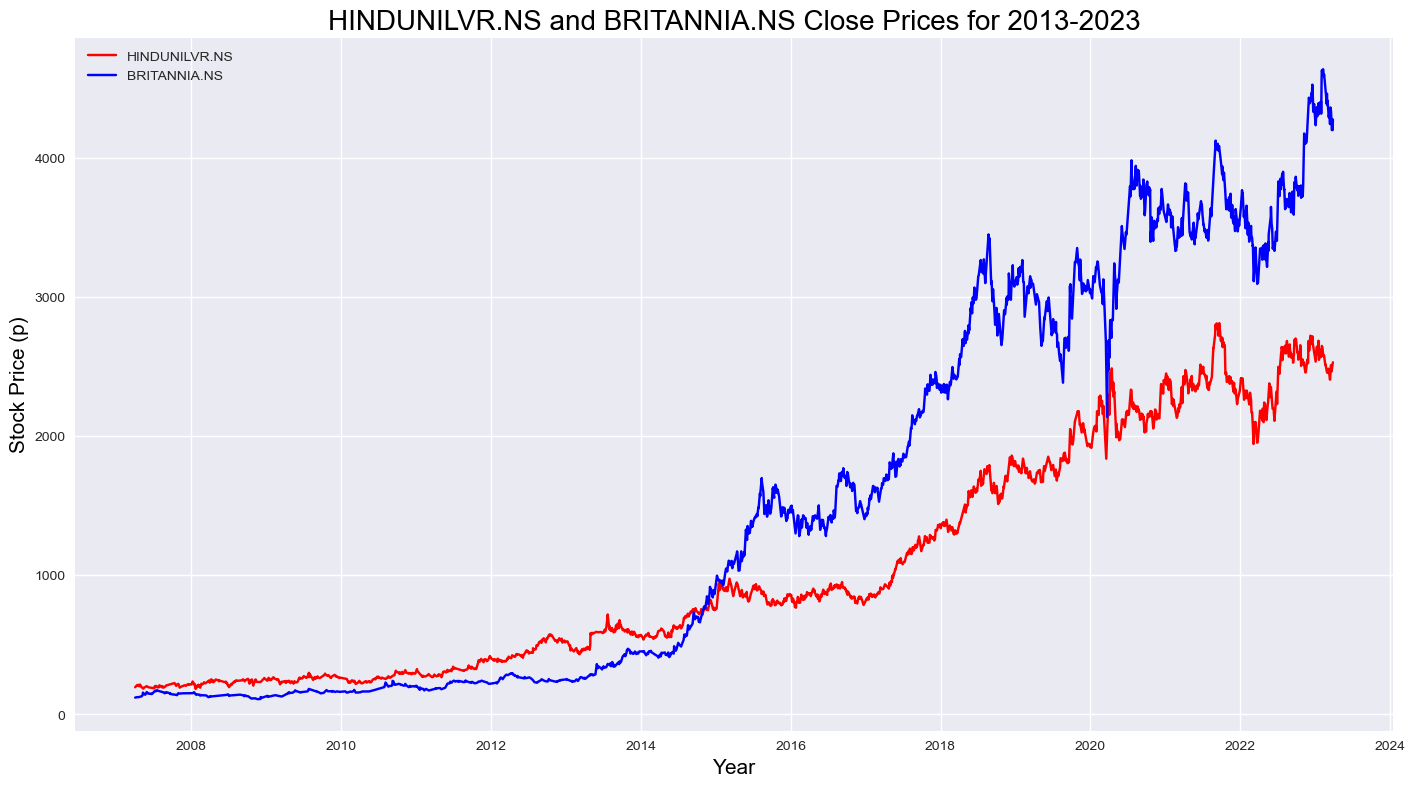

In [528]:
# Plot HINDUNILVR.NS and BRITANNI.NS stocks

def stocks_HINDUNILVR_BRITANIA():
  plt.figure(figsize=(17, 9))
  plt.plot(nifty_stocks_close.index, HINDUNILVR_historical['Close'], label = 'HINDUNILVR.NS', color= 'red')
  plt.plot(nifty_stocks_close.index, BRITANNIA_historical['Close'], label = 'BRITANNIA.NS', color= 'blue')
  plt.title("HINDUNILVR.NS and BRITANNIA.NS Close Prices for 2013-2023", color = 'black', fontsize = 20)
  plt.xlabel('Year', color = 'black', fontsize = 15)
  plt.ylabel('Stock Price (p)', color = 'black', fontsize = 15);
  plt.legend(loc='upper left')
  plt.show()

stocks_HINDUNILVR_BRITANIA()

In [529]:
cointegration(HINDUNILVR_historical['Close'], BRITANNIA_historical['Close'])

The series are NOT cointegrated
p-value =  0.06444437377617136


Despite being the same industry they are not cointegrated so we will try HINDUNILVR.NS and BRITANNIA.NS, both IT stocks.

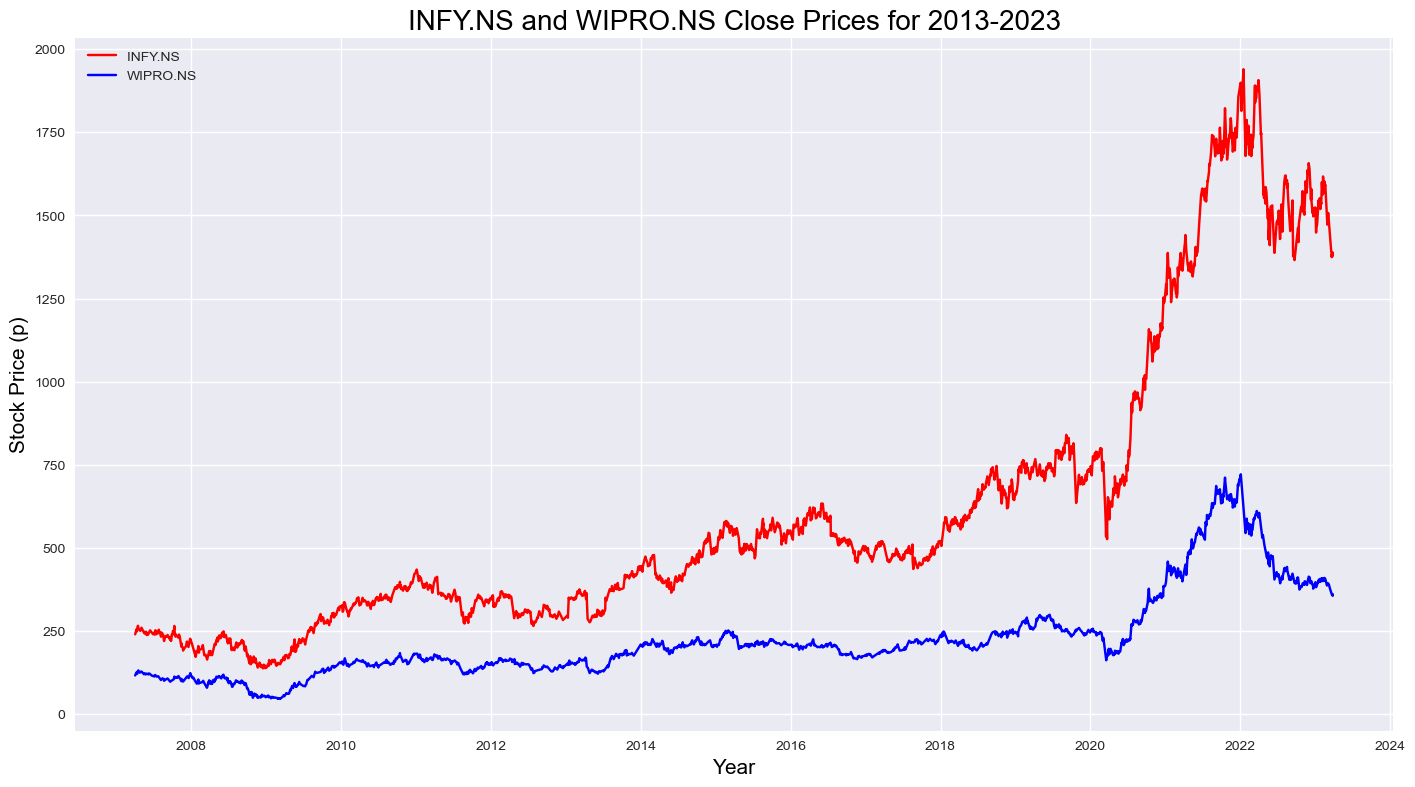

In [530]:
# Plot INFY.NS and WIPRO.NS stocks

def stocks_rdsb_bp():
  plt.figure(figsize=(17, 9))
  plt.plot(nifty_stocks_close.index, INFY_historical['Close'], label = 'INFY.NS ', color= 'red')
  plt.plot(nifty_stocks_close.index, WIPRO_historical['Close'], label = 'WIPRO.NS', color= 'blue')
  plt.title("INFY.NS and WIPRO.NS Close Prices for 2013-2023", color = 'black', fontsize = 20)
  plt.xlabel('Year', color = 'black', fontsize = 15)
  plt.ylabel('Stock Price (p)', color = 'black', fontsize = 15);
  plt.legend(loc='upper left')
  plt.show()

stocks_rdsb_bp()

In [531]:
Industry_stocks_close = pd.DataFrame({"RELIANCE.NS": RELIANCE_historical.Close,
                                "HINDPETRO.NS": HPCL_historical.Close
                                })
Industry_stocks_close.head()

RELIANCE.NS  HINDPETRO.NS
Date                                 
2007-04-02   325.403015     53.400002
2007-04-03   332.040100     54.166664
2007-04-04   337.612274     54.566666
2007-04-05   336.522614     55.799999
2007-04-09   342.825348     56.544445

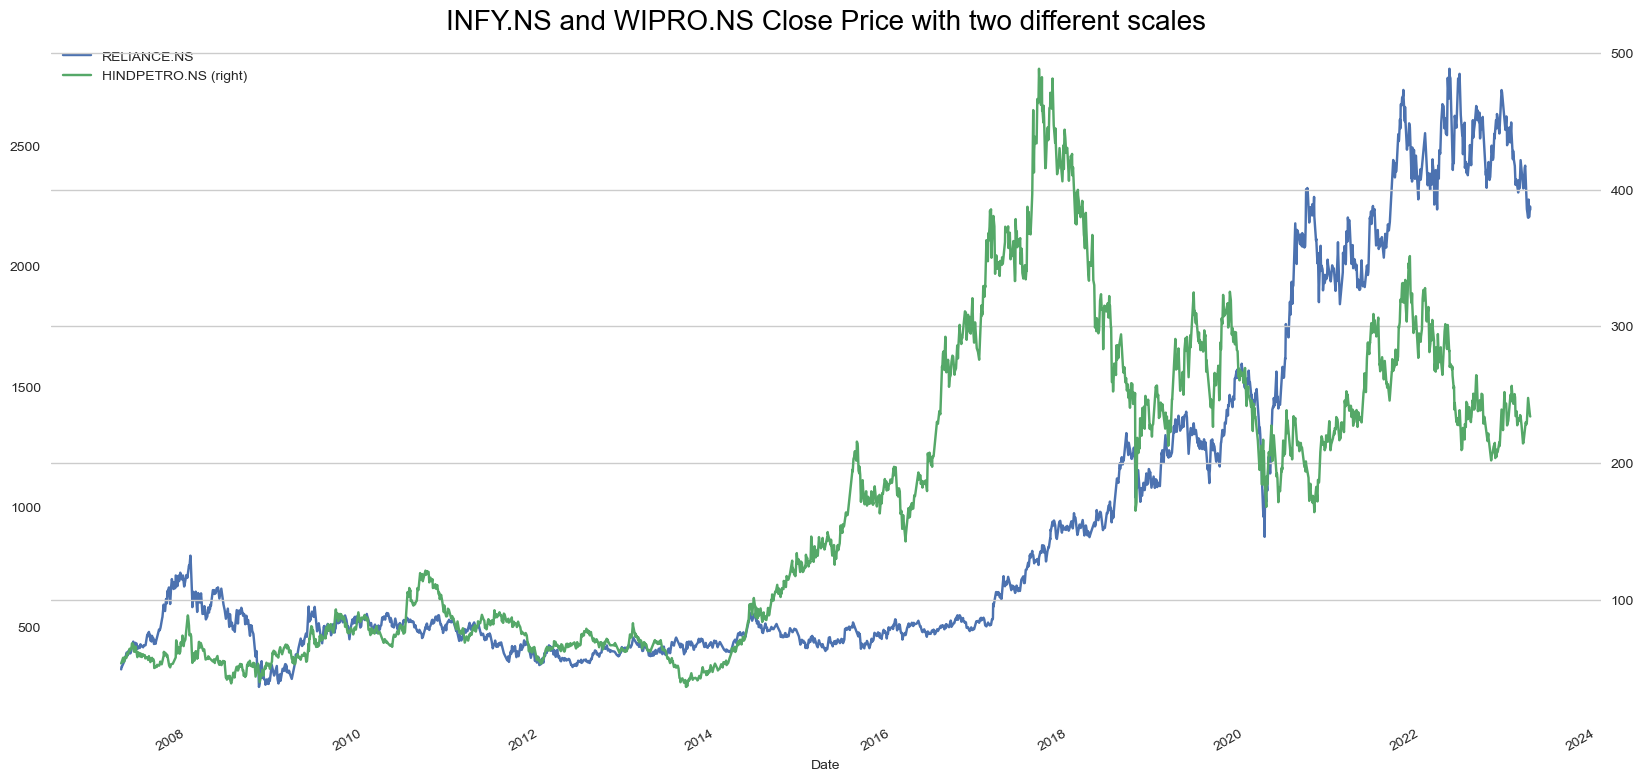

In [532]:
# Plot on two different scales

sns.set_style("white")
ax = Industry_stocks_close.plot(secondary_y = ["HINDPETRO.NS"], grid = True, legend = True, figsize=(20,10))
plt.title('INFY.NS and WIPRO.NS Close Price with two different scales', color = 'black', fontsize = 20);

In [533]:
RELIANCE_historical =  nifty_stocks_pairs['RELIANCE.NS']
BPCL_historical =  nifty_stocks_pairs['BPCL.NS']
HPCL_historical =  nifty_stocks_pairs['HINDPETRO.NS']
BRITANNIA_historical =  nifty_stocks_pairs['BRITANNIA.NS']
NESTLEIND_historical =  nifty_stocks_pairs['NESTLEIND.NS']
HINDUNILVR_historical =  nifty_stocks_pairs['HINDUNILVR.NS']
TECHM_historical =  nifty_stocks_pairs['TECHM.NS']
INFY_historical =  nifty_stocks_pairs['INFY.NS']
WIPRO_historical =  nifty_stocks_pairs['WIPRO.NS']

In [534]:
cointegration(RELIANCE_historical['Close'], BPCL_historical['Close'])

The series are NOT cointegrated
p-value =  0.9712278399258368


In [535]:
cointegration(NESTLEIND_historical['Close'], HINDUNILVR_historical['Close'])

The series are NOT cointegrated
p-value =  0.2908941936128244


In [536]:
# Cointegration test 

coint_t, pval, crit_val = coint(stock3, stock4) # It is nearly as easy to use cointegration
print(f'The test statistic is {coint_t}, the p-value is {pval} \n and the critical values to be significant at the 1% / 5% / 10% levels are {crit_val}')

The test statistic is -2.6093151787953484, the p-value is 0.23309339028808107 
 and the critical values to be significant at the 1% / 5% / 10% levels are [-3.8992176  -3.33767887 -3.04552498]


In [537]:
# Choose the two oil stocks as they are cointegrated and the same industry.

Industry_stocks_df = Industry_stocks_close.copy()
Industry_stocks_df

RELIANCE.NS  HINDPETRO.NS
Date                                 
2007-04-02   325.403015     53.400002
2007-04-03   332.040100     54.166664
2007-04-04   337.612274     54.566666
2007-04-05   336.522614     55.799999
2007-04-09   342.825348     56.544445
...                 ...           ...
2023-03-23  2247.800049    242.699997
2023-03-24  2203.300049    238.850006
2023-03-27  2237.550049    236.300003
2023-03-28  2248.000000    234.250000
2023-03-29  2234.699951    234.050003

[3947 rows x 2 columns]

In [538]:
# Another check for stationarity is the ratio between the two oil stocks

Industry_stocks_df['Ratio'] = RELIANCE_historical['Close'] / HPCL_historical['Close']

Industry_ratio = Industry_stocks_df.iloc[:, 2]

stationarity(Industry_ratio)

The series is NOT stationary
p-value =  0.3610526067273473


In [539]:
# Dataframe with Ratio column

Industry_stocks_df

RELIANCE.NS  HINDPETRO.NS     Ratio
Date                                           
2007-04-02   325.403015     53.400002  6.093689
2007-04-03   332.040100     54.166664  6.129971
2007-04-04   337.612274     54.566666  6.187152
2007-04-05   336.522614     55.799999  6.030871
2007-04-09   342.825348     56.544445  6.062936
...                 ...           ...       ...
2023-03-23  2247.800049    242.699997  9.261640
2023-03-24  2203.300049    238.850006  9.224618
2023-03-27  2237.550049    236.300003  9.469107
2023-03-28  2248.000000    234.250000  9.596585
2023-03-29  2234.699951    234.050003  9.547960

[3947 rows x 3 columns]

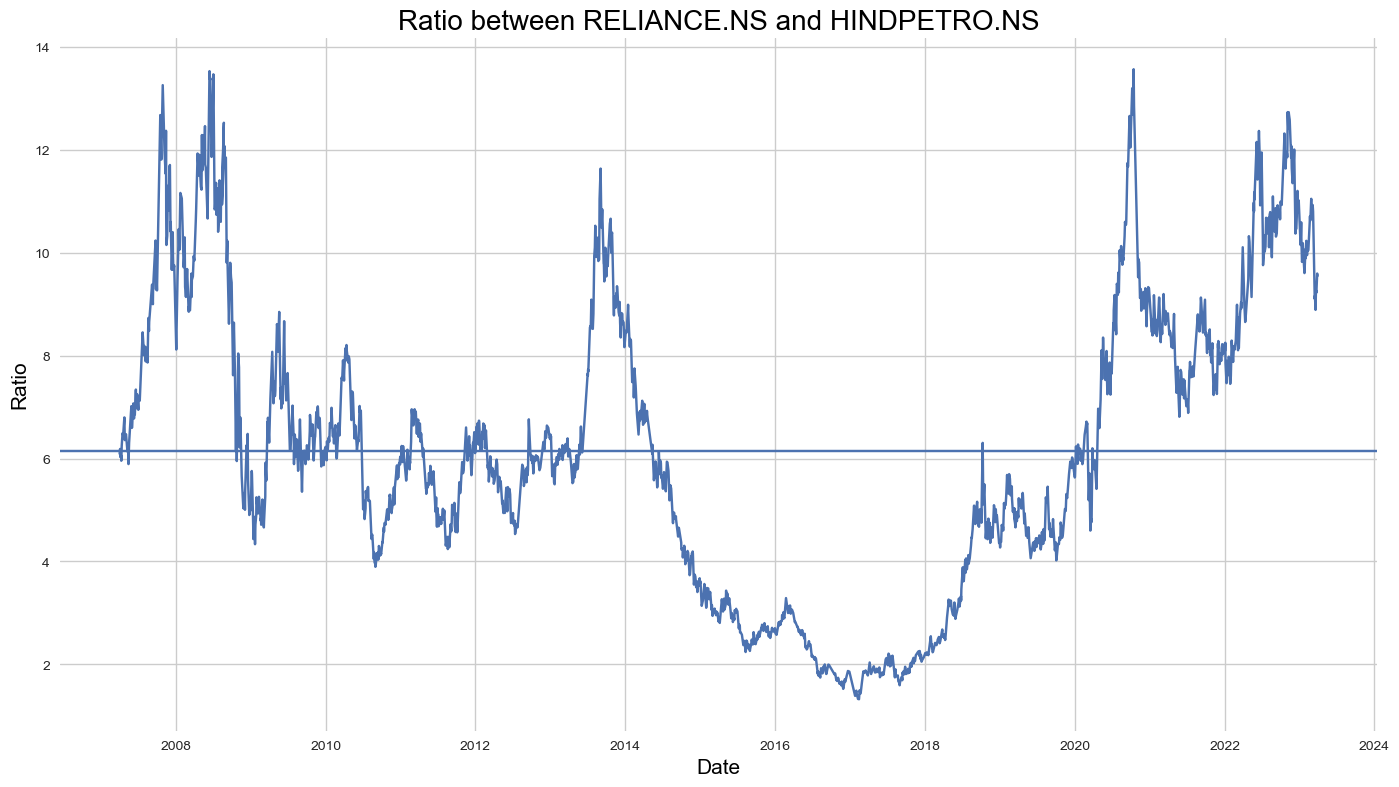

In [540]:
# Plot ratio between RELIANCE.NS and HINDPETRO.NS

plt.figure(figsize=(17, 9))
sns.lineplot(x=Industry_stocks_df.index, y=Industry_stocks_df.Ratio) 
plt.axhline(Industry_stocks_df.Ratio.mean())
plt.grid(True)
plt.xlabel('Date', color = 'black', fontsize = 15)
plt.ylabel('Ratio', color = 'black', fontsize = 15)
plt.title('Ratio between RELIANCE.NS and HINDPETRO.NS', color = 'black', fontsize = 20);

Calculating the ratio between RELIANCE.NS and HINDPETRO.NS and plotting it shows that the stocks appear to not vary around a constant mean, and the spread appears to not satisfy the stationarity test as well.

In [541]:
# Further work could include backtesting a dollar-neutral pairs trading strategy on WIPRO.NS and INFO.NS with following conditions:

holding_period = 60
lookback = 9
upper_barrier = 2
lower_barrier = -2


In [542]:
# Add column for the mean
Industry_stocks_df['Mean'] = ''


In [543]:
# Standardisation assuming the spread

for i in range(len(Industry_stocks_df)):
  try:
    Industry_stocks_df.iloc[i, 3] = (Industry_stocks_df.iloc[i - lookback:i + 1, 2].mean())
  except IndexError:
    pass

In [544]:
# Add column for Standard deviation

Industry_stocks_df['StdDev'] = ''


In [545]:
# Calculate the Standard deviation

for i in range(len(Industry_stocks_df)):
  Industry_stocks_df.iloc[i, 4] = ((Industry_stocks_df.iloc[i - lookback:i + 1, 2].std()))

In [546]:
# Add column for Standardised Ratio

Industry_stocks_df['StdRatio'] = ''

In [547]:
# Standardise the ratio in order to normalise the signals

for i in range(len(Industry_stocks_df)):
  Industry_stocks_df.iloc[i, 5] = (Industry_stocks_df.iloc[i, 2] - Industry_stocks_df.iloc[i, 3]) / Industry_stocks_df.iloc[i, 4]

In [548]:
Industry_stocks_df

RELIANCE.NS  HINDPETRO.NS     Ratio      Mean    StdDev  StdRatio
Date                                                                         
2007-04-02   325.403015     53.400002  6.093689       NaN       NaN       NaN
2007-04-03   332.040100     54.166664  6.129971       NaN       NaN       NaN
2007-04-04   337.612274     54.566666  6.187152       NaN       NaN       NaN
2007-04-05   336.522614     55.799999  6.030871       NaN       NaN       NaN
2007-04-09   342.825348     56.544445  6.062936       NaN       NaN       NaN
...                 ...           ...       ...       ...       ...       ...
2023-03-23  2247.800049    242.699997  9.261640  9.475402   0.43141 -0.495494
2023-03-24  2203.300049    238.850006  9.224618  9.386675  0.373287 -0.434135
2023-03-27  2237.550049    236.300003  9.469107  9.332709  0.306371  0.445205
2023-03-28  2248.000000    234.250000  9.596585  9.297199   0.24006  1.247125
2023-03-29  2234.699951    234.050003  9.547960  9.280843  0.212707  1.255794

[3947 rows x 6 columns]

In [549]:
# Clean up data by dropping NaNs
Industry_stocks_df.dropna(inplace=True)
Industry_stocks_df

RELIANCE.NS  HINDPETRO.NS     Ratio      Mean    StdDev  StdRatio
Date                                                                         
2007-04-16   361.015442     55.611111  6.491786  6.172801  0.168382  1.894415
2007-04-17   365.485565     58.122223  6.288224  6.192254  0.169461  0.566326
2007-04-18   367.850647     56.911110  6.463600  6.225617  0.187697  1.267911
2007-04-19   369.584198     57.244446  6.456246  6.252526  0.200427  1.016425
2007-04-20   381.743958     57.677776  6.618562  6.311295  0.213919  1.436368
...                 ...           ...       ...       ...       ...       ...
2023-03-23  2247.800049    242.699997  9.261640  9.475402   0.43141 -0.495494
2023-03-24  2203.300049    238.850006  9.224618  9.386675  0.373287 -0.434135
2023-03-27  2237.550049    236.300003  9.469107  9.332709  0.306371  0.445205
2023-03-28  2248.000000    234.250000  9.596585  9.297199   0.24006  1.247125
2023-03-29  2234.699951    234.050003  9.547960  9.280843  0.212707  1.255794

[3938 rows x 6 columns]

In [550]:
# Check data types

Industry_stocks_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3938 entries, 2007-04-16 to 2023-03-29
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   RELIANCE.NS   3938 non-null   float64
 1   HINDPETRO.NS  3938 non-null   float64
 2   Ratio         3938 non-null   float64
 3   Mean          3938 non-null   object 
 4   StdDev        3938 non-null   object 
 5   StdRatio      3938 non-null   object 
dtypes: float64(3), object(3)
memory usage: 215.4+ KB


In [551]:
# Convert data types for Mean and StdDev from object to float

Industry_stocks_df["Mean"] = Industry_stocks_df.Mean.astype(float)
Industry_stocks_df["StdDev"] = Industry_stocks_df.StdDev.astype(float)
Industry_stocks_df["StdRatio"] = Industry_stocks_df.StdRatio.astype(float)

In [552]:
# Check data types

Industry_stocks_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3938 entries, 2007-04-16 to 2023-03-29
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   RELIANCE.NS   3938 non-null   float64
 1   HINDPETRO.NS  3938 non-null   float64
 2   Ratio         3938 non-null   float64
 3   Mean          3938 non-null   float64
 4   StdDev        3938 non-null   float64
 5   StdRatio      3938 non-null   float64
dtypes: float64(6)
memory usage: 215.4 KB


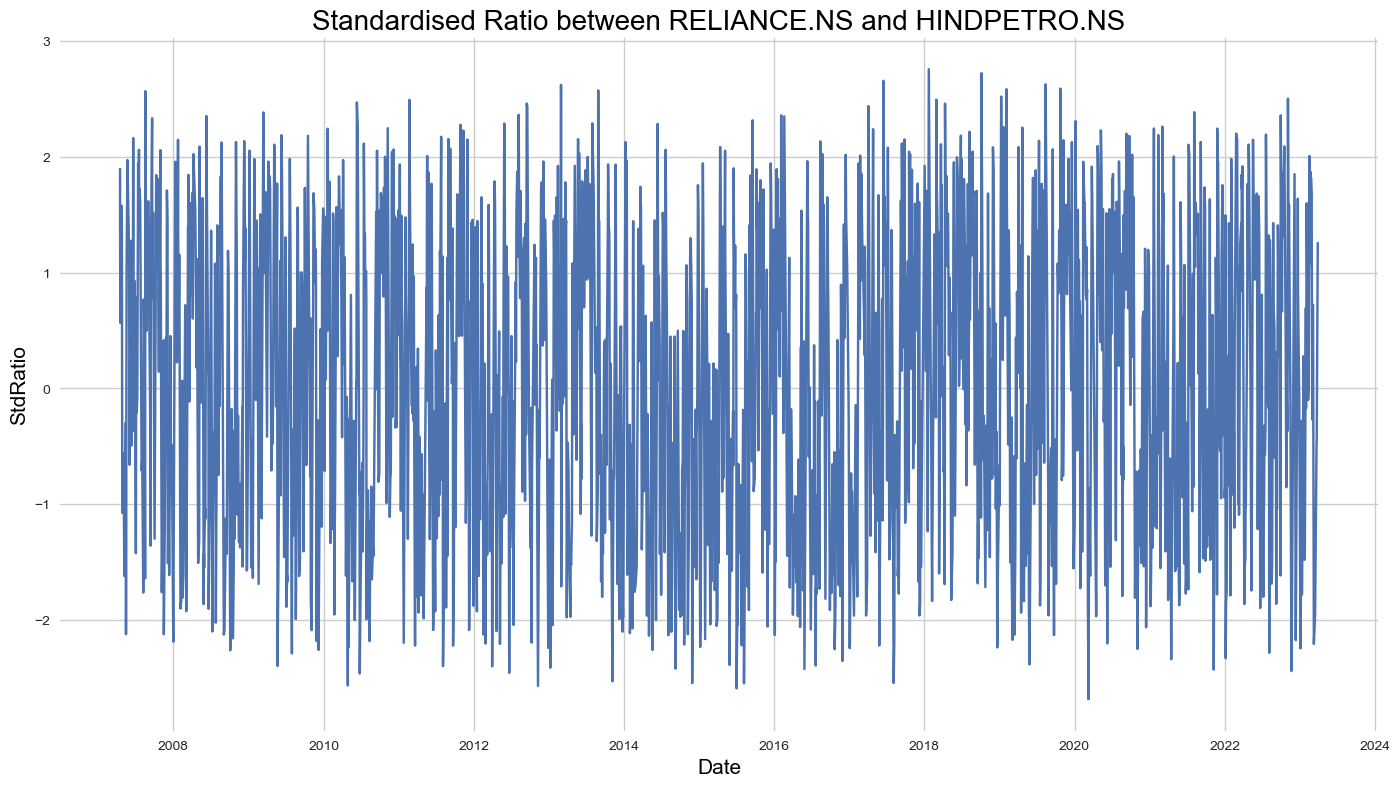

In [553]:
# Plot Standardised Ratio between WIPRO.NS and INFY.NS

plt.figure(figsize=(17, 9))
sns.lineplot(x=Industry_stocks_df.index, y=Industry_stocks_df.StdRatio) 
plt.grid(True)
plt.xlabel('Date', color = 'black', fontsize = 15)
plt.ylabel('StdRatio', color = 'black', fontsize = 15)
plt.title('Standardised Ratio between RELIANCE.NS and HINDPETRO.NS', color = 'black', fontsize = 20);

The arbitrarily chosen barriers of 2 and -2 would be used to initiate trades. If the standardised ratio reached -2 we would go long the ratio, and if it reached 2 we would short the ratio. 

## 5.4 Volume Trading Strategies

Volume trading is a measure of how much of a given financial asset has traded in a period of time. Volume traders look for instances of increased buying or selling orders. They also pay attention to current price trends and potential price movements. Generally, increased trading volume will lean heavily towards buy orders.

### 5.4.1 On Balance Volume (OBV)

OBV is a momentum-based indicator which measures volume flow to gauge the direction of the trend. Volume and price rise are directly proportional and OBV can be used as a confirmation tool with regards to price trends. A rising price is depicted by a rising OBV and a falling OBV stands for a falling price. 

It is a  cumulative total of the up and down volume. When the close is higher than the previous close, the volume is added to the running
total, and when the close is lower than the previous close, the volume is subtracted
from the running total.

In [554]:
# Create copy of dataframe for RELIANCE.NS stock

RELIANCEINDUSTRY_obv = RELIANCEINDUSTRY.copy()
RELIANCEINDUSTRY_obv

Open         High          Low        Close    Adj Close  \
Date                                                                          
2007-04-02   335.569153   336.510223   323.248413   325.403015   291.745697   
2007-04-03   327.025116   333.340271   324.300964   332.040100   297.696259   
2007-04-04   333.835571   339.023895   333.761261   337.612274   302.692047   
2007-04-05   337.550354   337.996124   334.875702   336.522614   301.715179   
2007-04-09   338.045654   343.741669   337.302704   342.825348   307.365936   
...                 ...          ...          ...          ...          ...   
2023-03-23  2268.000000  2269.899902  2243.050049  2247.800049  2247.800049   
2023-03-24  2245.250000  2250.000000  2198.000000  2203.300049  2203.300049   
2023-03-27  2217.500000  2254.000000  2200.199951  2237.550049  2237.550049   
2023-03-28  2245.000000  2256.500000  2237.000000  2248.000000  2248.000000   
2023-03-29  2239.000000  2244.800049  2211.100098  2234.699951  2234.699951   

              Volume  
Date                  
2007-04-02  13286092  
2007-04-03  10745415  
2007-04-04   8035662  
2007-04-05   4899877  
2007-04-09   4489883  
...              ...  
2023-03-23   7499082  
2023-03-24   5711497  
2023-03-27   6486068  
2023-03-28   5804018  
2023-03-29   8678073  

[3947 rows x 6 columns]

In [555]:
# Create dataframe for slice of RELIANCE.NS stock for 6 months Oct - Mar 2023

RELIANCEINDUSTRY_obv_6mo = RELIANCEINDUSTRY_obv['2022-10-01':'2023-03-31']
RELIANCEINDUSTRY_obv_6mo

Open         High          Low        Close    Adj Close  \
Date                                                                          
2022-10-03  2391.500000  2416.949951  2363.000000  2369.500000  2369.500000   
2022-10-04  2397.800049  2418.000000  2390.149902  2413.199951  2413.199951   
2022-10-06  2429.000000  2450.000000  2418.149902  2422.100098  2422.100098   
2022-10-07  2414.649902  2443.899902  2414.649902  2432.350098  2432.350098   
2022-10-10  2405.000000  2417.600098  2388.000000  2405.800049  2405.800049   
...                 ...          ...          ...          ...          ...   
2023-03-23  2268.000000  2269.899902  2243.050049  2247.800049  2247.800049   
2023-03-24  2245.250000  2250.000000  2198.000000  2203.300049  2203.300049   
2023-03-27  2217.500000  2254.000000  2200.199951  2237.550049  2237.550049   
2023-03-28  2245.000000  2256.500000  2237.000000  2248.000000  2248.000000   
2023-03-29  2239.000000  2244.800049  2211.100098  2234.699951  2234.699951   

             Volume  
Date                 
2022-10-03  5470030  
2022-10-04  4129893  
2022-10-06  6162021  
2022-10-07  3560167  
2022-10-10  2921076  
...             ...  
2023-03-23  7499082  
2023-03-24  5711497  
2023-03-27  6486068  
2023-03-28  5804018  
2023-03-29  8678073  

[123 rows x 6 columns]

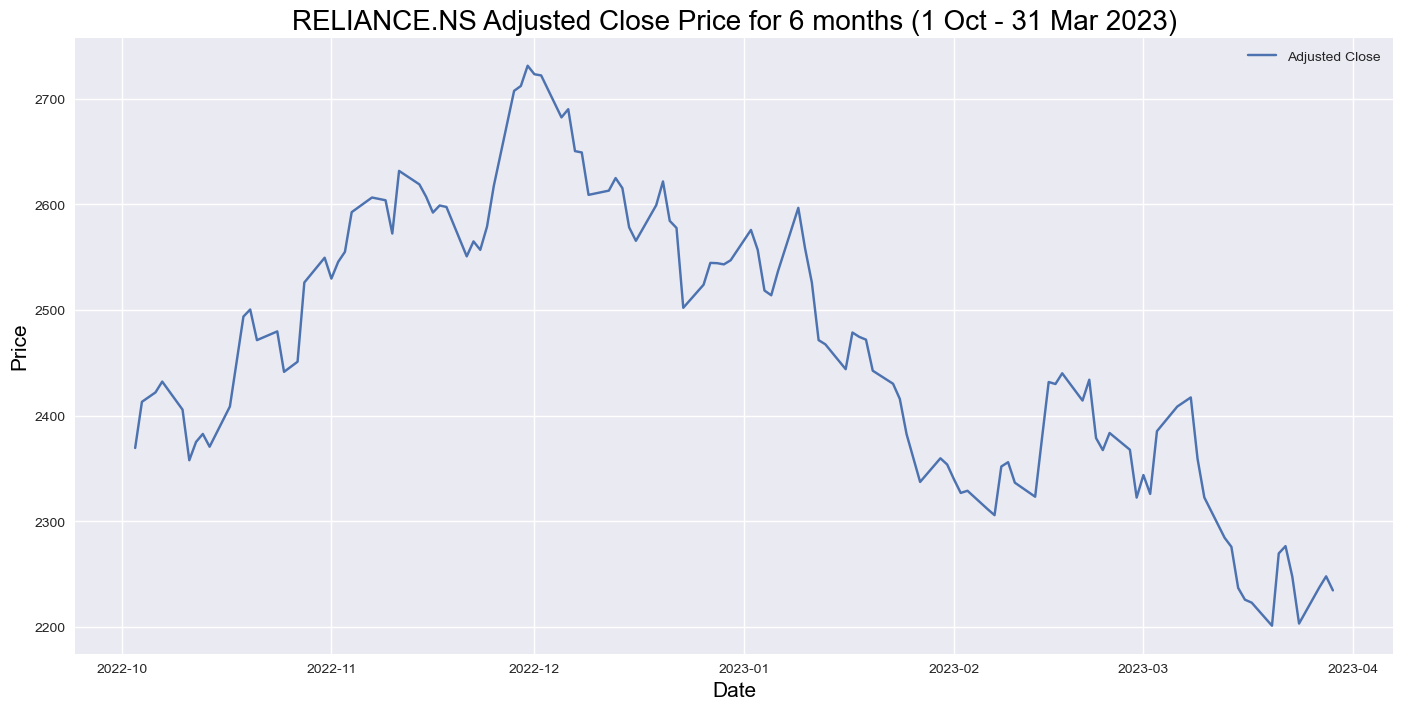

In [556]:
# Plot RELIANCE.NS Adjusted Close price for the time period

def obv_adj():
  plt.figure(figsize=(17, 8))
  plt.style.use('seaborn')
  plt.plot(RELIANCEINDUSTRY_obv_6mo['Adj Close'], label = 'Adjusted Close')
  plt.title('RELIANCE.NS Adjusted Close Price for 6 months (1 Oct - 31 Mar 2023)', color = 'black', fontsize = 20)
  plt.xlabel('Date', color = 'black', fontsize = 15)
  plt.ylabel('Price', color = 'black', fontsize = 15)
  plt.legend()
  plt.show()

obv_adj()

In [557]:
# Calculate the OBV

OBV = []
OBV.append(0)

for i in range(1, len(RELIANCEINDUSTRY_obv_6mo['Adj Close'])):
  if RELIANCEINDUSTRY_obv_6mo['Adj Close'][i] > RELIANCEINDUSTRY_obv_6mo['Adj Close'][i-1]:
    OBV.append(OBV[-1] + RELIANCEINDUSTRY_obv_6mo.Volume[i])
  elif RELIANCEINDUSTRY_obv_6mo['Adj Close'][i] < RELIANCEINDUSTRY_obv_6mo['Adj Close'][i-1]:
    OBV.append(OBV[-1] - RELIANCEINDUSTRY_obv_6mo.Volume[i])
  else:
    OBV.append(OBV[-1])


In [558]:
# Store OBV and OBV EMA in new columns

RELIANCEINDUSTRY_obv_6mo['OBV'] = OBV
RELIANCEINDUSTRY_obv_6mo['OBV_EMA'] = RELIANCEINDUSTRY_obv_6mo['OBV'].ewm(span=20).mean()
RELIANCEINDUSTRY_obv_6mo

Open         High          Low        Close    Adj Close  \
Date                                                                          
2022-10-03  2391.500000  2416.949951  2363.000000  2369.500000  2369.500000   
2022-10-04  2397.800049  2418.000000  2390.149902  2413.199951  2413.199951   
2022-10-06  2429.000000  2450.000000  2418.149902  2422.100098  2422.100098   
2022-10-07  2414.649902  2443.899902  2414.649902  2432.350098  2432.350098   
2022-10-10  2405.000000  2417.600098  2388.000000  2405.800049  2405.800049   
...                 ...          ...          ...          ...          ...   
2023-03-23  2268.000000  2269.899902  2243.050049  2247.800049  2247.800049   
2023-03-24  2245.250000  2250.000000  2198.000000  2203.300049  2203.300049   
2023-03-27  2217.500000  2254.000000  2200.199951  2237.550049  2237.550049   
2023-03-28  2245.000000  2256.500000  2237.000000  2248.000000  2248.000000   
2023-03-29  2239.000000  2244.800049  2211.100098  2234.699951  2234.699951   

             Volume       OBV       OBV_EMA  
Date                                         
2022-10-03  5470030         0  0.000000e+00  
2022-10-04  4129893   4129893  2.168194e+06  
2022-10-06  6162021  10291914  5.151175e+06  
2022-10-07  3560167  13852081  7.662992e+06  
2022-10-10  2921076  10931005  8.453497e+06  
...             ...       ...           ...  
2023-03-23  7499082 -87555936 -5.876954e+07  
2023-03-24  5711497 -93267433 -6.205508e+07  
2023-03-27  6486068 -86781365 -6.440998e+07  
2023-03-28  5804018 -80977347 -6.598783e+07  
2023-03-29  8678073 -89655420 -6.824189e+07  

[123 rows x 8 columns]

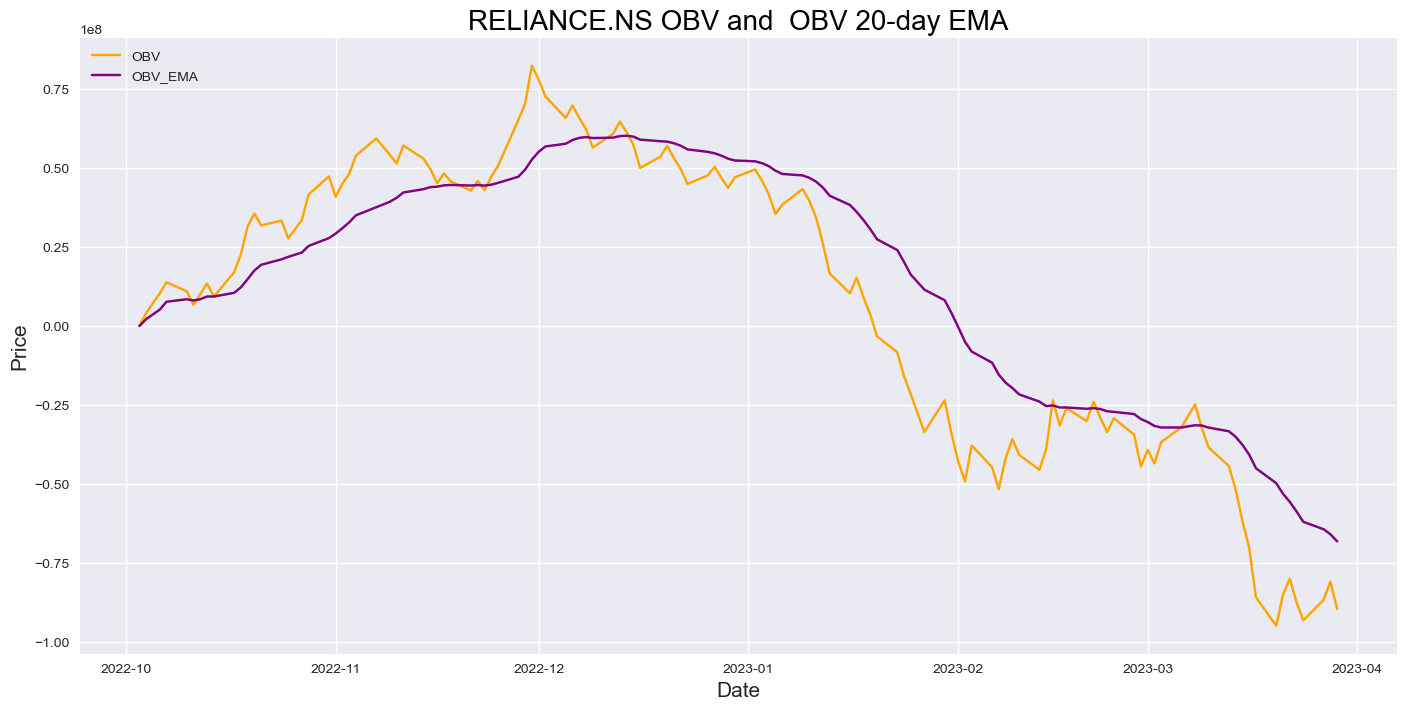

In [559]:
# Plot OBV and OBV with EMA of 20 days

def obv_ema():
  plt.figure(figsize=(17, 8))
  plt.style.use('seaborn')
  plt.plot(RELIANCEINDUSTRY_obv_6mo['OBV'], label = 'OBV', color = 'orange')
  plt.plot(RELIANCEINDUSTRY_obv_6mo['OBV_EMA'], label = 'OBV_EMA', color = 'purple')
  plt.title('RELIANCE.NS OBV and  OBV 20-day EMA', color = 'black', fontsize = 20)
  plt.xlabel('Date', fontsize = 15)
  plt.ylabel('Price', fontsize = 15)
  plt.legend(loc = 'upper left')
  plt.show()

obv_ema()

The strategy is to buy the stock whenever the OBV goes above the OBV EMA and sell whenever the OBV EMA goes above the OBV.

In [560]:
# Create function to signal when to buy and sell the stock
# If OBV > OBV_EMA then buy
# If OBV < OBV_EMA then sell
# Else do nothing

def buy_sell_obv(signal, col1, col2):
  sigPriceBuy = []
  sigPriceSell = []
  flag = -1

  for i in range(0, len(signal)):
    # If OBV > OBV_EMA then buy --> col1 => If OBV < OBV_EMA then sell => 'OBV_EMA'
    if signal[col1][i] > signal[col2][i] and flag != 1:
      sigPriceBuy.append(signal['Adj Close'][i])
      sigPriceSell.append(np.nan)
      flag = 1
     # If OBV < OBV_EMA then sell
    elif signal[col1][i] < signal[col2][i] and flag != 0:
      sigPriceSell.append(signal['Adj Close'][i])
      sigPriceBuy.append(np.nan)
      flag = 0
    else:
      sigPriceSell.append(np.nan)
      sigPriceBuy.append(np.nan)

  return (sigPriceBuy, sigPriceSell)

In [561]:
# Create buy and sell columns

x = buy_sell_obv(RELIANCEINDUSTRY_obv_6mo, 'OBV', 'OBV_EMA')
RELIANCEINDUSTRY_obv_6mo['Buy_Signal_Price'] = x[0]
RELIANCEINDUSTRY_obv_6mo['Sell_Signal_Price'] = x[1]

RELIANCEINDUSTRY_obv_6mo

Open         High          Low        Close    Adj Close  \
Date                                                                          
2022-10-03  2391.500000  2416.949951  2363.000000  2369.500000  2369.500000   
2022-10-04  2397.800049  2418.000000  2390.149902  2413.199951  2413.199951   
2022-10-06  2429.000000  2450.000000  2418.149902  2422.100098  2422.100098   
2022-10-07  2414.649902  2443.899902  2414.649902  2432.350098  2432.350098   
2022-10-10  2405.000000  2417.600098  2388.000000  2405.800049  2405.800049   
...                 ...          ...          ...          ...          ...   
2023-03-23  2268.000000  2269.899902  2243.050049  2247.800049  2247.800049   
2023-03-24  2245.250000  2250.000000  2198.000000  2203.300049  2203.300049   
2023-03-27  2217.500000  2254.000000  2200.199951  2237.550049  2237.550049   
2023-03-28  2245.000000  2256.500000  2237.000000  2248.000000  2248.000000   
2023-03-29  2239.000000  2244.800049  2211.100098  2234.699951  2234.699951   

             Volume       OBV       OBV_EMA  Buy_Signal_Price  \
Date                                                            
2022-10-03  5470030         0  0.000000e+00               NaN   
2022-10-04  4129893   4129893  2.168194e+06       2413.199951   
2022-10-06  6162021  10291914  5.151175e+06               NaN   
2022-10-07  3560167  13852081  7.662992e+06               NaN   
2022-10-10  2921076  10931005  8.453497e+06               NaN   
...             ...       ...           ...               ...   
2023-03-23  7499082 -87555936 -5.876954e+07               NaN   
2023-03-24  5711497 -93267433 -6.205508e+07               NaN   
2023-03-27  6486068 -86781365 -6.440998e+07               NaN   
2023-03-28  5804018 -80977347 -6.598783e+07               NaN   
2023-03-29  8678073 -89655420 -6.824189e+07               NaN   

            Sell_Signal_Price  
Date                           
2022-10-03                NaN  
2022-10-04                NaN  
2022-10-06                NaN  
2022-10-07                NaN  
2022-10-10                NaN  
...                       ...  
2023-03-23                NaN  
2023-03-24                NaN  
2023-03-27                NaN  
2023-03-28                NaN  
2023-03-29                NaN  

[123 rows x 10 columns]

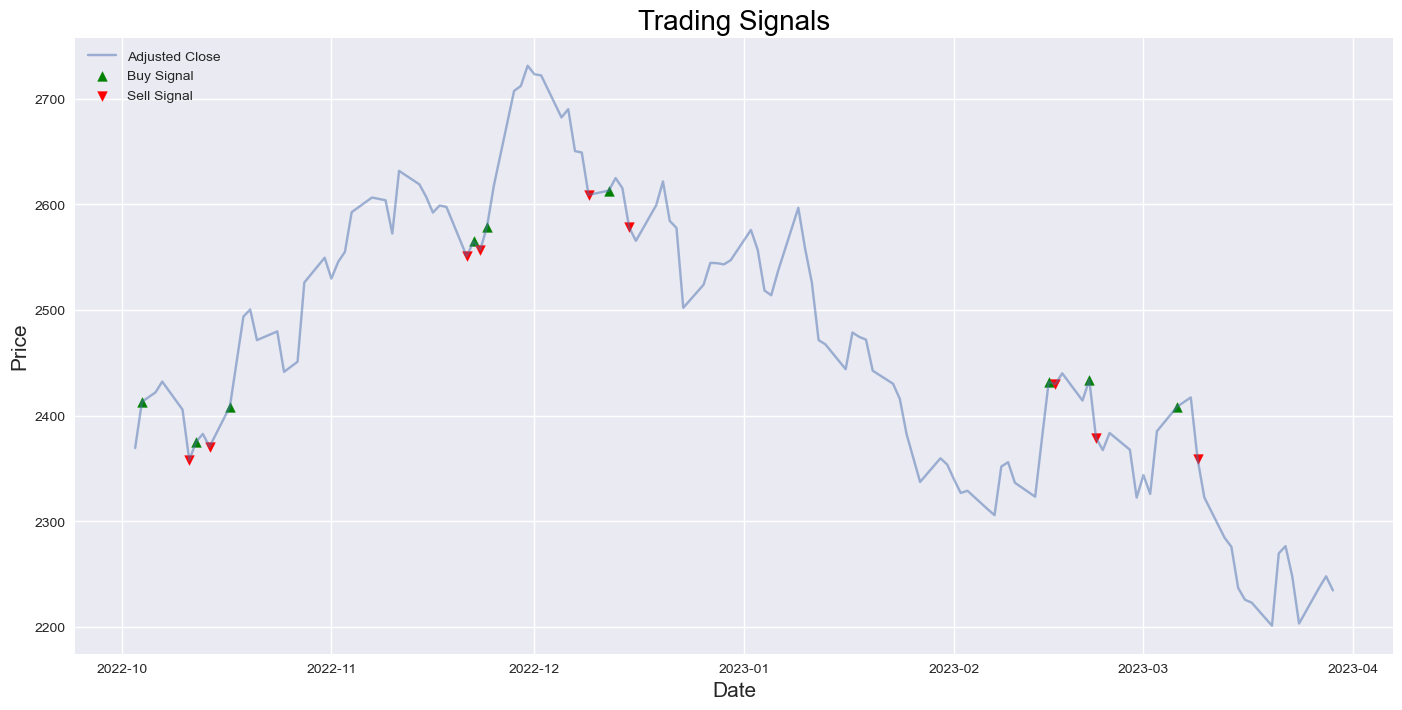

In [562]:
# Plot buy and sell trading signals

def obv_sig():
  plt.figure(figsize=(17, 8))
  plt.style.use('seaborn')
  plt.plot(RELIANCEINDUSTRY_obv_6mo['Adj Close'], label = 'Adjusted Close', alpha = 0.5)
  plt.scatter(RELIANCEINDUSTRY_obv_6mo.index, RELIANCEINDUSTRY_obv_6mo['Buy_Signal_Price'], label = 'Buy Signal', marker = '^', alpha = 1, color = 'green')
  plt.scatter(RELIANCEINDUSTRY_obv_6mo.index, RELIANCEINDUSTRY_obv_6mo['Sell_Signal_Price'], label = 'Sell Signal', marker = 'v', alpha = 1, color = 'red')
  plt.title('Trading Signals', color = 'black', fontsize = 20)
  plt.xlabel('Date', fontsize = 15)
  plt.ylabel('Price', fontsize = 15)
  plt.legend(loc = 'upper left')
  plt.show()

obv_sig()

## 6. Conclusion

It is almost certainly better to choose technical indicators that complement each other, not just those that move in unison and generate the same signals. The intuition here is that the more indicators you have that confirm each other, the better your chances are to profit. This can be done by combining strategies to form a system, and looking for multiple signals.